<a href="https://colab.research.google.com/github/ICBI/AIMAHEAD_GU/blob/main/Courses/ML_Concepts_in_R/Module_03_Non_Linearity/R_Version_of_Module_03_Handling_Non_Linearity2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/AAlogo1.jpg" alt="Powered by" width="150"/>

# AI/ML for Healthcare Applications : Lab 3 Handling non-linear data, Regularization, Feature Crosses and SVM kernels

Based on material from the Georgetown [Health Informatics and Data Science](https://healthinformatics.georgetown.edu) program and licensed under  [CC4.0](https://creativecommons.org/licenses/by/4.0/)

In this workshop we will explore how to classify non-linear data using linear classifiers such as Logistic Regression and SVM

#### **Packages**

We will start by loading some of the packages that will help us
organize and visualize the data. Other packages will be loaded as necessary.

In [1]:
library(ggplot2)
library(dplyr)
library(tidyr)

# Set default plot theme (equivalent to seaborn's default in Python)
theme_set(theme_minimal())

# Set plot size and general theme options for all plots
options(repr.plot.width = 10, repr.plot.height = 10)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




#### **Logistic Regression as a linear classifier: Recap**


We need to write a function to generate linear seperable synthetic data. We do this using the "mlbench" library to generate our 2 distributions. For more see: https://www.rdocumentation.org/packages/mlbench/versions/2.1-6

In [2]:
library(MASS)
install.packages("mlbench")
library(mlbench)

set.seed(2)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



The "2dnormals" function is used to generate samples with 200 datapoints.

In [3]:
# Use mlbench.2dnormals to create two informative features and two classes
n_samples <- 200
n_clusters_per_class <- 1
data <- mlbench.2dnormals(n_samples, 2)  # 2 classes and 2 informative features

# Extract features and labels
X <- data$x
y <- as.factor(data$classes)

# Create a data frame for plotting
df <- data.frame(X1 = X[, 1], X2 = X[, 2], label = y)


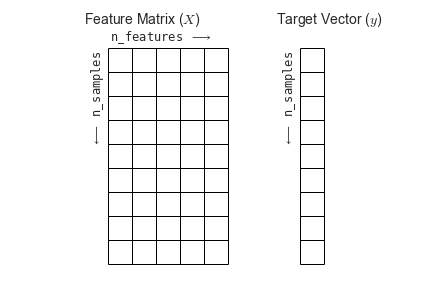

Here we can see the distribution of the 2 classes of data we generated.

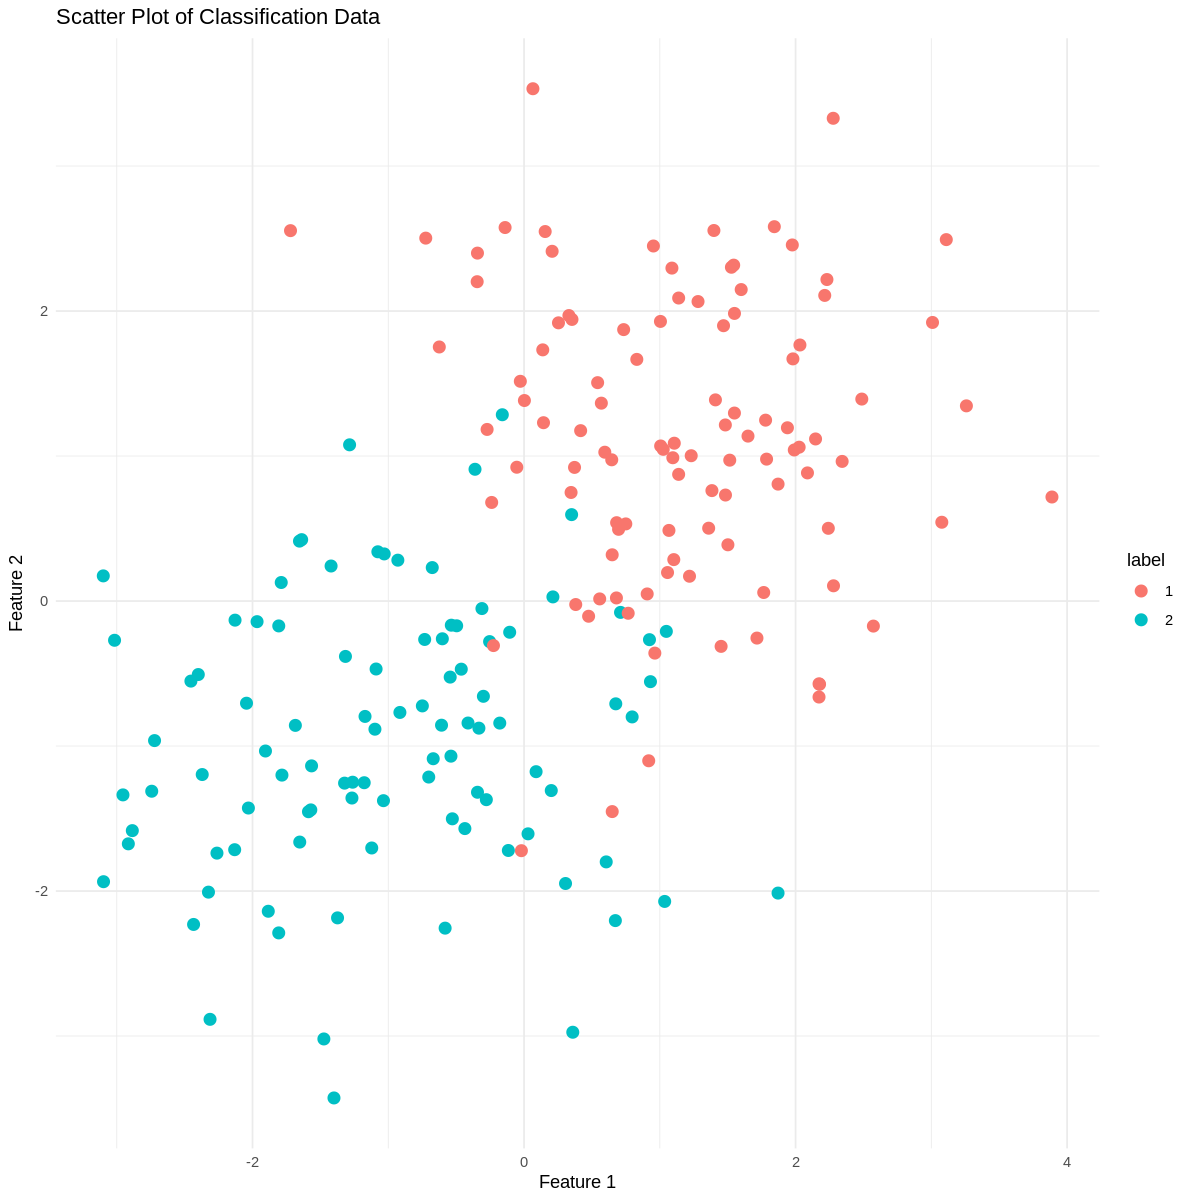

In [4]:
ggplot(df, aes(x = X1, y = X2, color = label)) +
  geom_point(size = 3) +
  labs(title = "Scatter Plot of Classification Data", x = "Feature 1", y = "Feature 2") +
  theme_minimal()

We can explore the structure of the dataset using dim() length() and head().

In [5]:
dim(X)
length(y)

[1] 200   2

[1] 200

In [6]:
head(X)

0.1378017,1.7321793
1.0480403,-0.2094553
1.9399201,1.1948532
3.0086871,1.9211780
-1.4213736,0.2414562
0.6491656,0.3188292


In [7]:
head(y)

[1] 1 2 1 1 2 1
Levels: 1 2

We can write a function to plot the 2D dataset as well.

In [8]:
visualize_2d <- function(X, y, title = "Data in 2D") {

  # Convert to a data frame
  df <- data.frame(X1 = X[, 1], X2 = X[, 2], label = as.factor(y))

  # Create the plot
  plot <- ggplot(df, aes(x = X1, y = X2, color = label)) +
    geom_point(size = 3) +
    labs(title = title, x = "x1", y = "x2") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5))

  return(plot)  # Return the ggplot object (equivalent to fig in Python)
}


That lets us save our plots as an object in R.

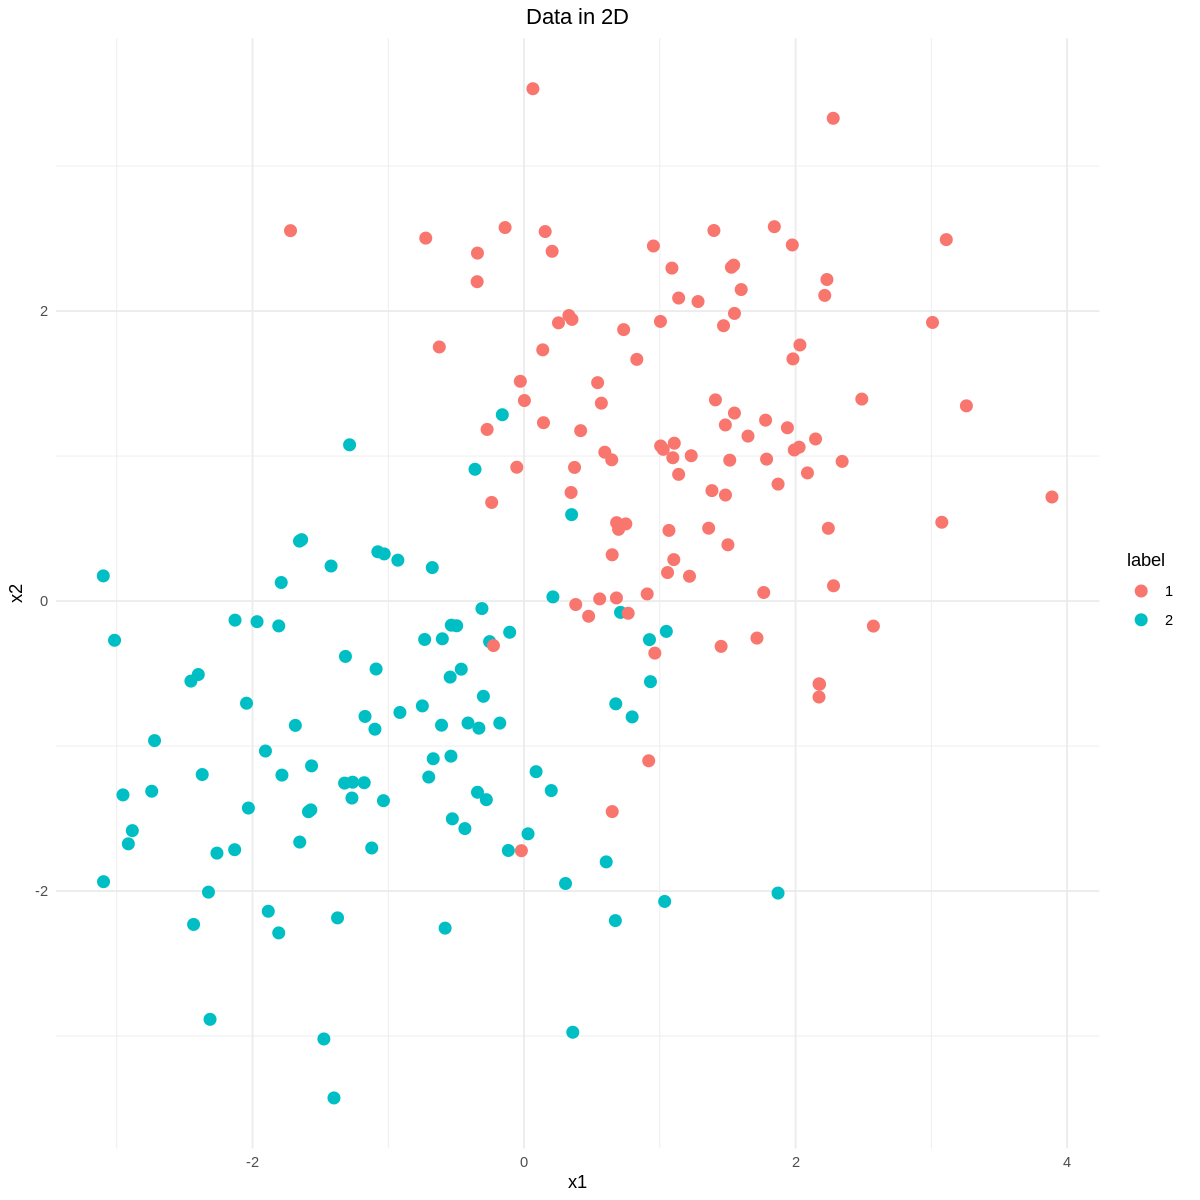

In [9]:
fig <- visualize_2d(X, y)
fig

We can also write our own function to generate the data. Below, we use the built in functions to generate the different classes of our dataset. The number of classes corresponds to the number of random points we want to use as the central point of the distribution. We can also increase the number of features in the dataset beyond 2.

In [10]:
make_blobs <- function(n_samples, n_features, centers, cluster_std) {
  blobs <- list()
  labels <- rep(NA, n_samples)
  samples_per_center <- n_samples / centers
  for (i in 1:centers) {
    # Create blob with multivariate normal distribution
    mu <- rnorm(n_features, mean = i * 2)
    sigma <- diag(cluster_std, n_features)
    blob <- mvrnorm(n = samples_per_center, mu = mu, Sigma = sigma)
    blobs[[i]] <- blob
    labels[((i - 1) * samples_per_center + 1):(i * samples_per_center)] <- i
  }
  X <- do.call(rbind, blobs)
  return(list(X = X, labels = labels))
}

In [11]:
blobs <- make_blobs(n_samples = 200, n_features = 2, centers = 2, cluster_std = 0.60)
X <- blobs$X
y <- blobs$labels

We can use the previously written function to visualize the 2 features for each point in the dataset, colored by their class label.

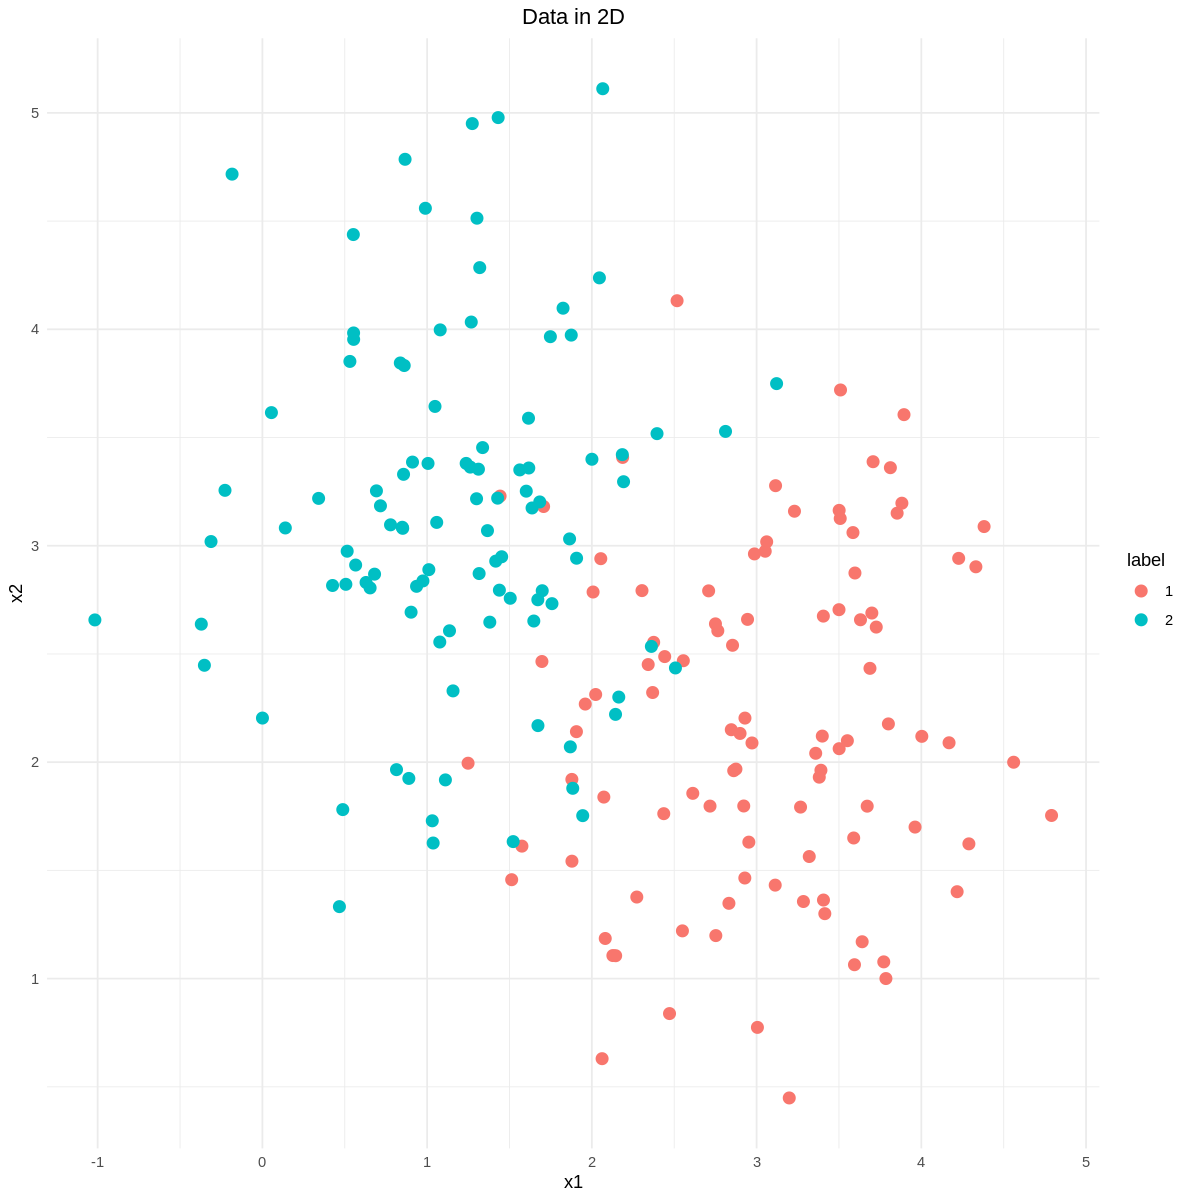

In [12]:
fig <- visualize_2d(X, y)
print(fig)

Visualize the data

Let's fit a Logistic Regression model on this 2d data

In [13]:
df <- data.frame(X1 = X[, 1], X2 = X[, 2], label = as.factor(y))

# Fit the logistic regression model
logistic_model <- glm(label ~ X1 + X2, data = df, family = "binomial")

# Summary of the model
summary(logistic_model)


Call:
glm(formula = label ~ X1 + X2, family = "binomial", data = df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.1675     1.3542   1.601    0.109    
X1           -3.3486     0.5455  -6.139 8.30e-10 ***
X2            1.8087     0.4508   4.012 6.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 277.259  on 199  degrees of freedom
Residual deviance:  77.188  on 197  degrees of freedom
AIC: 83.188

Number of Fisher Scoring iterations: 7


We need to write a function that will plot a line on the 2D plot of the data. First, a grid of xy points is gene. Using the trained model, the prediction for each point on the grid is made, and used to generate the decision boundary.

In [14]:
# Function to plot decision boundary in R
plot_lr_decision_boundary <- function(model, df) {
  # Create a grid of values
  xlim <- range(df$X1)
  ylim <- range(df$X2)

  # Create grid of values
  grid <- expand.grid(X1 = seq(xlim[1], xlim[2], length.out = 100),
                      X2 = seq(ylim[1], ylim[2], length.out = 100))

  # Predict probabilities for grid
  grid$prob <- predict(model, newdata = grid, type = "response")

  # Plot data and decision boundary using ggplot2
  library(ggplot2)
  p <- ggplot(df, aes(x = X1, y = X2, color = label)) +
    geom_point() +
    geom_contour(data = grid, aes(z = prob), breaks = 0.5, color = "black") +
    labs(title = "Logistic Regression Decision Boundary") +
    theme_minimal()

  print(p)
}


Visualize the decision boundry. We can see the result is a line that separates the 2 labels in the dataset.

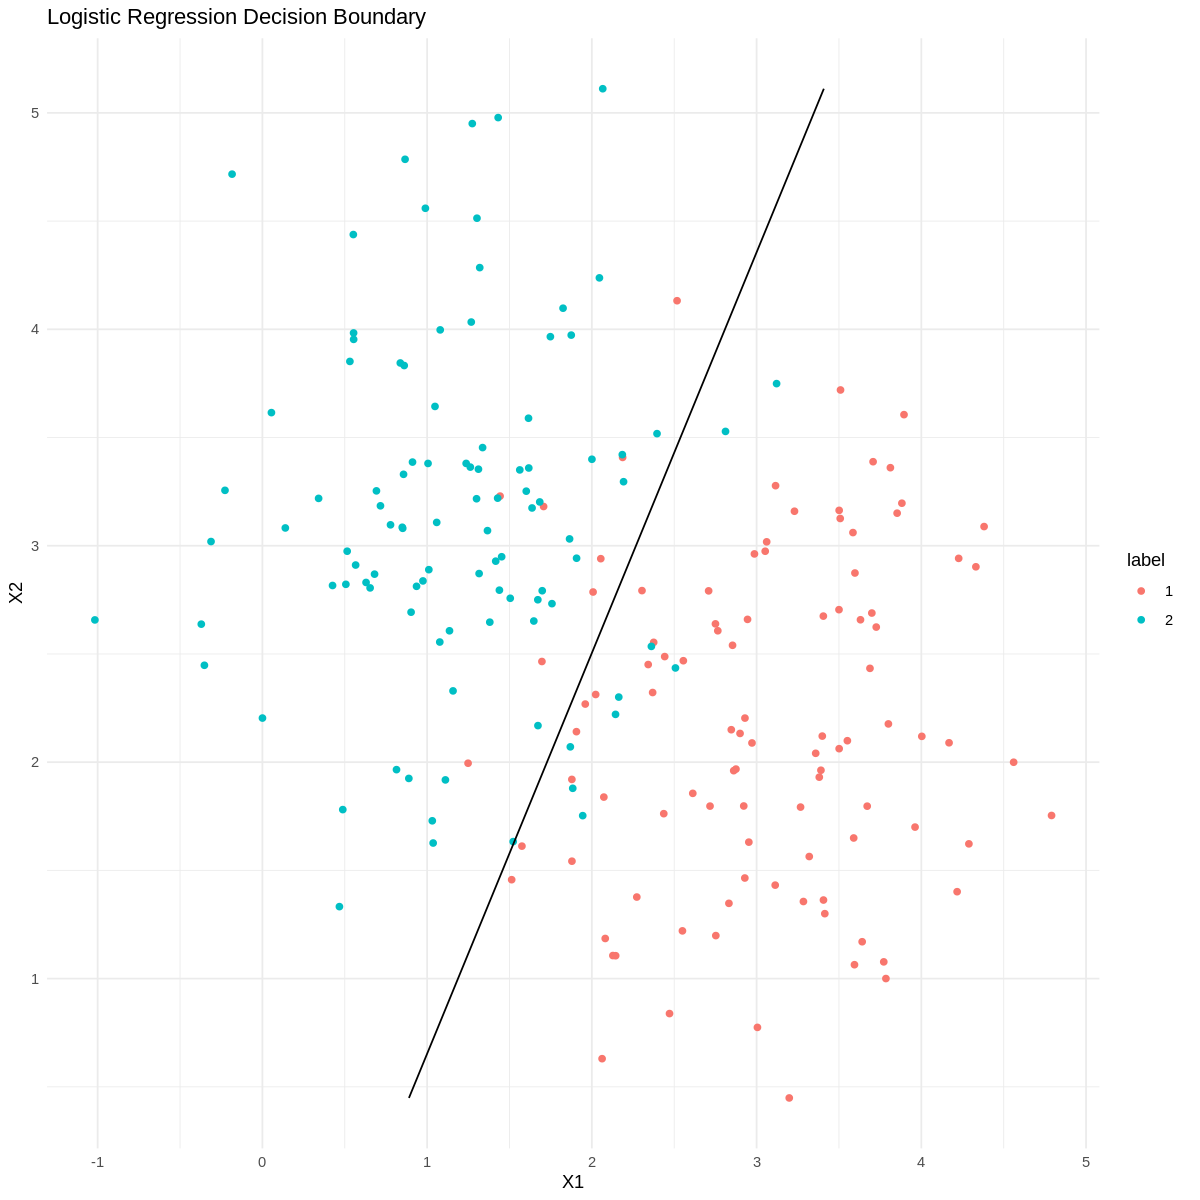

In [15]:
# Example usage:
# Assume 'df' is the dataframe and 'logistic_model' is the fitted model
plot_lr_decision_boundary(logistic_model, df)


#### **Encoding Non-linearity: Feature Crosses in Logistic Regression (LR)**

A feature cross is a synthetic feature that encodes nonlinearity in the feature space by multiplying two or more input features together.
Example: x3 = x1*x2

To generate a non-linearly seperable 2d data set, we create labels for a normally distributed set of 2D points based on thier quadrant in the 2D plot.

In [16]:
create_xor_dataset <- function(num_samples = 100) {
  set.seed(0)
  X <- matrix(rnorm(num_samples * 2), ncol = 2)
  y_xor <- xor(X[, 1] > 0, X[, 2] > 0)
  y <- ifelse(y_xor, 1, 0)
  return(list(X = X, y = y))
}


In [17]:
xor_data <- create_xor_dataset(200)
X <- xor_data$X
y <- xor_data$y

In [18]:
# Check first 10 labels
head(y, 10)


[1] 1 0 0 0 0 1 0 1 0 1

We can plot the XOR dataset, and see the distribution of the labels.

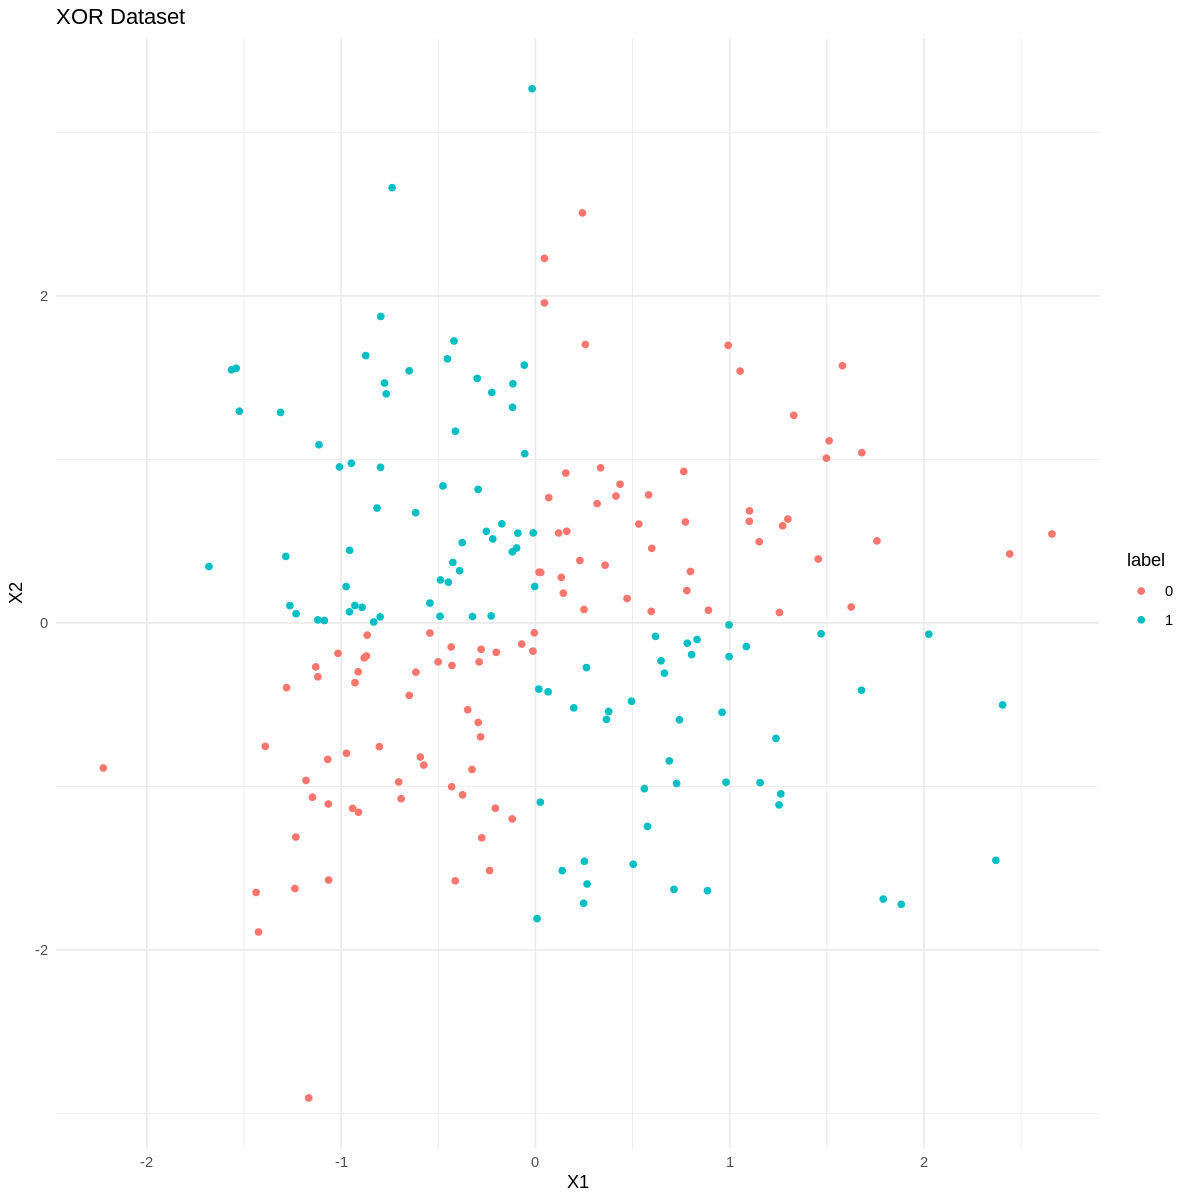

In [19]:
# Visualize in 2D
df <- data.frame(X1 = X[, 1], X2 = X[, 2], label = as.factor(y))
ggplot(df, aes(x = X1, y = X2, color = label)) +
  geom_point() +
  labs(title = "XOR Dataset") +
  theme_minimal()

We first fit an LR model without generating a feature cross.

In [20]:
# Convert the generated data to a dataframe for R
df <- data.frame(X1 = X[, 1], X2 = X[, 2], label = as.factor(y))

# Fit the logistic regression model
lr_model <- glm(label ~ X1 + X2, data = df, family = "binomial")

# Summary of the model
summary(lr_model)


Call:
glm(formula = label ~ X1 + X2, family = "binomial", data = df)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.01366    0.14210   0.096    0.923
X1          -0.01046    0.15421  -0.068    0.946
X2           0.18367    0.14388   1.277    0.202

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 277.24  on 199  degrees of freedom
Residual deviance: 275.59  on 197  degrees of freedom
AIC: 281.59

Number of Fisher Scoring iterations: 3


When we plot the decision boundary, we see the model doesn't do a good job of separating the labels.

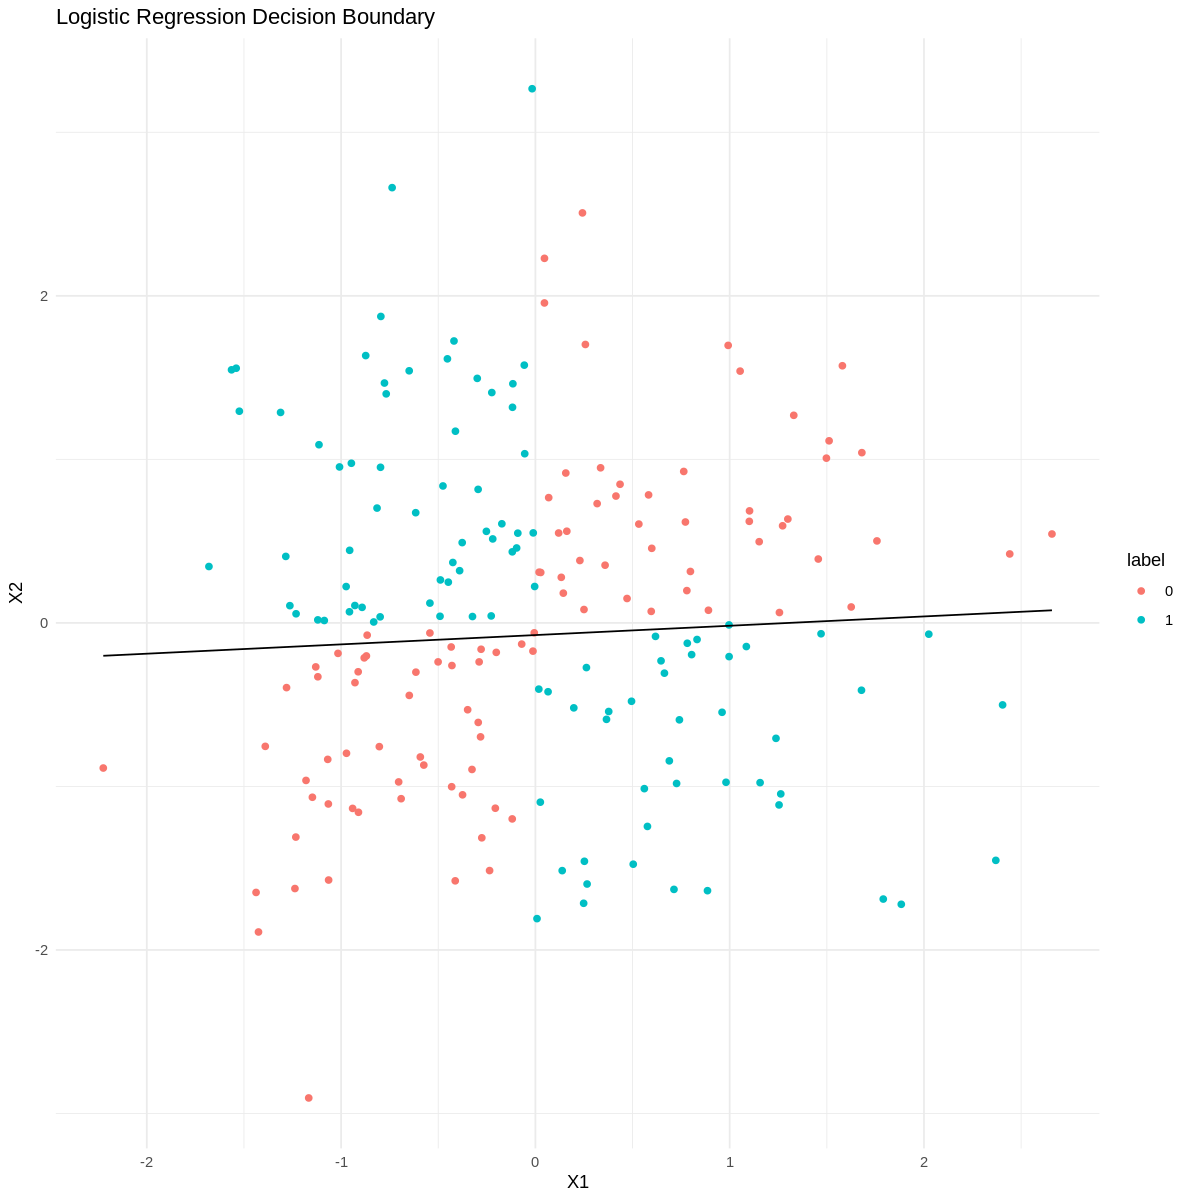

In [21]:
plot_lr_decision_boundary(lr_model,df)

We transform 2D data to higher dimension by adding a feature cross. The 3rd feature is going to be the product of the two features.



In [22]:
x3 <- X[, 1] * X[, 2]

In [23]:
length(x3)

[1] 200

In [24]:
head(x3,10)

[1] -1.3206935891  0.2923740125  1.6880301145  0.7556206353  0.3216101266
 [6] -2.3982725763  0.3393000630 -0.2406558814  0.0003496912 -1.2056410710

In [25]:
X_df <- data.frame(x1 = X[, 1], x2 = X[, 2], x3 = x3, y = y)

In [26]:
head(X_df)

,x1,x2,x3,y
,<dbl>,<dbl>,<dbl>,<dbl>
1,1.2629543,-1.0457177,-1.3206936,1
2,-0.3262334,-0.8962113,0.2923740,0
3,1.3297993,1.2693872,1.6880301,0
4,1.2724293,0.5938409,0.7556206,0
5,0.4146414,0.7756343,0.3216101,0
6,-1.5399500,1.5573704,-2.3982726,1


In [27]:
X_transformed <- as.matrix(X_df[, c("x1", "x2", "x3")])

Now we have a dataset with 3 features, one of them being our feature cross.

In [28]:
dim(X)           # Dimensions of the original X
dim(X_transformed) # Dimensions of X_transformed

[1] 200   2

[1] 200   3

In [29]:
# Install plotly if not installed
if (!requireNamespace("plotly", quietly = TRUE)) {
   install.packages("plotly")
}

library(plotly)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’



Attaching package: ‘plotly’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [30]:
visualize_3d <- function(X, y) {
  fig <- plot_ly(x = ~X[, 1], y = ~X[, 2], z = ~X[, 3],
                 color = ~as.factor(y), colors = c("#636EFA", "#EF553B"),
                 type = "scatter3d", mode = "markers")
  fig <- fig %>% layout(scene = list(xaxis = list(title = 'x1'),
                                     yaxis = list(title = 'x2'),
                                     zaxis = list(title = 'x3')))
  fig
}

In [31]:
if (!requireNamespace("scatterplot3d", quietly = TRUE)) {
  install.packages("scatterplot3d")
}
library(scatterplot3d)
visualize_3d <- function(X, y, angles = c(0, 45, 90, 135, 180)) {
  colors <- c("#636EFA", "#EF553B")
  color_labels <- colors[as.factor(y)]

  par(mfrow = c(2, 3))  # Set up the plotting area to display multiple plots

  for (angle in angles) {
    scatterplot3d(X[, 1], X[, 2], X[, 3], color = color_labels, pch = 16,
                  xlab = "x1", ylab = "x2", zlab = "x3", main = paste("Angle:", angle),
                  angle = angle)
  }

  par(mfrow = c(1, 1))  # Reset the plotting area
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



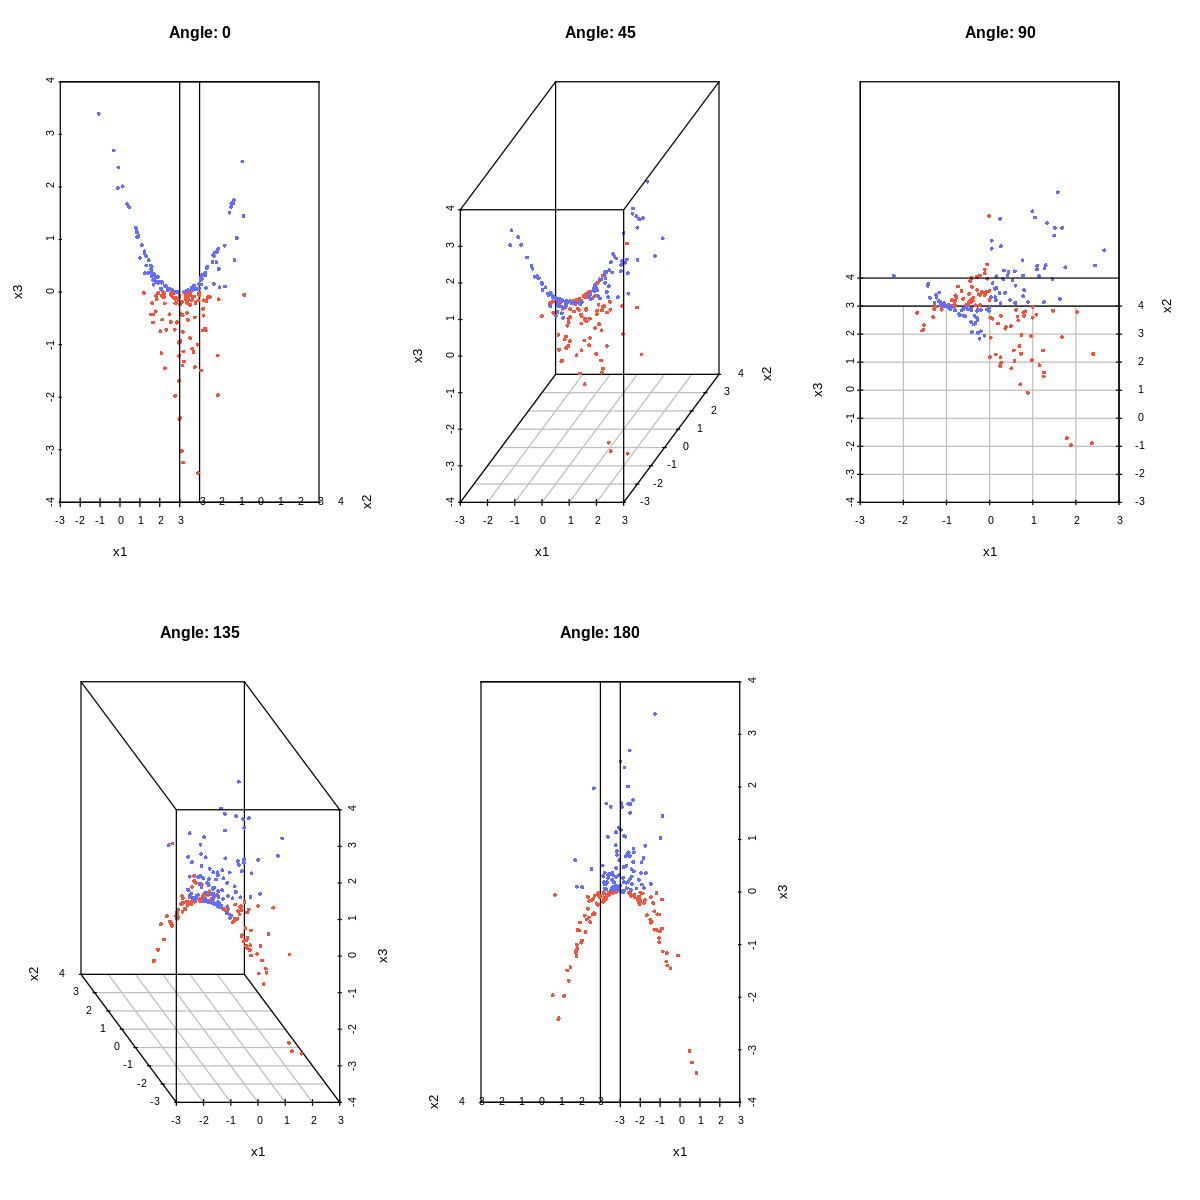

In [32]:
visualize_3d(X_transformed,y)

We can fit the LR model with our feature cross added to the data.
Note: may take 6+ minutes to load caret library below

In [33]:
# Install necessary packages if not already installed
if (!requireNamespace("caret", quietly = TRUE)) {
  install.packages("caret")
}
if (!requireNamespace("e1071", quietly = TRUE)) {
  install.packages("e1071")  # for logistic regression
}

library(caret)
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice



In [34]:
# Fit logistic regression model in 2D and 3D
lr_model_2d <- glm(y ~ X_df$x1 + X_df$x2, family = binomial)
lr_model_3d <- glm(y ~ X_df$x1 + X_df$x2 + X_df$x3, family = binomial)


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


We can compare the performace of the model on the 2D and 3D datasets by setting a threshold of 0.5 on the prediction probability.

In [35]:
# Predict for 2D and 3D models
y1 <- ifelse(predict(lr_model_2d, type = "response") > 0.5, 1, 0)
y2 <- ifelse(predict(lr_model_3d, type = "response") > 0.5, 1, 0)

We can build a confusion matrix of the predicitions, and see the 3D model preforms much better than the 2D model.

In [36]:
# Classification report equivalent: confusion matrix and metrics
conf_matrix_2d <- confusionMatrix(as.factor(y1), as.factor(y))
conf_matrix_3d <- confusionMatrix(as.factor(y2), as.factor(y))

# Print results
conf_matrix_2d
conf_matrix_3d

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 49 42
         1 50 59
                                          
               Accuracy : 0.54            
                 95% CI : (0.4683, 0.6105)
    No Information Rate : 0.505           
    P-Value [Acc > NIR] : 0.1790          
                                          
                  Kappa : 0.0792          
                                          
 Mcnemar's Test P-Value : 0.4655          
                                          
            Sensitivity : 0.4949          
            Specificity : 0.5842          
         Pos Pred Value : 0.5385          
         Neg Pred Value : 0.5413          
             Prevalence : 0.4950          
         Detection Rate : 0.2450          
   Detection Prevalence : 0.4550          
      Balanced Accuracy : 0.5396          
                                          
       'Positive' Class : 0               
                                    

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  99   0
         1   0 101
                                     
               Accuracy : 1          
                 95% CI : (0.9817, 1)
    No Information Rate : 0.505      
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.000      
            Specificity : 1.000      
         Pos Pred Value : 1.000      
         Neg Pred Value : 1.000      
             Prevalence : 0.495      
         Detection Rate : 0.495      
   Detection Prevalence : 0.495      
      Balanced Accuracy : 1.000      
                                     
       'Positive' Class : 0          
                                     

In [37]:
# Print detailed metrics
print("2D Logistic Regression Performance")
print(conf_matrix_2d$byClass)  # Includes precision, recall, F1, and support

[1] "2D Logistic Regression Performance"
         Sensitivity          Specificity       Pos Pred Value 
           0.4949495            0.5841584            0.5384615 
      Neg Pred Value            Precision               Recall 
           0.5412844            0.5384615            0.4949495 
                  F1           Prevalence       Detection Rate 
           0.5157895            0.4950000            0.2450000 
Detection Prevalence    Balanced Accuracy 
           0.4550000            0.5395540 


In [38]:
print("3D Logistic Regression Performance")
print(conf_matrix_3d$byClass)  # Includes precision, recall, F1, and support

[1] "3D Logistic Regression Performance"
         Sensitivity          Specificity       Pos Pred Value 
               1.000                1.000                1.000 
      Neg Pred Value            Precision               Recall 
               1.000                1.000                1.000 
                  F1           Prevalence       Detection Rate 
               1.000                0.495                0.495 
Detection Prevalence    Balanced Accuracy 
               0.495                1.000 


To make things easier, we can write a funtion to get the results of the GLM training.

In [39]:
get_training_results_glm <- function(X, y) {

  # Create a data frame with X (features) and y (labels)
  df <- as.data.frame(cbind(X, y))

  # Fit logistic regression model
  model <- glm(y ~ ., data = df, family = binomial)

  # Predict class probabilities on training data
  y_pred_prob <- predict(model, df, type = "response")

  # Convert probabilities to binary labels (threshold = 0.5)
  y_pred <- ifelse(y_pred_prob > 0.5, 1, 0)

  # Confusion matrix and classification report
  results <- confusionMatrix(as.factor(y_pred), as.factor(y), mode = "everything")

  # Print classification metrics (precision, recall, F1-score, etc.)
  print(results)
}

Try another dataset, this time the nonlinear data willbe labels by the distance from the origin of the 2D dataset.

In [40]:
make_circles <- function(n_samples = 200, factor = 0.3, noise = 0.3) {
  theta <- runif(n_samples, 0, 2 * pi)
  r <- c(rep(1, n_samples / 2), rep(factor, n_samples / 2))

  X <- r * cbind(cos(theta), sin(theta)) + matrix(rnorm(n_samples * 2, 0, noise), ncol = 2)
  y <- c(rep(0, n_samples / 2), rep(1, n_samples / 2))

  data.frame(X1 = X[, 1], X2 = X[, 2], label = y)
}

# Generate circular dataset
data <- make_circles(n_samples = 200, factor = 0.3, noise = 0.3)



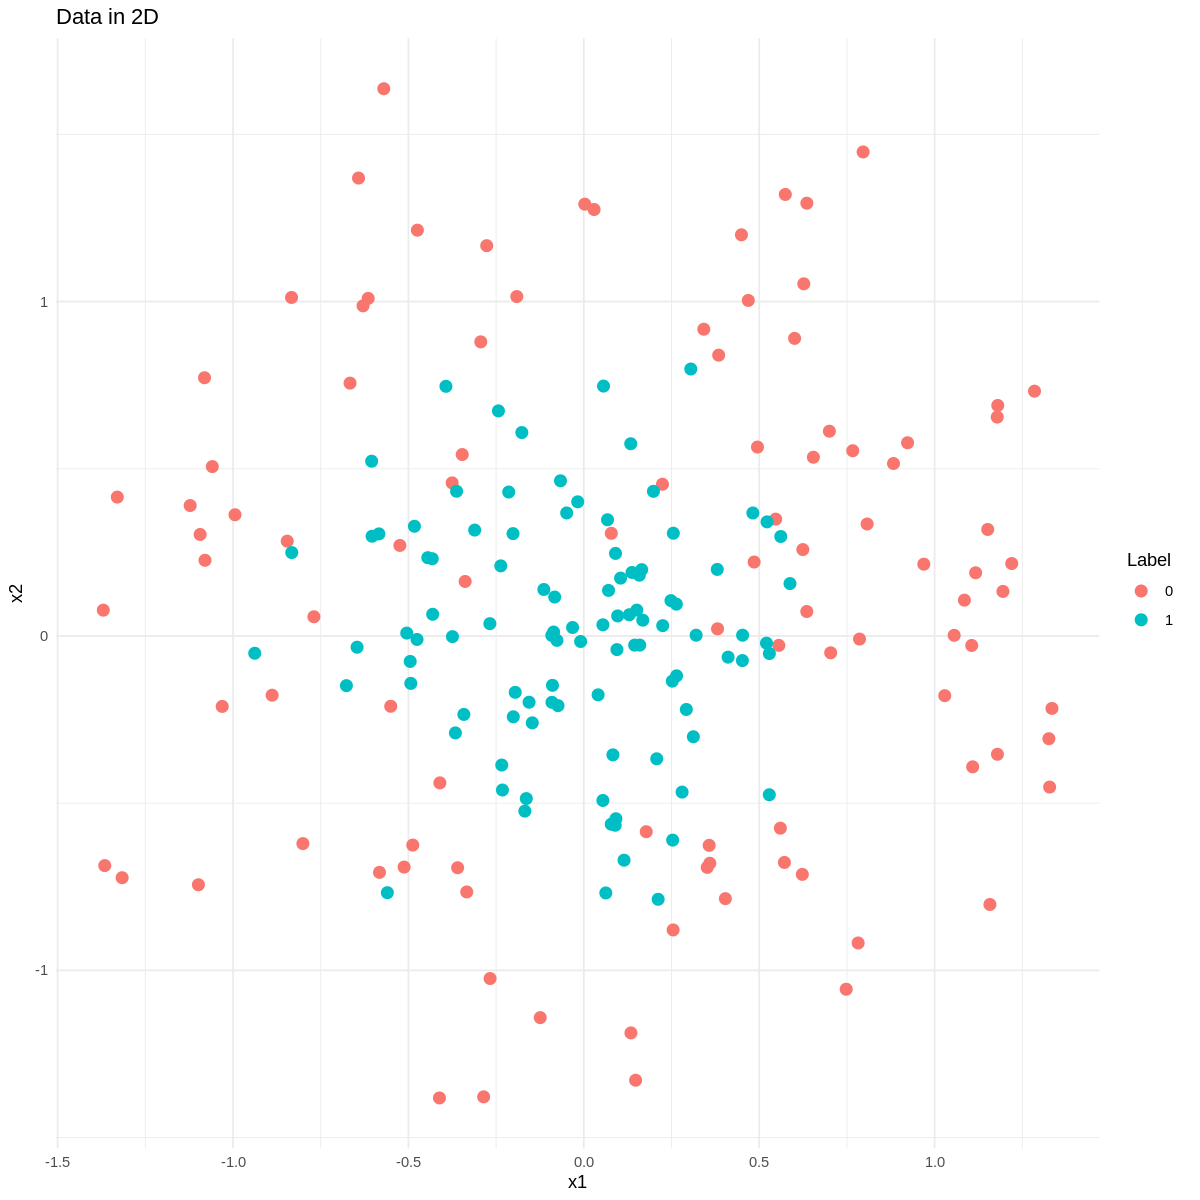

In [41]:
ggplot(data, aes(x = X1, y = X2, color = as.factor(label))) +
  geom_point(size = 3) +
  labs(title = "Data in 2D", x = "x1", y = "x2", color = "Label") +
  theme_minimal()

Our new, non-linear feature is generated by calculating the e raised the negative sum of squares.

In [42]:
# Calculate new feature x3 as the radial basis function (exp(-sum of squares))
X <- data

X_transformed <- data %>%
  mutate(x3 = exp(-(X1^2 + X2^2)))

In [43]:
# Display the first few rows of the transformed dataset
head(X_transformed)


,X1,X2,label,x3
,<dbl>,<dbl>,<dbl>,<dbl>
1,1.0850222,0.1071231,0,0.3046022
2,0.7000517,0.6122521,0,0.4210831
3,1.2199217,0.2166256,0,0.2154265
4,-0.4743738,1.2134650,0,0.1831357
5,1.1786074,0.6545851,0,0.1624156
6,-1.0308133,-0.2106632,0,0.3305640


In [44]:
head(X)

,X1,X2,label
,<dbl>,<dbl>,<dbl>
1,1.0850222,0.1071231,0
2,0.7000517,0.6122521,0
3,1.2199217,0.2166256,0
4,-0.4743738,1.2134650,0
5,1.1786074,0.6545851,0
6,-1.0308133,-0.2106632,0


In [45]:
X_transformed <- X_transformed %>% select(X1, X2, x3) %>% as.matrix()

In [46]:
dim(X[,-3]) #remove y
dim(X_transformed)  #y removed

[1] 200   2

[1] 200   3

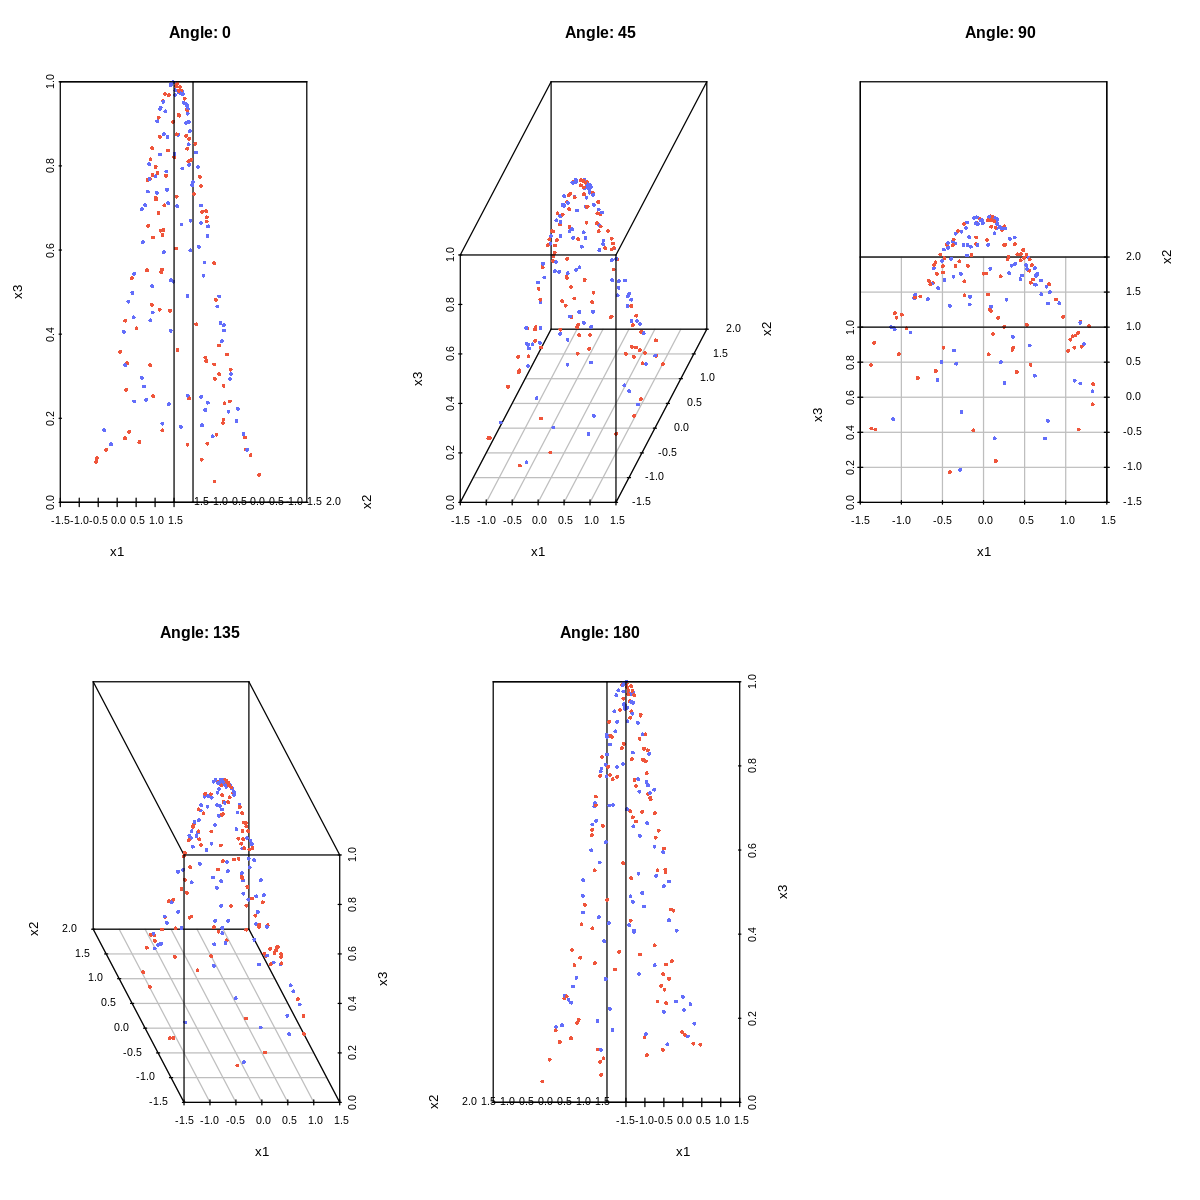

In [47]:
visualize_3d(X_transformed, y)

As with the previous example, we can see that adding the additional feature improves the performance of the GLM.

In [48]:
X_df<-X[,-3]
get_training_results_glm(X_df, data$label)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 56 43
         1 44 57
                                          
               Accuracy : 0.565           
                 95% CI : (0.4933, 0.6348)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 0.03842         
                                          
                  Kappa : 0.13            
                                          
 Mcnemar's Test P-Value : 1.00000         
                                          
            Sensitivity : 0.5600          
            Specificity : 0.5700          
         Pos Pred Value : 0.5657          
         Neg Pred Value : 0.5644          
              Precision : 0.5657          
                 Recall : 0.5600          
                     F1 : 0.5628          
             Prevalence : 0.5000          
         Detection Rate : 0.2800          
   Detection Prevalence : 0.4950          
      Balanced Accuracy : 0.5650    

In [49]:
get_training_results_glm(X_transformed, data$label)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 87 10
         1 13 90
                                          
               Accuracy : 0.885           
                 95% CI : (0.8325, 0.9257)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.77            
                                          
 Mcnemar's Test P-Value : 0.6767          
                                          
            Sensitivity : 0.8700          
            Specificity : 0.9000          
         Pos Pred Value : 0.8969          
         Neg Pred Value : 0.8738          
              Precision : 0.8969          
                 Recall : 0.8700          
                     F1 : 0.8832          
             Prevalence : 0.5000          
         Detection Rate : 0.4350          
   Detection Prevalence : 0.4850          
      Balanced Accuracy : 0.8850    

Another way to add in non-linear features is to generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].




We define the following polynomial features of degree $d$ for two variables $x_1$ and $x_2$:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

For example, for $d=3$, this will be the following features:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

In [50]:
poly <- function(X, degree) {
  model.matrix(~ poly(X1, X2, degree=degree, raw=TRUE), data=X)
}

#This code only works in some version of R

In [51]:
set.seed(0)
X_df <- X[,-3]
X_df <- as.data.frame(X_df)
# Manually generate polynomial features up to degree 2
X_transformed <- data.frame(
  X1_1 = 1,
  X1 = X_df$X1,
  X2 = X_df$X2,
  X1_squared = X_df$X1^2,
  X2_squared = X_df$X2^2,
  X1_X2 = X_df$X1 * X_df$X2
)


We write a function that will loop through all the current features, and generate all the polynomial combinations.

In [52]:
create_polynomial_features <- function(X, degree) {
  n <- nrow(X)
  poly_features <- do.call(cbind, lapply(0:degree, function(d) {
    if (d == 0) return(rep(1, n))  # Intercept term
    if (d == 1) return(X)  # Linear terms
    return(sapply(1:ncol(X), function(i) X[, i]^d))
  }))

  # Adding interaction terms
  if (degree > 1) {
    for (i in 1:ncol(X)) {
      for (j in i:ncol(X)) {
        if (i != j) {
          poly_features <- cbind(poly_features, X[, i] * X[, j])
        }
      }
    }
  }

  return(poly_features)
}


We can use the prior 2D dataset as an example.

In [53]:
head(X,10)

,X1,X2,label
,<dbl>,<dbl>,<dbl>
1,1.0850222,0.10712313,0
2,0.7000517,0.61225211,0
3,1.2199217,0.21662565,0
4,-0.4743738,1.21346502,0
5,1.1786074,0.65458512,0
6,-1.0308133,-0.21066317,0
7,0.6244475,0.25834450,0
8,1.1058243,-0.02839642,0
9,0.4688785,1.00335893,0


The transformed dataset has added several new features.

In [54]:
X_transformed <- create_polynomial_features(X_df,2) #or we can use the create polynomial function
colnames(X_transformed) <- c("X1_1","X1","X2","X1_squared","X2_squared","X1_X2")

In [55]:
# View the first 10 transformed rows
X_transformed[1:10, ]


,X1_1,X1,X2,X1_squared,X2_squared,X1_X2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.0850222,0.10712313,1.1772733,0.0114753652,0.11623098
2,1,0.7000517,0.61225211,0.4900724,0.3748526435,0.42860814
3,1,1.2199217,0.21662565,1.4882090,0.0469266711,0.26426633
4,1,-0.4743738,1.21346502,0.2250305,1.4724973551,-0.57563598
5,1,1.1786074,0.65458512,1.3891154,0.4284816781,0.77149885
6,1,-1.0308133,-0.21066317,1.0625761,0.0443789716,0.21715440
7,1,0.6244475,0.25834450,0.3899347,0.0667418816,0.16132258
8,1,1.1058243,-0.02839642,1.2228474,0.0008063565,-0.03140145
9,1,0.4688785,1.00335893,0.2198471,1.0067291495,0.47045345


In [56]:

# Get feature names (R doesn't have direct 'get_feature_names_out', but we can infer)
colnames(X_transformed)

[1] "X1_1"       "X1"         "X2"         "X1_squared" "X2_squared"
[6] "X1_X2"

In [57]:
colnames(X) <- c("X1","X2","y")
y = X$y

log_reg_model <- glm(y ~ X1_1 + X1 + X2 + X1_squared + X2_squared + X1_X2,
                     data = X_transformed, family = binomial)

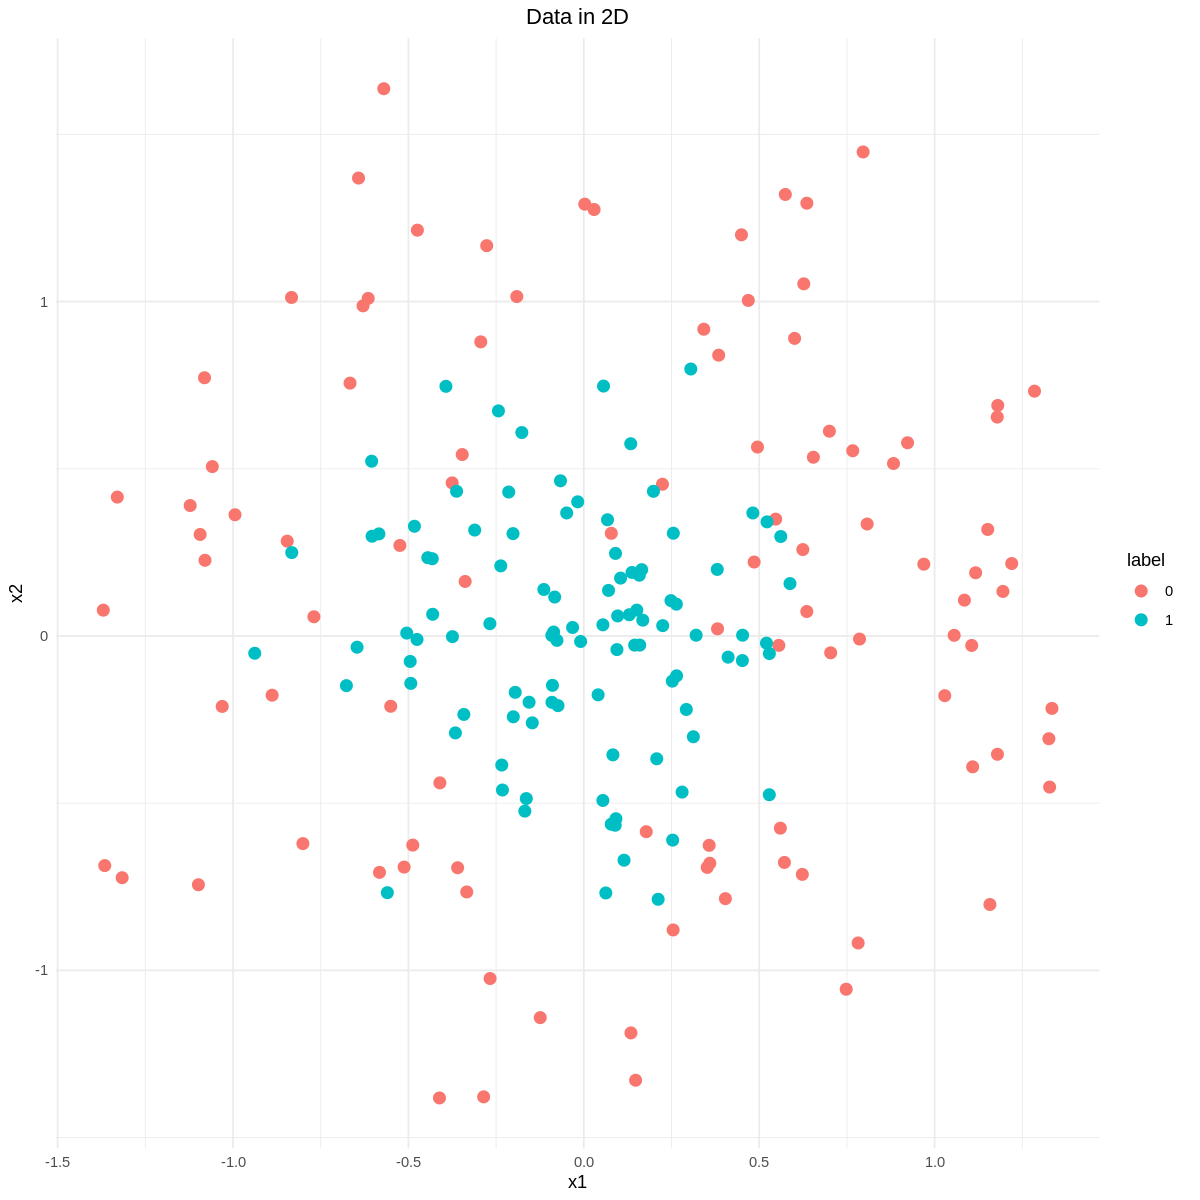

In [58]:
visualize_2d(X, y)

In [59]:
log_reg_model
log_reg_model <- glm(y ~ X1 + X2 + X1_squared + X2_squared + X1_X2,
                     data = X_transformed, family = binomial)


Call:  glm(formula = y ~ X1_1 + X1 + X2 + X1_squared + X2_squared + 
    X1_X2, family = binomial, data = X_transformed)

Coefficients:
(Intercept)         X1_1           X1           X2   X1_squared   X2_squared  
     3.5298           NA      -1.3060       0.1816      -7.6765      -5.7832  
      X1_X2  
    -0.7430  

Degrees of Freedom: 199 Total (i.e. Null);  194 Residual
Null Deviance:	    277.3 
Residual Deviance: 111.4 	AIC: 123.4

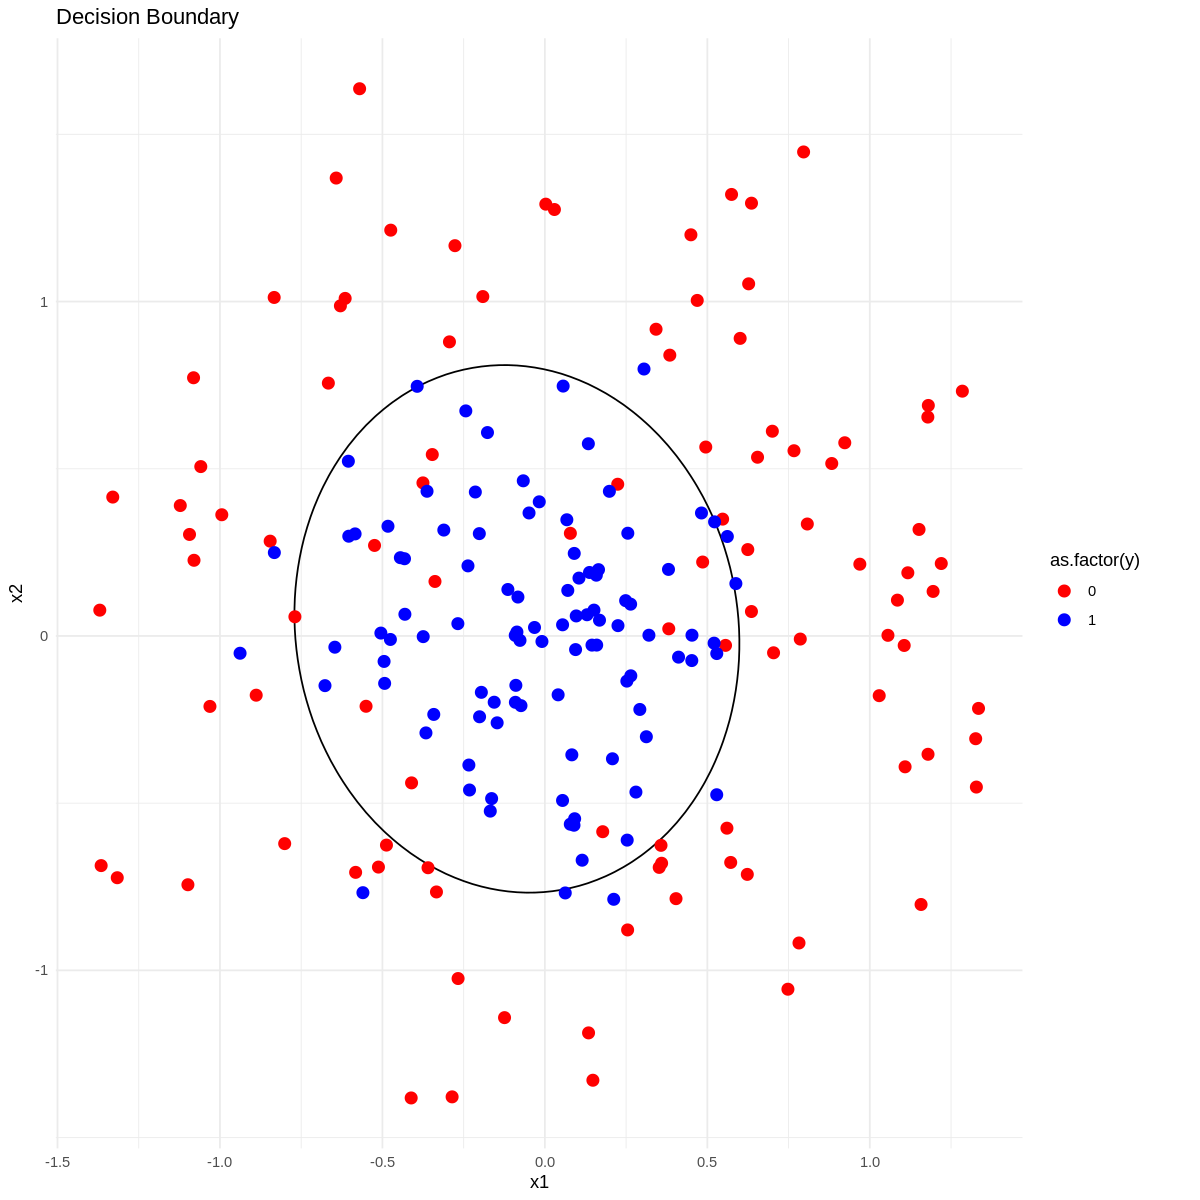

In [60]:
# Function to plot decision boundary
plot_lr_decision_boundary <- function(model, X) {
  # Create grid for predictions
  x1_vals <- seq(min(X[, 1]), max(X[, 1]), length.out = 100)
  x2_vals <- seq(min(X[, 2]), max(X[, 2]), length.out = 100)
  grid <- expand.grid(X1 = x1_vals, X2 = x2_vals)

  # Add polynomial features to the grid
  grid$X1_squared <- grid$X1^2
  grid$X2_squared <- grid$X2^2
  grid$X1_X2 <- grid$X1 * grid$X2

  # Predict probabilities on the grid
  grid$prob <- predict(model, newdata = grid, type = "response")

  # Plot decision boundary and data points
  ggplot() +
    geom_contour(data = grid, aes(x = X1, y = X2, z = prob), breaks = c(0.5), color = "black") +
    geom_point(data = data.frame(X, y = as.factor(y)), aes(x = X[, 1], y = X[, 2], color = as.factor(y)), size = 3) +
    scale_color_manual(values = c("red", "blue")) +
    labs(title = "Decision Boundary", x = "x1", y = "x2") +
    theme_minimal()
}

# Plot decision boundary
plot_lr_decision_boundary(log_reg_model, X)


In [61]:
# Summary of the logistic regression model, including coefficients
summary(log_reg_model)

# Get coefficients directly
coef(log_reg_model)


Call:
glm(formula = y ~ X1 + X2 + X1_squared + X2_squared + X1_X2, 
    family = binomial, data = X_transformed)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   3.5298     0.5067   6.966 3.27e-12 ***
X1           -1.3060     0.5606  -2.330   0.0198 *  
X2            0.1816     0.5066   0.359   0.7200    
X1_squared   -7.6765     1.3707  -5.601 2.14e-08 ***
X2_squared   -5.7832     1.0797  -5.356 8.50e-08 ***
X1_X2        -0.7430     1.3217  -0.562   0.5740    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 277.26  on 199  degrees of freedom
Residual deviance: 111.41  on 194  degrees of freedom
AIC: 123.41

Number of Fisher Scoring iterations: 7


(Intercept)          X1          X2  X1_squared  X2_squared       X1_X2 
  3.5298485  -1.3059739   0.1816350  -7.6765437  -5.7832049  -0.7430491

In [62]:
names(X_transformed)


[1] "X1_1"       "X1"         "X2"         "X1_squared" "X2_squared"
[6] "X1_X2"

In [63]:
# Get the coefficients of the logistic regression model
coef(log_reg_model)
#We have to drop X1_1, which is where the 1 values are, since it gives us a null value

(Intercept)          X1          X2  X1_squared  X2_squared       X1_X2 
  3.5298485  -1.3059739   0.1816350  -7.6765437  -5.7832049  -0.7430491

Some more example synthetic datasets

In [64]:
xor_data <- create_xor_dataset(200)
X <- xor_data$X
y <- xor_data$y

In [65]:
X_df <- as.data.frame(X)
colnames(X_df) <- c("x1","x2")

In [66]:
X_transformed <- data.frame(
  X1_1 = 1,
  X1 = X_df$x1,
  X2 = X_df$x2,
  X1_squared = X_df$x1^2,
  X2_squared = X_df$x2^2,
  X1_X2 = X_df$x1 * X_df$x2
)
# Fit a logistic regression model with polynomial features
log_reg_model <- glm(y ~ X1_1 + X1 + X2 + X1_squared + X2_squared + X1_X2,
                     data = X_transformed, family = binomial)

summary(log_reg_model)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = y ~ X1_1 + X1 + X2 + X1_squared + X2_squared + 
    X1_X2, family = binomial, data = X_transformed)

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)
(Intercept)     -8.829    404.180  -0.022    0.983
X1_1                NA         NA      NA       NA
X1             -89.626  35902.425  -0.002    0.998
X2              62.291   2183.745   0.029    0.977
X1_squared      56.928  53740.908   0.001    0.999
X2_squared      80.624   2457.102   0.033    0.974
X1_X2        -5232.627 128885.827  -0.041    0.968

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2.7724e+02  on 199  degrees of freedom
Residual deviance: 6.2898e-06  on 194  degrees of freedom
AIC: 12

Number of Fisher Scoring iterations: 25


In [67]:
#drop X1_1, which is the 1 value
log_reg_model <- glm(y ~ X1 + X2 + X1_squared + X2_squared + X1_X2,
                     data = X_transformed, family = binomial)

summary(log_reg_model)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = y ~ X1 + X2 + X1_squared + X2_squared + X1_X2, 
    family = binomial, data = X_transformed)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)     -8.829    404.180  -0.022    0.983
X1             -89.626  35902.425  -0.002    0.998
X2              62.291   2183.745   0.029    0.977
X1_squared      56.928  53740.908   0.001    0.999
X2_squared      80.624   2457.102   0.033    0.974
X1_X2        -5232.627 128885.827  -0.041    0.968

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2.7724e+02  on 199  degrees of freedom
Residual deviance: 6.2898e-06  on 194  degrees of freedom
AIC: 12

Number of Fisher Scoring iterations: 25


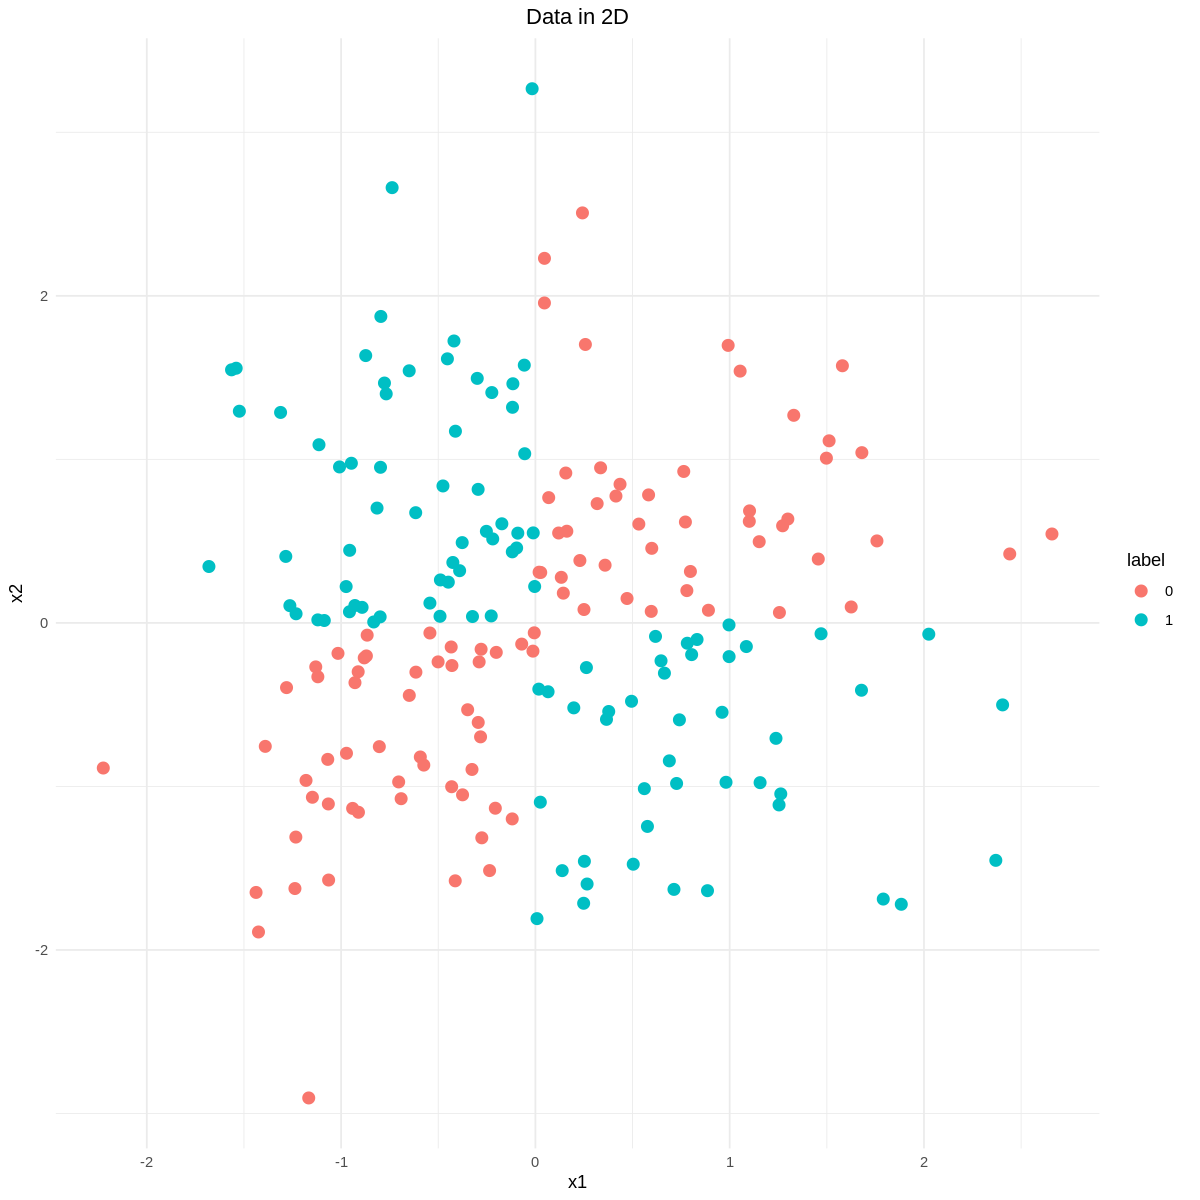

In [68]:
fig = visualize_2d(X,y)
fig

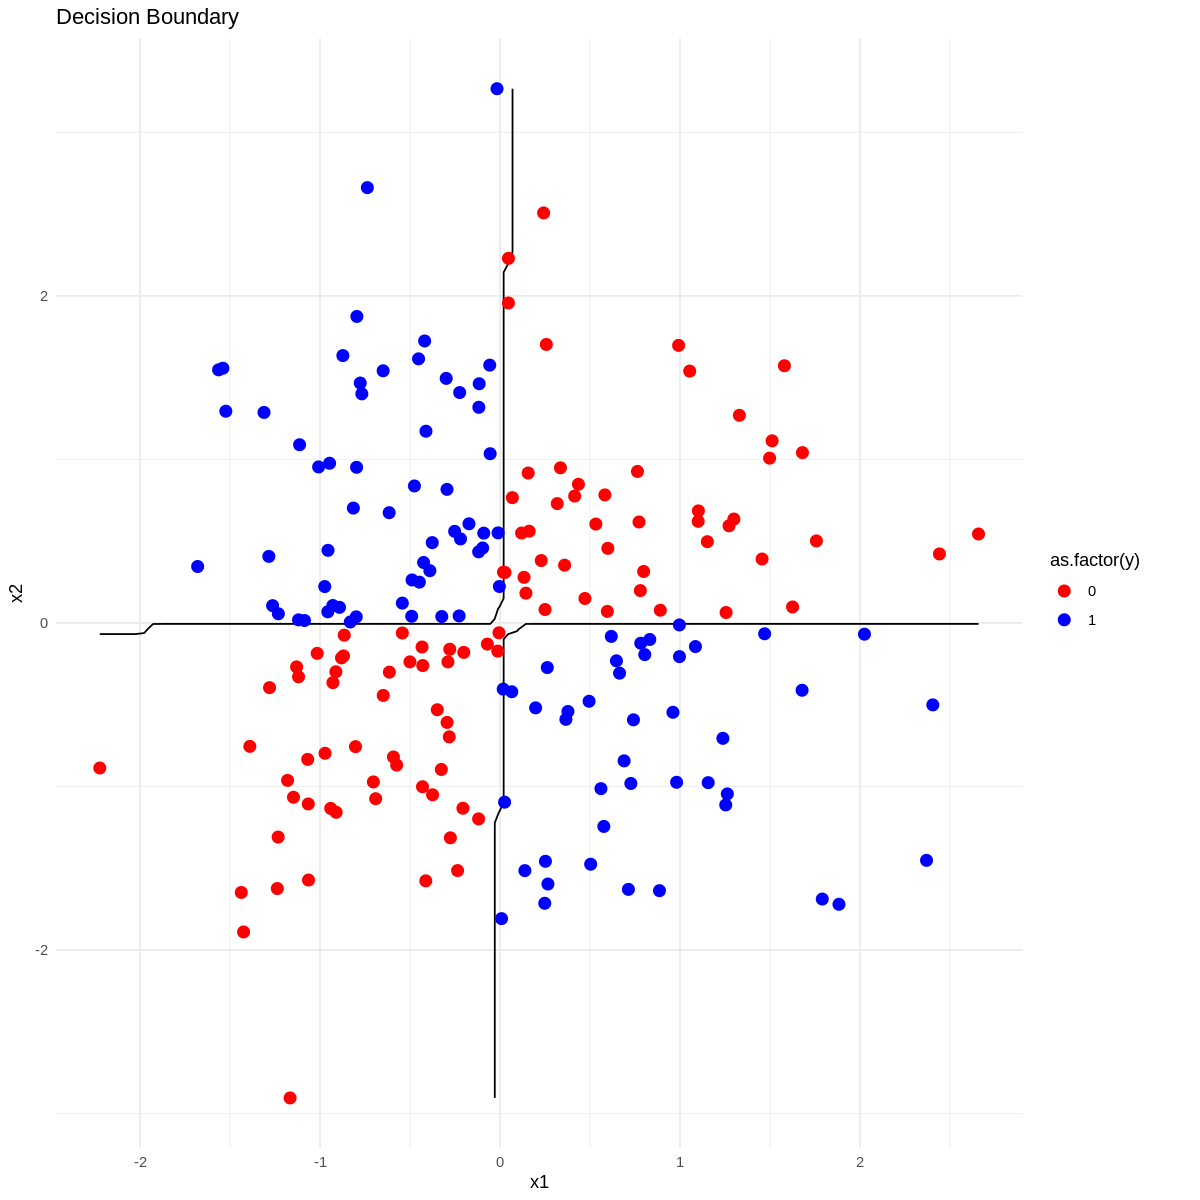

In [69]:
plot_lr_decision_boundary(log_reg_model,X)

In [70]:
names(X_transformed)

[1] "X1_1"       "X1"         "X2"         "X1_squared" "X2_squared"
[6] "X1_X2"

In [71]:
coef(log_reg_model)

(Intercept)           X1           X2   X1_squared   X2_squared        X1_X2 
   -8.828895   -89.626496    62.291114    56.927528    80.624385 -5232.626704

#### **Avoiding overfitting with polynomial transformations**

We demonstrated how polynomial features allow linear models to build nonlinear separating surfaces. Let's now show this visually.

Let's see how regularization affects the quality of classification on a dataset on microchip testing from Andrew Ng's course on machine learning. We will use logistic regression with polynomial features and vary the regularization parameter $C$. First, we will see how regularization affects the separating border of the classifier and intuitively recognize under- and overfitting.

In [72]:
# Load necessary libraries
library(readr)

# Download the data
url <- "https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/ML_Concepts/microchip_tests.txt"
#"https://media.githubusercontent.com/media/ICBI/AIMAHEAD_GU_publicCourseData/refs/heads/main/ML_Concepts/microchip_tests.txt"
download.file(url, destfile = "microchip_tests.txt")

# Read the data
data <- read_csv("microchip_tests.txt", col_names = c("test1", "test2", "released"))


Rows: 118 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): test1, test2, released

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [73]:
head(data)

test1,test2,released
<dbl>,<dbl>,<dbl>
0.051267,0.69956,1
-0.092742,0.68494,1
-0.213710,0.69225,1
-0.375000,0.50219,1
-0.513250,0.46564,1
-0.524770,0.20980,1


In [74]:
dim(data)

[1] 118   3

In [75]:
# Counting occurrences in 'released' column
table(data$released)




 0  1 
60 58 

In [76]:
# Extracting 'test1' and 'test2' as matrix (equivalent to X)
X <- as.matrix(data[, c("test1", "test2")])

# Extracting 'released' as a vector (equivalent to y)
y <- data$released

In [77]:
dim(X)
length(y)

[1] 118   2

[1] 118

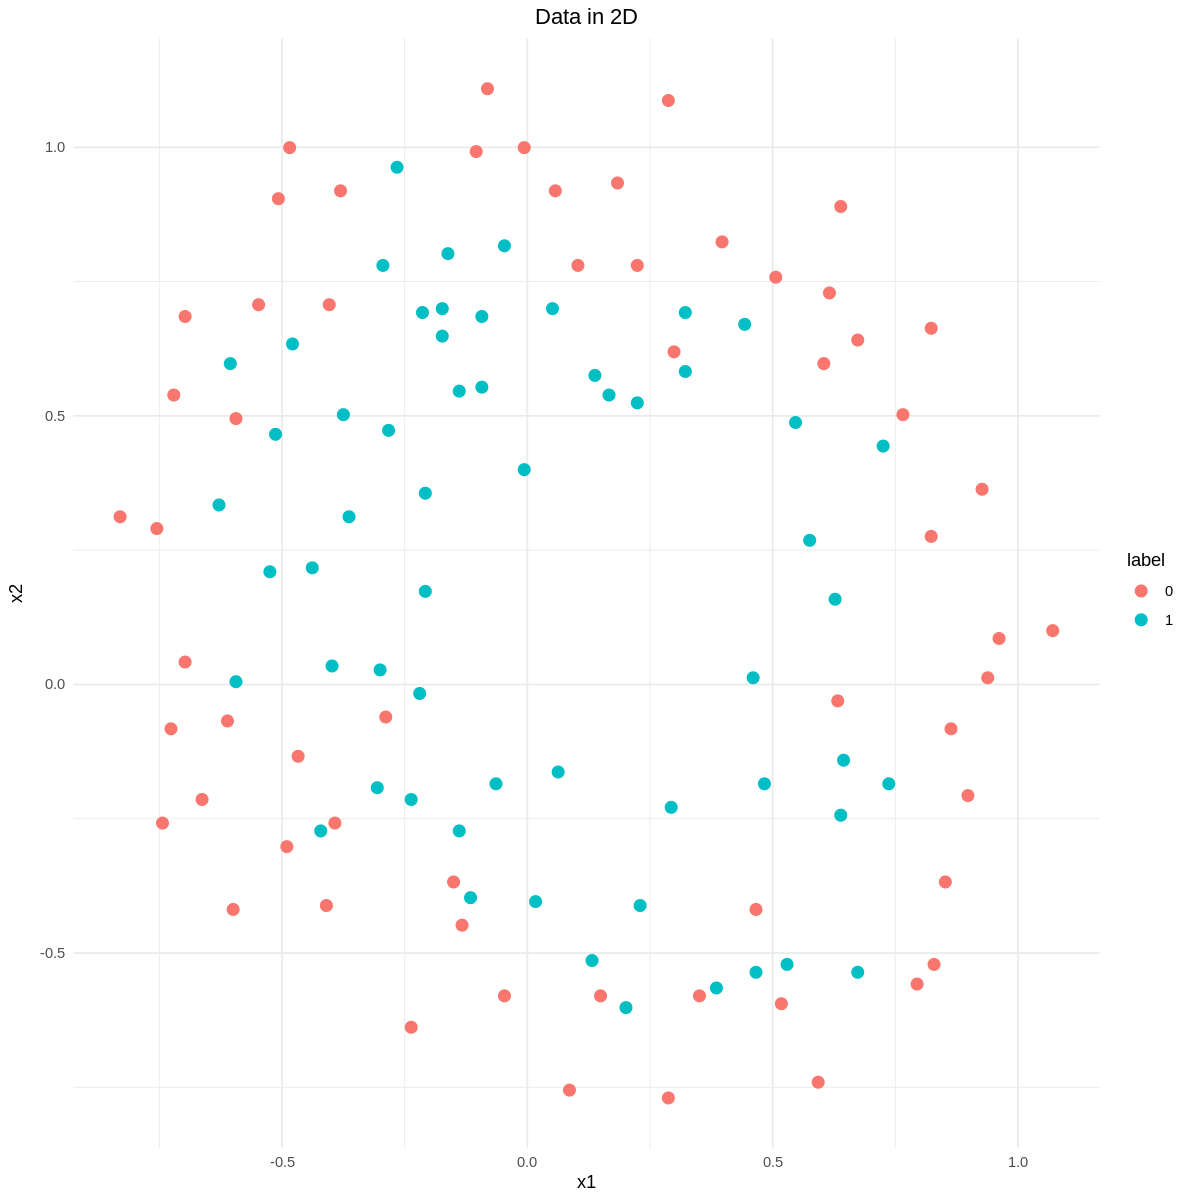

In [78]:
fig <- visualize_2d(X, y)
fig

Let's train logistic regression with regularization parameter $C = 10^{-2}$.

In [79]:

install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’




In [80]:
# Load necessary libraries
library(glmnet)
library(ggplot2)

# Function to create polynomial features
create_polynomial_features <- function(X, degree) {
  n <- nrow(X)
  poly_features <- do.call(cbind, lapply(0:degree, function(d) {
    if (d == 0) return(rep(1, n))  # Intercept term
    if (d == 1) return(X)  # Linear terms
    return(sapply(1:ncol(X), function(i) X[, i]^d))
  }))

  # Adding interaction terms
  if (degree > 1) {
    for (i in 1:ncol(X)) {
      for (j in i:ncol(X)) {
        if (i != j) {
          poly_features <- cbind(poly_features, X[, i] * X[, j])
        }
      }
    }
  }

  return(poly_features)
}

# Prepare X and y
X <- as.matrix(data[, 1:2])  # Only using the features
y <- as.factor(data$released)  # Target variable

# Create polynomial features of degree 7
X_transformed <- create_polynomial_features(X, 7)

# Fit the logistic regression model
log_reg_model <- glmnet(X_transformed, as.numeric(y) - 1, family = "binomial", alpha = 0, lambda = 1e-2)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-10



In [81]:
# Create a grid for prediction
x1_range <- seq(min(X[, 1]), max(X[, 1]), length.out = 100)
x2_range <- seq(min(X[, 2]), max(X[, 2]), length.out = 100)
grid <- expand.grid(test1 = x1_range, test2 = x2_range)  # Ensure correct column names

# Create polynomial features for the grid
grid_transformed <- create_polynomial_features(as.matrix(grid), 7)

# Predict probabilities using the model
grid$prob <- predict(log_reg_model, newx = grid_transformed, type = "response")

# Create a base plot
plot <- ggplot(data, aes(x = test1, y = test2, color = released)) +
  geom_point(size = 3, alpha = 0.6) +
  labs(color = "True Label") +
  theme_minimal()


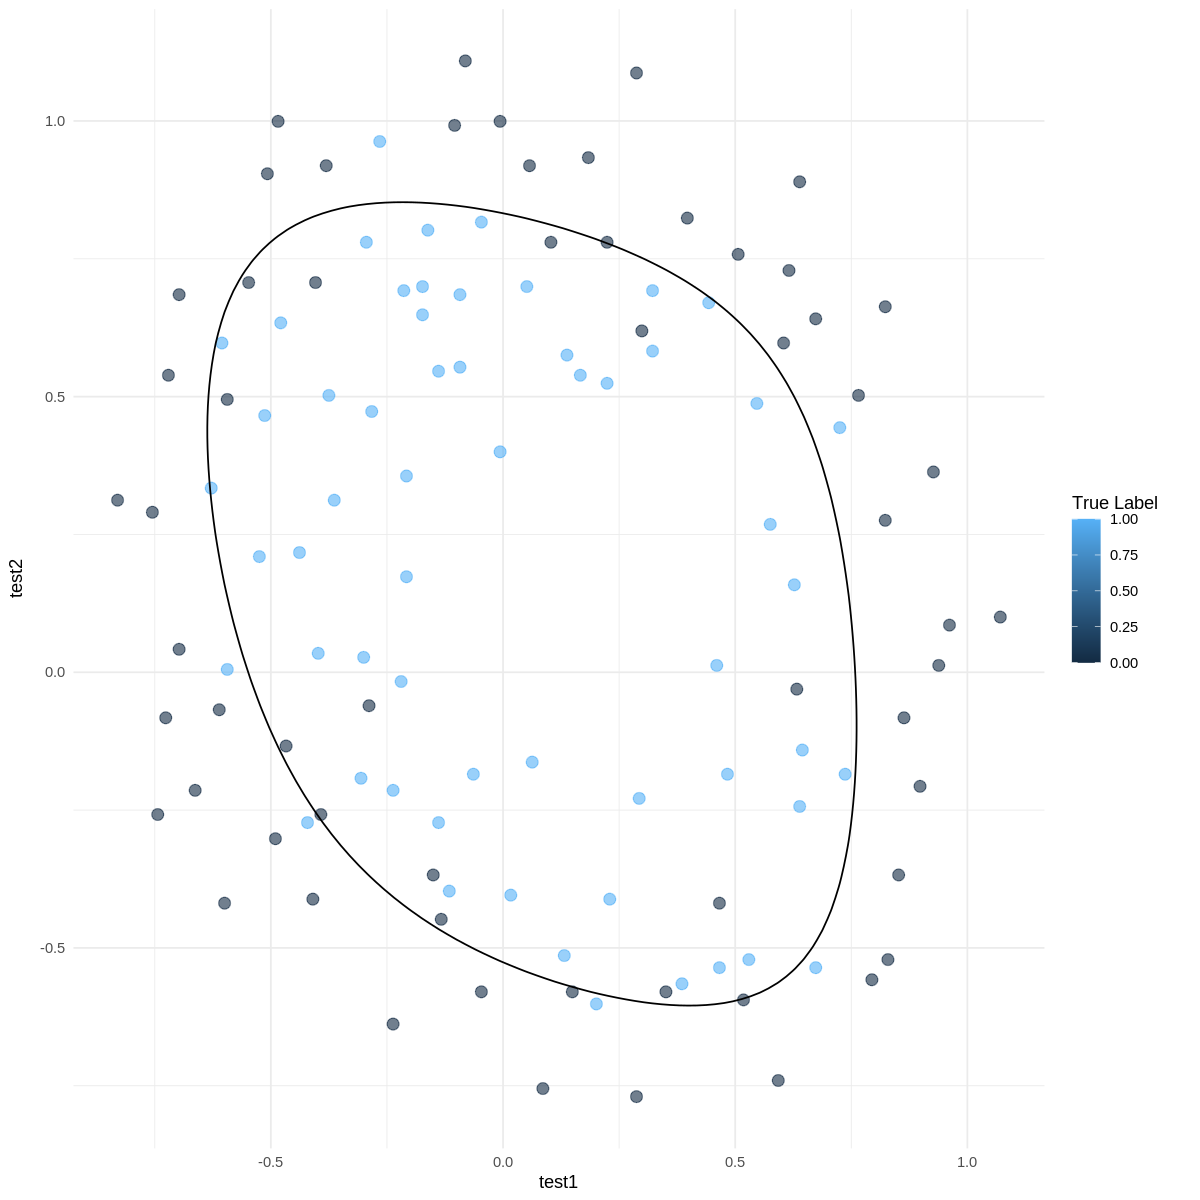

In [82]:
# Add the decision boundary using contour plot
plot <- plot +
  geom_contour(data = grid, aes(z = prob), breaks = 0.5, color = "black")

# Show the plot
print(plot)


In [83]:
get_training_results <- function(model, X, y) {

# Predictions
  y_pred <- predict(model, X, type = "response")  # Use type = "response" for probabilities
  y_pred_classes <- ifelse(y_pred > 0.5, 1, 0)  # Convert probabilities to class labels

  # Print confusion matrix
  y_levels <- unique(c(y, y_pred_classes))  # Ensure levels are consistent
  y_pred_factor <- factor(y_pred_classes, levels = y_levels)
  y_factor <- factor(y, levels = y_levels)
  # Print classification report
  confusion_matrix <- confusionMatrix(y_pred_factor, y_factor)
  print(confusion_matrix)
}

# Using the function on the logistic regression pipeline
get_training_results(log_reg_model, X_transformed, y)


Confusion Matrix and Statistics

          Reference
Prediction  2  1  0
         2  0  0  0
         1  0 52 13
         0  0  6 47

Overall Statistics
                                        
               Accuracy : 0.839         
                 95% CI : (0.76, 0.9002)
    No Information Rate : 0.5085        
    P-Value [Acc > NIR] : 5.876e-14     
                                        
                  Kappa : 0.6785        
                                        
 Mcnemar's Test P-Value : NA            

Statistics by Class:

                     Class: 2 Class: 1 Class: 0
Sensitivity                NA   0.8966   0.7833
Specificity                 1   0.7833   0.8966
Pos Pred Value             NA   0.8000   0.8868
Neg Pred Value             NA   0.8868   0.8000
Prevalence                  0   0.4915   0.5085
Detection Rate              0   0.4407   0.3983
Detection Prevalence        0   0.5508   0.4492
Balanced Accuracy          NA   0.8399   0.8399


In [84]:
y_pred <- predict(log_reg_model, X_transformed, type = "response")  # Use type = "response" for probabilities
y_pred_classes <- ifelse(y_pred > 0.5, 1, 0)  # Convert probabilities to class labels
accuracy <- sum(y_pred_classes == y) / length(y)
cat("Accuracy on training set:", round(accuracy, 3), "\n")

Accuracy on training set: 0.839 


We could now try increasing $C$ to 1. In doing this, we weaken regularization, and the solution can now have greater values (in absolute value) of model weights than previously. Now the accuracy of the classifier on the training set improves.

Accuracy on training set: 0.763 


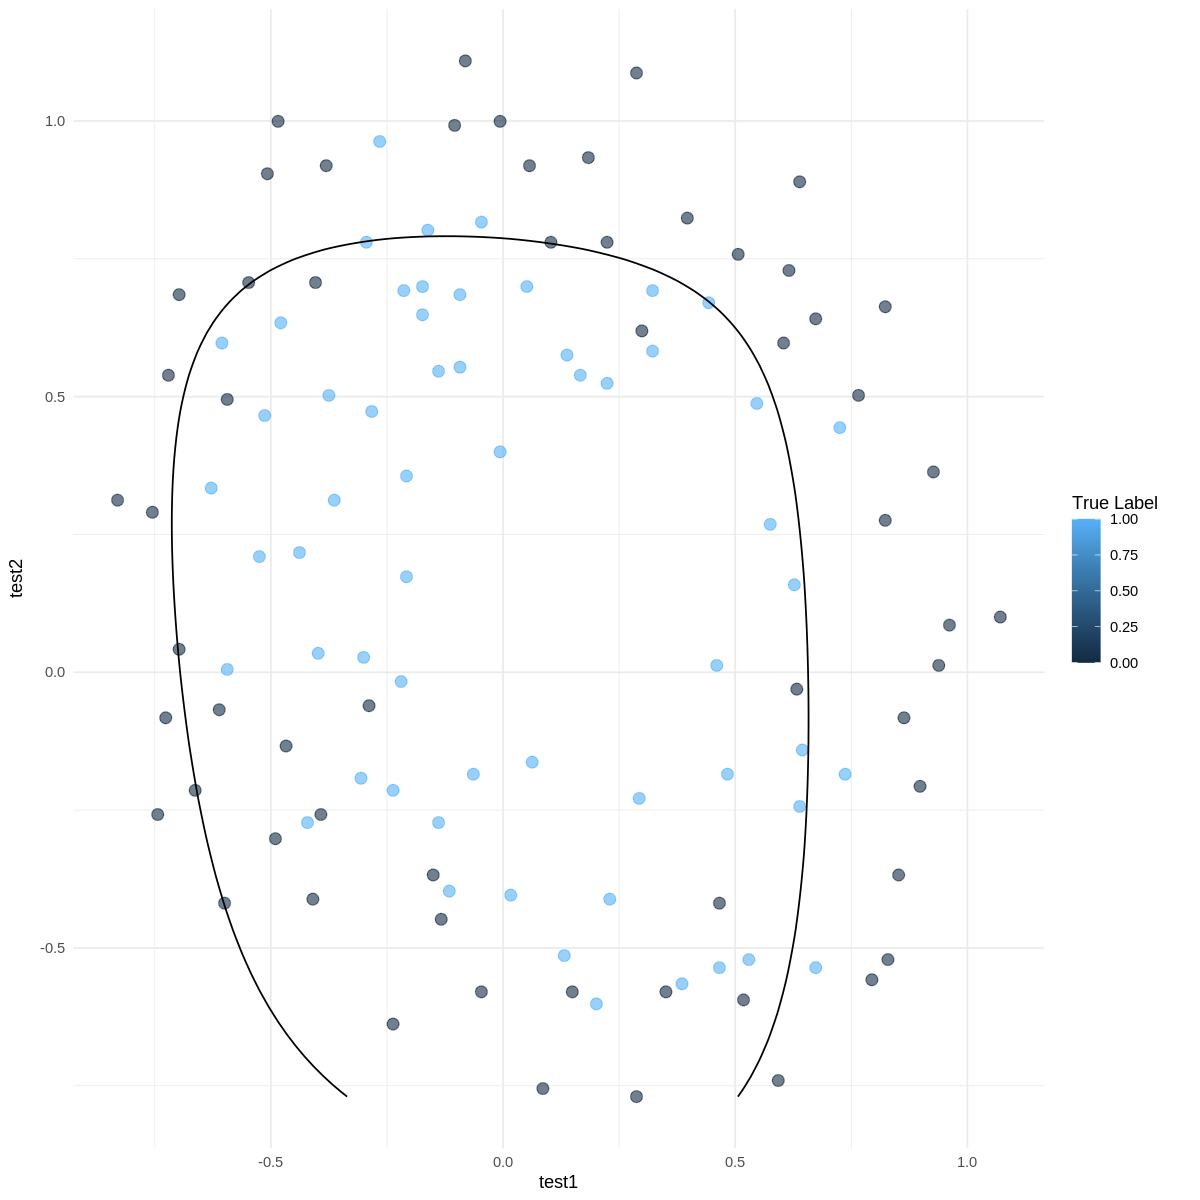

In [85]:
# Fit the logistic regression model
log_reg_model <- glmnet(X_transformed, as.numeric(y) - 1, family = "binomial", alpha = 0, lambda = 1)

y_pred <- predict(log_reg_model, X_transformed, type = "response")  # Use type = "response" for probabilities
y_pred_classes <- ifelse(y_pred > 0.5, 1, 0)  # Convert probabilities to class labels
accuracy <- sum(y_pred_classes == y) / length(y)
cat("Accuracy on training set:", round(accuracy, 3), "\n")
# Create a grid for prediction
x1_range <- seq(min(X[, 1]), max(X[, 1]), length.out = 100)
x2_range <- seq(min(X[, 2]), max(X[, 2]), length.out = 100)
grid <- expand.grid(test1 = x1_range, test2 = x2_range)  # Ensure correct column names

# Create polynomial features for the grid
grid_transformed <- create_polynomial_features(as.matrix(grid), 7)

# Predict probabilities using the model
grid$prob <- predict(log_reg_model, newx = grid_transformed, type = "response")

# Create a base plot
plot <- ggplot(data, aes(x = test1, y = test2, color = released)) +
  geom_point(size = 3, alpha = 0.6) +
  labs(color = "True Label") +
  theme_minimal()

# Add the decision boundary using contour plot
plot <- plot +
  geom_contour(data = grid, aes(z = prob), breaks = 0.5, color = "black")

# Show the plot
print(plot)

Then, why don't we increase $C$ even more - up to 10,000? Now, regularization is clearly not strong enough, and we see overfitting. Note that, with $C$=1 and a "smooth" boundary, the share of correct answers on the training set is not much lower than here. But one can easily imagine how our second model will work much better on new data.

In [86]:

# Fit logistic regression with regularization (equivalent to `C = 1e3`)
lambda <- 1 / 1e3 # In glmnet, lambda is the inverse of C
log_reg_model <- glmnet(X_transformed, y, family = "binomial", lambda = lambda)

# Make predictions
y_pred <- predict(log_reg_model, newx = X_transformed, type = "response")

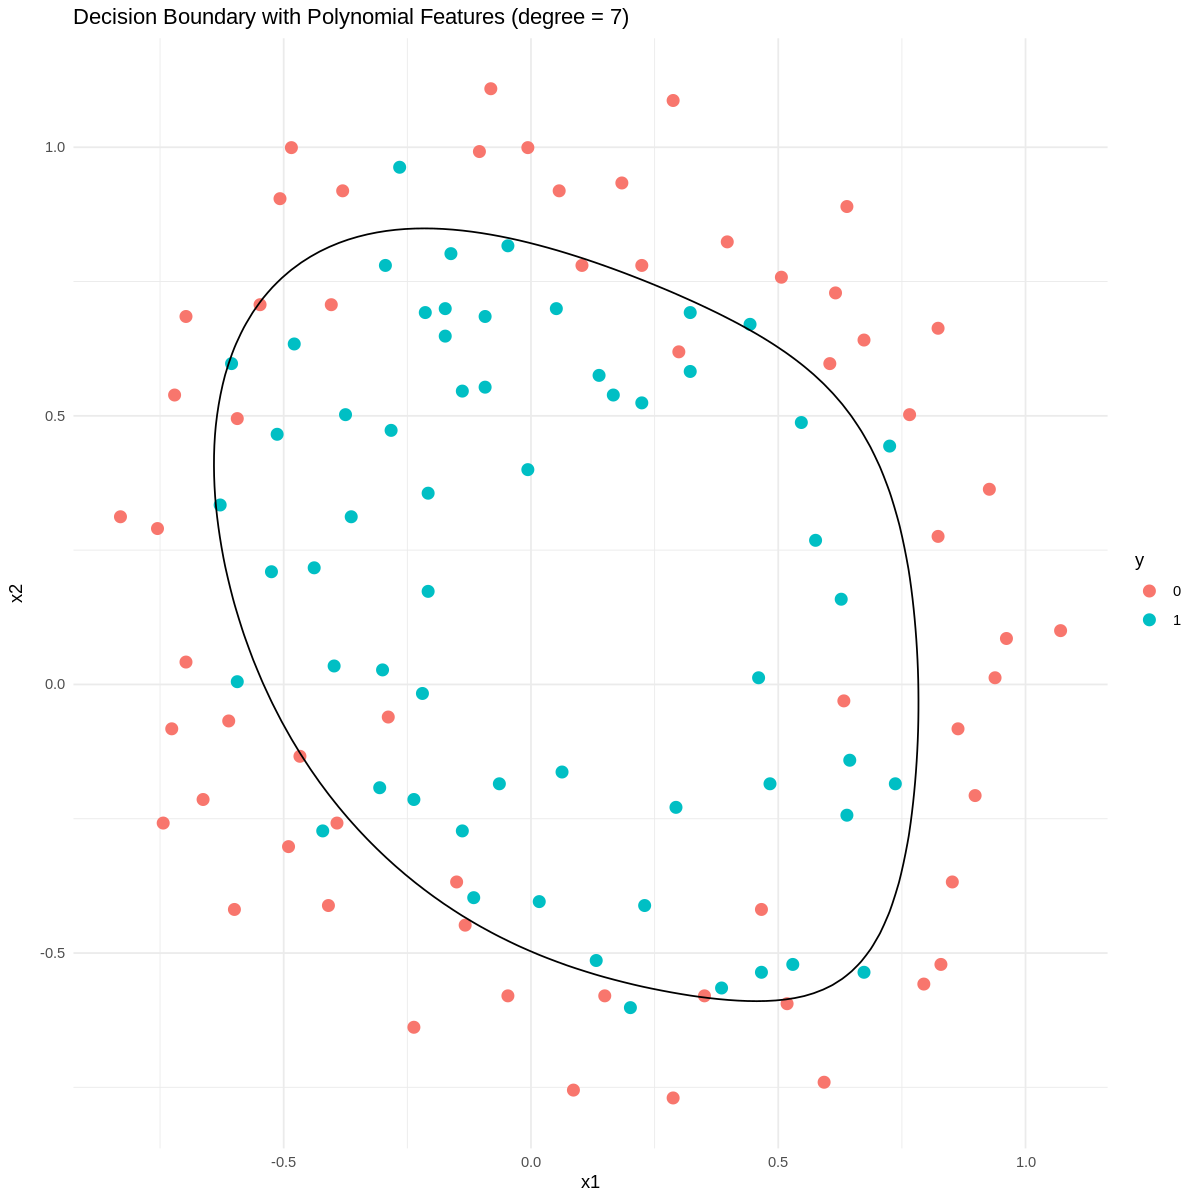

In [87]:
visualize_2d_decisionboundary <- function(X, y, model, degree) {
  # Convert X to data frame
  X_df <- data.frame(x1 = X[,1], x2 = X[,2], y = as.factor(y))

  # Create a grid of values to predict
  grid <- expand.grid(x1 = seq(min(X[,1]), max(X[,1]), length.out = 100),
                      x2 = seq(min(X[,2]), max(X[,2]), length.out = 100))

  # Add polynomial features for the grid points
  grid_poly <- create_polynomial_features(as.matrix(grid), 7)

  # Get decision boundary by predicting probabilities
  grid$prob <- predict(model, newx = grid_poly, type = "response")

  # Plot the data points
  p <- ggplot(X_df, aes(x = x1, y = x2, color = y)) +
    geom_point(size = 3) +
    geom_contour(data = grid, aes(z = prob), breaks = 0.5, color = "black") +
    ggtitle("Decision Boundary with Polynomial Features (degree = 7)")

  print(p)
}

# Visualize the decision boundary
visualize_2d_decisionboundary(X, y, log_reg_model, degree = 7)

In [88]:
y_pred <- predict(log_reg_model, X_transformed, type = "response")  # Use type = "response" for probabilities
y_pred_classes <- ifelse(y_pred > 0.5, 1, 0)  # Convert probabilities to class labels
accuracy <- sum(y_pred_classes == y) / length(y)
cat("Accuracy on training set:", round(accuracy, 3), "\n")

Accuracy on training set: 0.856 


To discuss the results, let's rewrite the function that is optimized in logistic regression with the form:

$$\large J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

where

- $\mathcal{L}$ is the logistic loss function summed over the entire dataset
- $C$ is the reverse regularization coefficient (the very same $C$ from `sklearn`'s implementation of `LogisticRegression`)

Questions?

the larger the parameter $C$, the more complex the relationships in the data that the model can recover (intuitively $C$ corresponds to the "complexity" of the model - model capacity)
- if regularization is too strong i.e. the values of $C$ are small, the solution to the problem of minimizing the logistic loss function may be the one where many of the weights are too small or zeroed. The model is also not sufficiently "penalized" for errors (i.e. in the function $J$, the sum of the squares of the weights "outweighs", and the error $\mathcal{L}$ can be relatively large). In this case, the model will underfit as we saw in our first case.
- on the contrary, if regularization is too weak i.e. the values of $C$ are large, a vector $w$ with high absolute value components can become the solution to the optimization problem. In this case, $\mathcal{L}$ has a greater contribution to the optimized functional $J$. Loosely speaking, the model is too "afraid" to be mistaken on the objects from the training set and will therefore overfit as we saw in the third case.
- logistic regression will not "understand" (or "learn") what value of $C$ to choose as it does with the weights $w$. That is to say, it can not be determined by solving the optimization problem in logistic regression. We have seen a similar situation before -- a decision tree can not "learn" what depth limit to choose during the training process. Therefore, $C$ is the a model hyperparameter that is tuned on cross-validation; so is the max_depth in a tree.

Demo: https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/playground-exercise-examining-l2-regularization

#### **Another linear classifier: Support Vector Machines (SVM): Recap**

Generate Linearly seperable data

In [89]:
set.seed(0)
blobs <- make_blobs(n_samples = 50, n_features = 2, centers = 2, cluster_std = 0.60)
X <- blobs$X
y <- blobs$labels


A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:


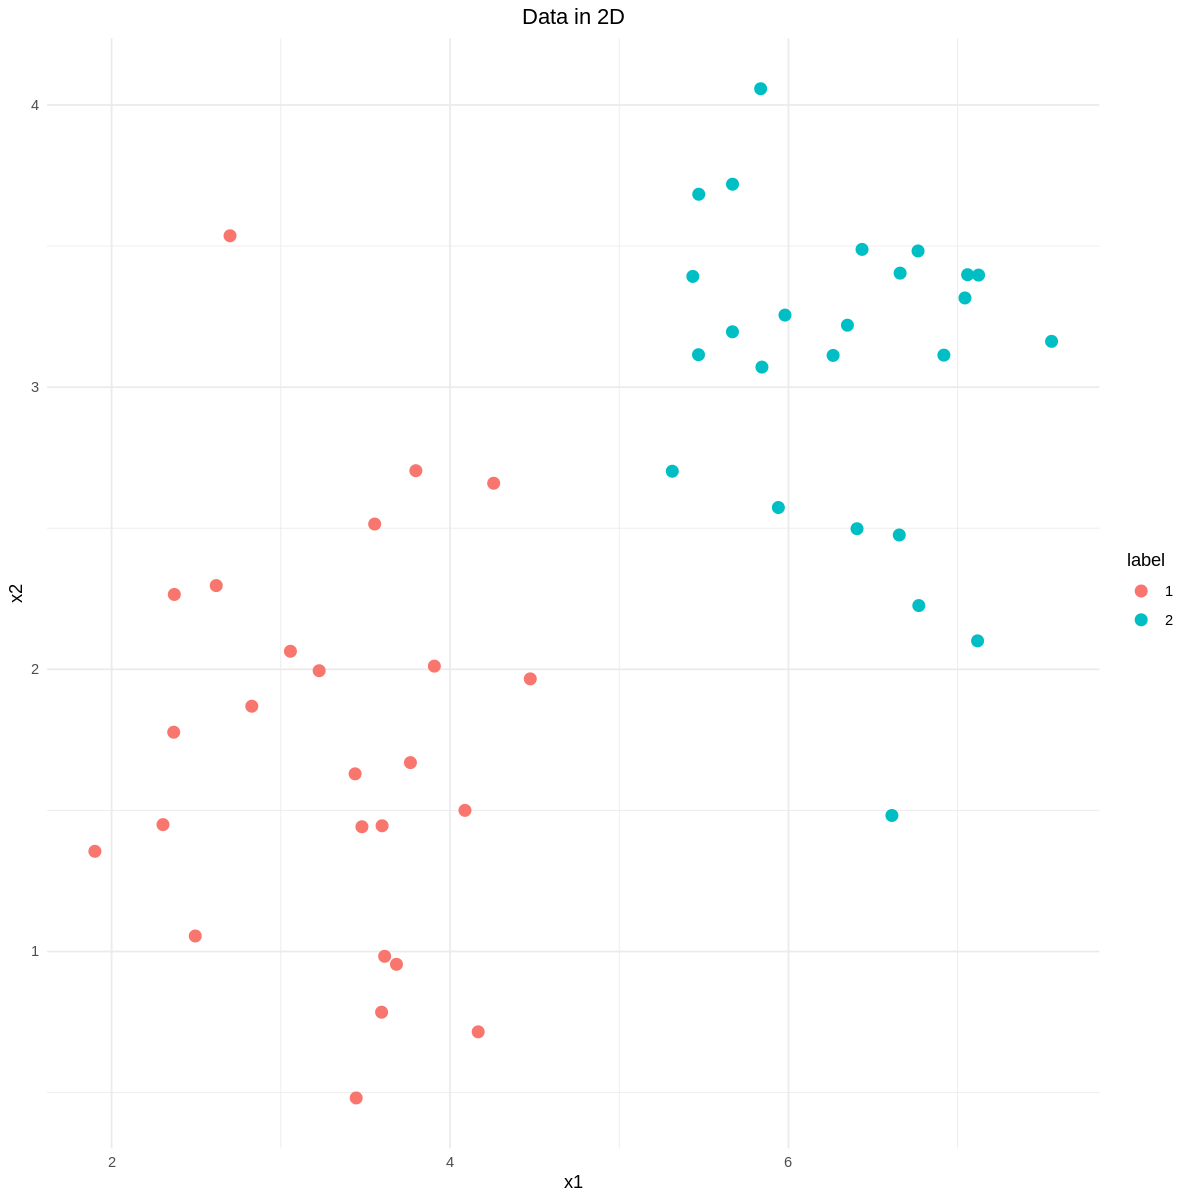

In [90]:
visualize_2d <- function(X, y, title = "Data in 2D") {

  # Convert to a data frame
  df <- data.frame(X1 = X[, 1], X2 = X[, 2], label = as.factor(y))

  # Create the plot
  plot <- ggplot(df, aes(x = X1, y = X2, color = label)) +
    geom_point(size = 3) +
    labs(title = title, x = "x1", y = "x2") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5))

  return(plot)  # Return the ggplot object (equivalent to fig in Python)
}

visualize_2d(X,y)

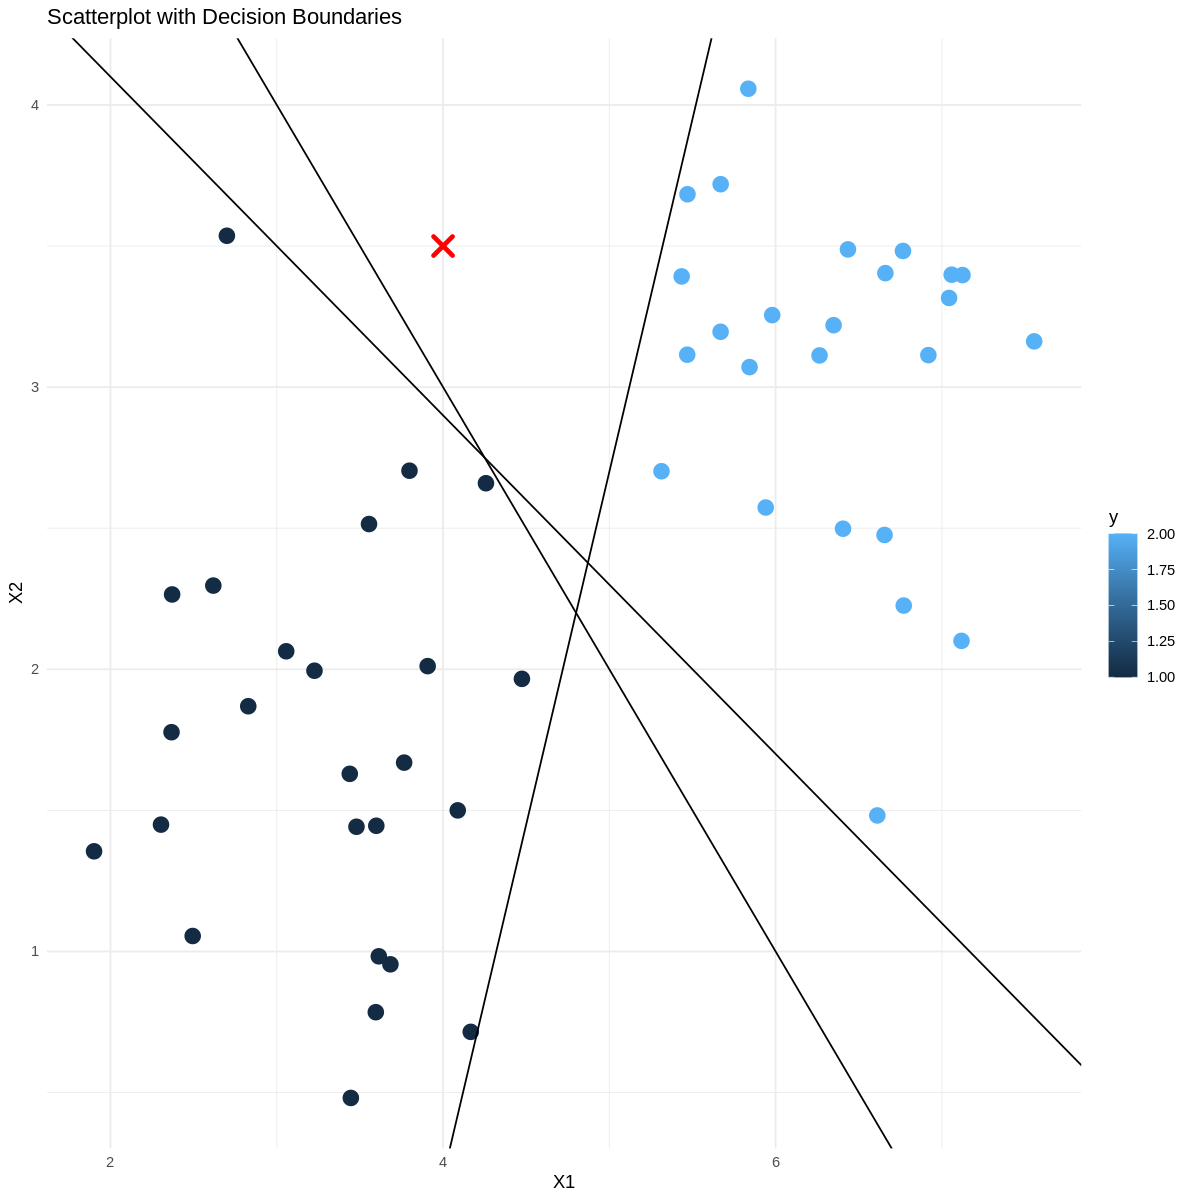

In [91]:
# Combine into a dataframe
X_df <- data.frame(X1 = X[,1], X2 = X[,2], y = y)

ggplot(X_df, aes(x = X1, y = X2, color = y)) +
  geom_point(size = 4) +
  annotate("point", x = 4, y = 3.5, color = "red", shape = 4, size = 4, stroke = 2) +
  geom_abline(slope = -1, intercept = 7, color = "black") +
  geom_abline(slope = 2.5, intercept = -9.8, color = "black") +
  geom_abline(slope = -0.6, intercept = 5.3, color = "black") +
  labs(title = "Scatterplot with Decision Boundaries", x = "X1", y = "X2") +
  theme_minimal()

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

**SVM: Maximizing the Margin**

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

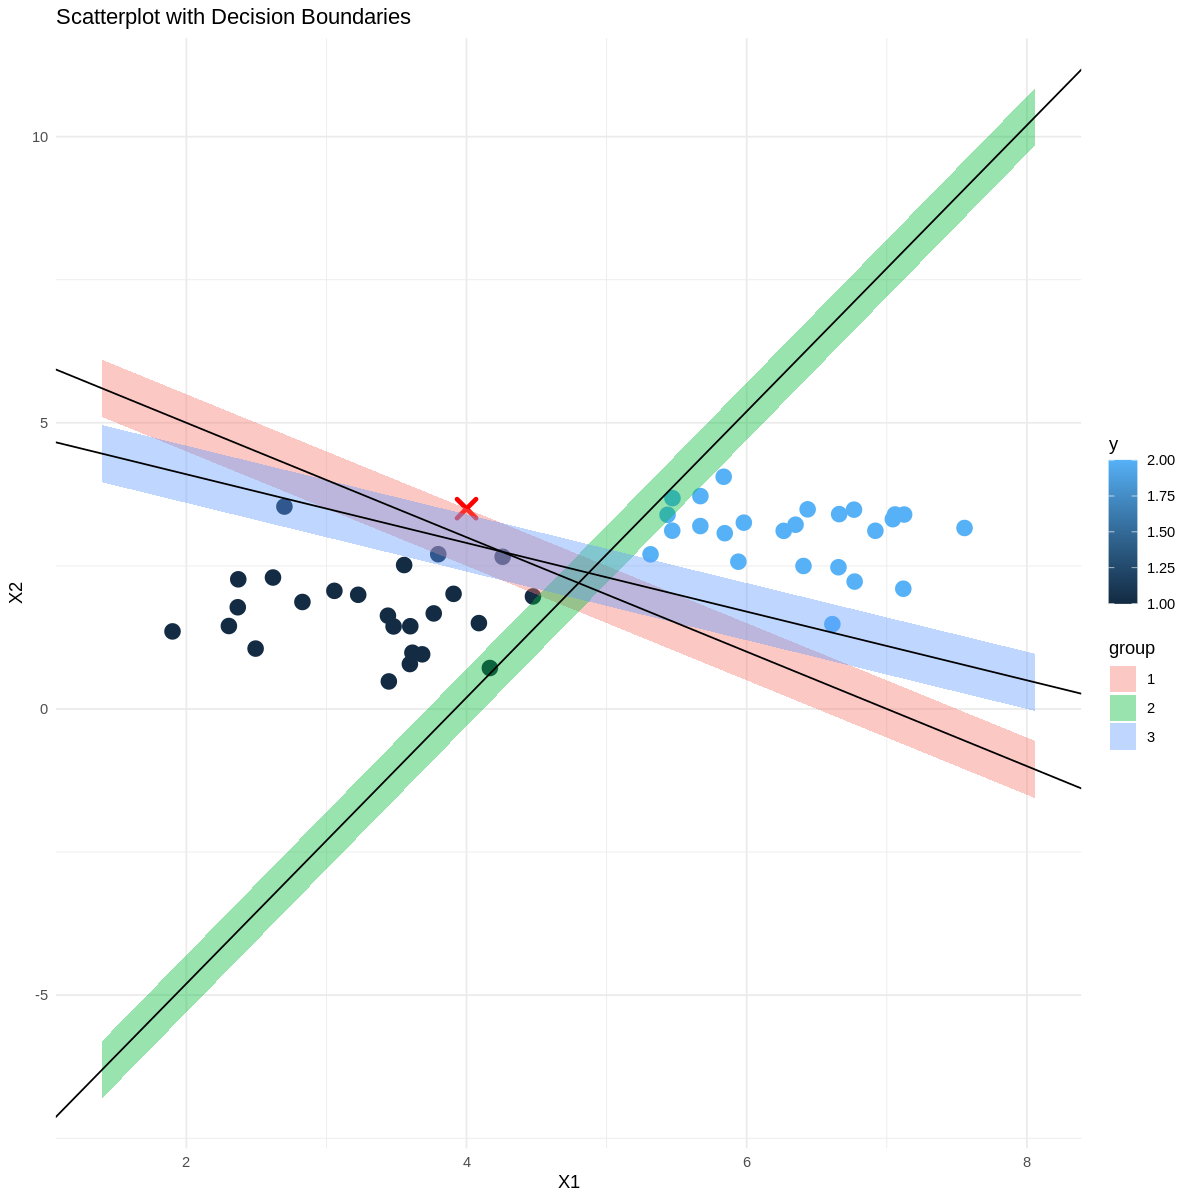

In [92]:
# Define x values for decision boundaries
x_vals <- seq(min(X_df$X1) - 0.5, max(X_df$X1) + 0.5, length.out = 100)

# Create data for the boundary ribbons
ribbon_data <- data.frame(
  x = rep(x_vals, 3),
  ymin = c(-1 * x_vals + 7 - 0.5, 2.5 * x_vals - 9.8 - 0.5, -0.6 * x_vals + 5.3 - 0.5),
  ymax = c(-1 * x_vals + 7 + 0.5, 2.5 * x_vals - 9.8 + 0.5, -0.6 * x_vals + 5.3 + 0.5),
  group = factor(rep(1:3, each = length(x_vals)))  # Group for the ribbons
)

p <- ggplot(X_df, aes(x = X[,1], y = X[,2], color = y)) +
  geom_point(size = 4) +  # Scatter plot
  annotate("point", x = 4, y = 3.5, color = "red", shape = 4, size = 4, stroke = 2) +
  # Add shaded areas
  geom_ribbon(data = ribbon_data, aes(x = x, ymin = ymin, ymax = ymax, fill = group),
              inherit.aes = FALSE, alpha = 0.4) +
  # Add decision boundary lines and shaded areas
  geom_abline(slope = -1, intercept = 7, color = "black") +
  #geom_ribbon(data = data.frame(x = c(-1, 3.5)), aes(x = x, ymin = -1 * x + 7 - 0.33, ymax = -1 * x + 7 + 0.33), fill = "#AAAAAA", alpha = 0.4) +

  geom_abline(slope = 2.5, intercept = -9.8, color = "black") +
  #geom_ribbon(data = data.frame(x = c(-1, 3.5)), aes(x = x, ymin = 2.5 * x - 9.8 - 0.55, ymax = 2.5 * x - 9.8 + 0.55), fill = "#AAAAAA", alpha = 0.4) +

  geom_abline(slope = -0.6, intercept = 5.3, color = "black") +
  #geom_ribbon(data = data.frame(x = c(-1, 3.5)), aes(x = x, ymin = -0.6 * x + 5.3 - 0.2, ymax = -0.6 * x + 5.3 + 0.2), fill = "#AAAAAA", alpha = 0.4) +

  labs(title = "Scatterplot with Decision Boundaries", x = "X1", y = "X2") +
  theme_minimal()

# Show the plot
print(p)

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

Fit a SVM

In [93]:
# Create the SVM model
svm_model <- svm(as.factor(y) ~ X1 + X2, data = X_df, kernel = "linear", scale = FALSE)

Visualize the decision boundry with support vectors



In [94]:
library(e1071)

In [95]:
# Function to plot decision function and margins
plot_svc_decision_function <- function(svm_model, X_df) {
  # Create a grid of values for X1 and X2
  xlim <- range(X_df$X1)
  ylim <- range(X_df$X2)
  x_vals <- seq(xlim[1], xlim[2], length.out = 100)
  y_vals <- seq(ylim[1], ylim[2], length.out = 100)
  grid <- expand.grid(X1 = x_vals, X2 = y_vals)

  # Predict decision function on the grid
  decision_values <- predict(svm_model, grid, decision.values = TRUE)
  decision_matrix <- attributes(decision_values)$decision

  # Add decision values to the grid
  grid$decision <- decision_matrix

  # Create the ggplot
  p <- ggplot(X_df, aes(x = X1, y = X2, color = as.factor(y))) +
    geom_point(size = 4) +

    # Add decision boundary and margins
    stat_contour(data = grid, aes(x = X1, y = X2, z = decision),
                 breaks = c(-1, 0, 1),
                 color = "black", linetype = "dashed") +  # Use single linetype

   stat_contour(data = grid, aes(x = X1, y = X2, z = decision), breaks = c(0),
                 color = "black", linetype = "solid") +

    # Plot the support vectors
    geom_point(data = data.frame(svm_model$SV), aes(x = X1, y = X2), shape = 21, size = 5, stroke = 1.5, color = "blue", fill = NA) +

    labs(title = "SVM Decision Boundary and Margins", x = "X1", y = "X2") +
    theme_minimal()

  print(p)
}


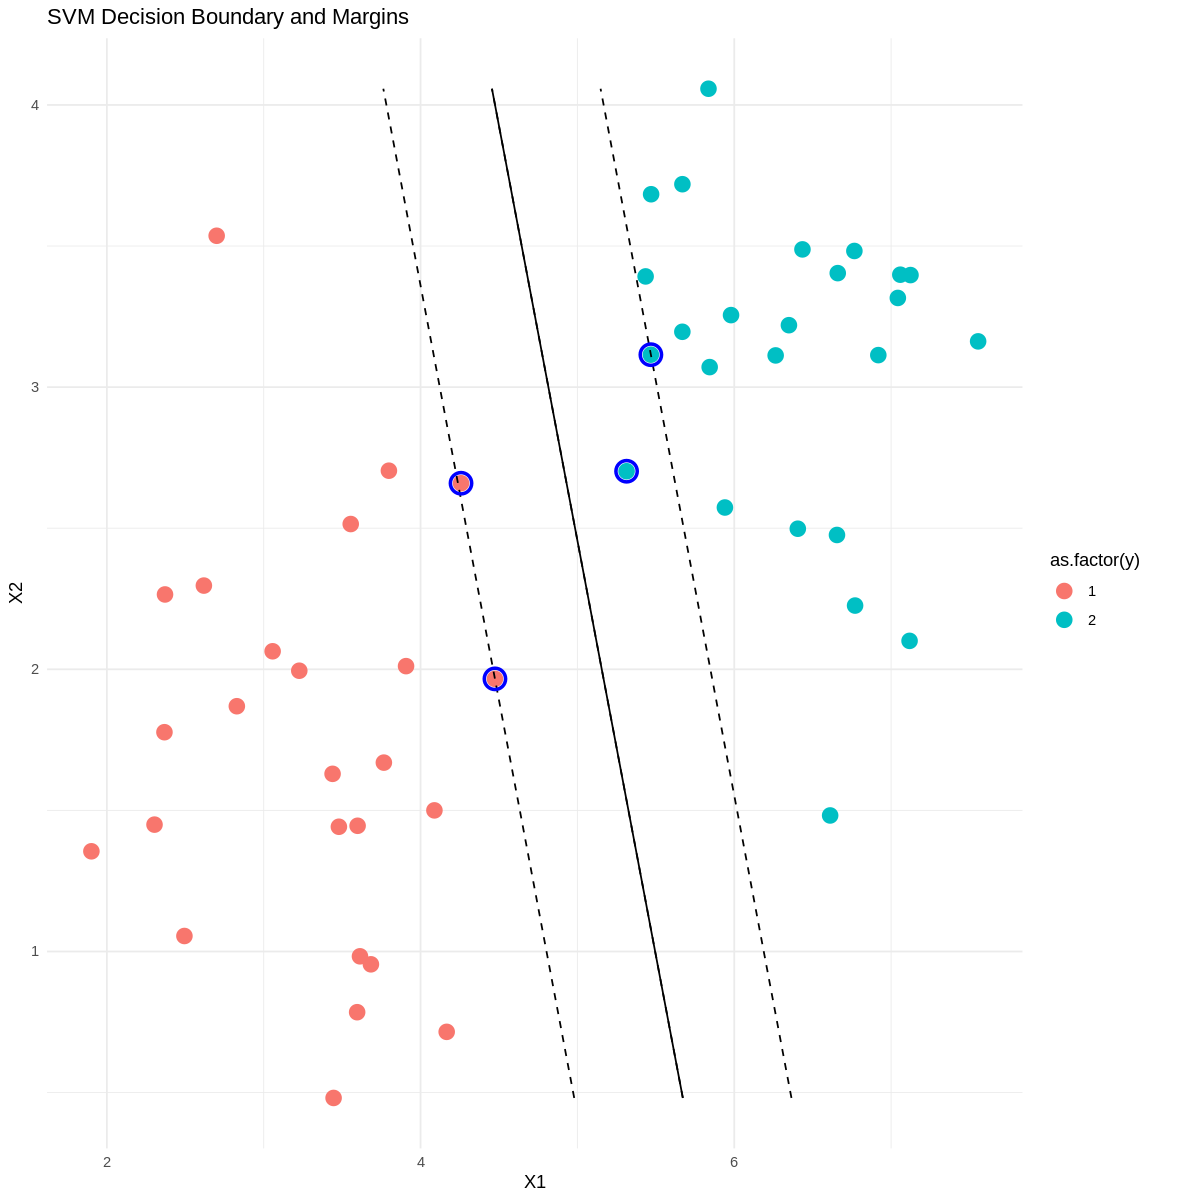

In [96]:
# Plot the decision function and margins
plot_svc_decision_function(svm_model, X_df)

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name.

In [97]:
# Access support vectors
support_vectors <- svm_model$SV

# View the support vectors
support_vectors

,X1,X2
2,4.258001,2.659386
20,4.474255,1.966096
35,5.468457,3.114943
44,5.313561,2.701940


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




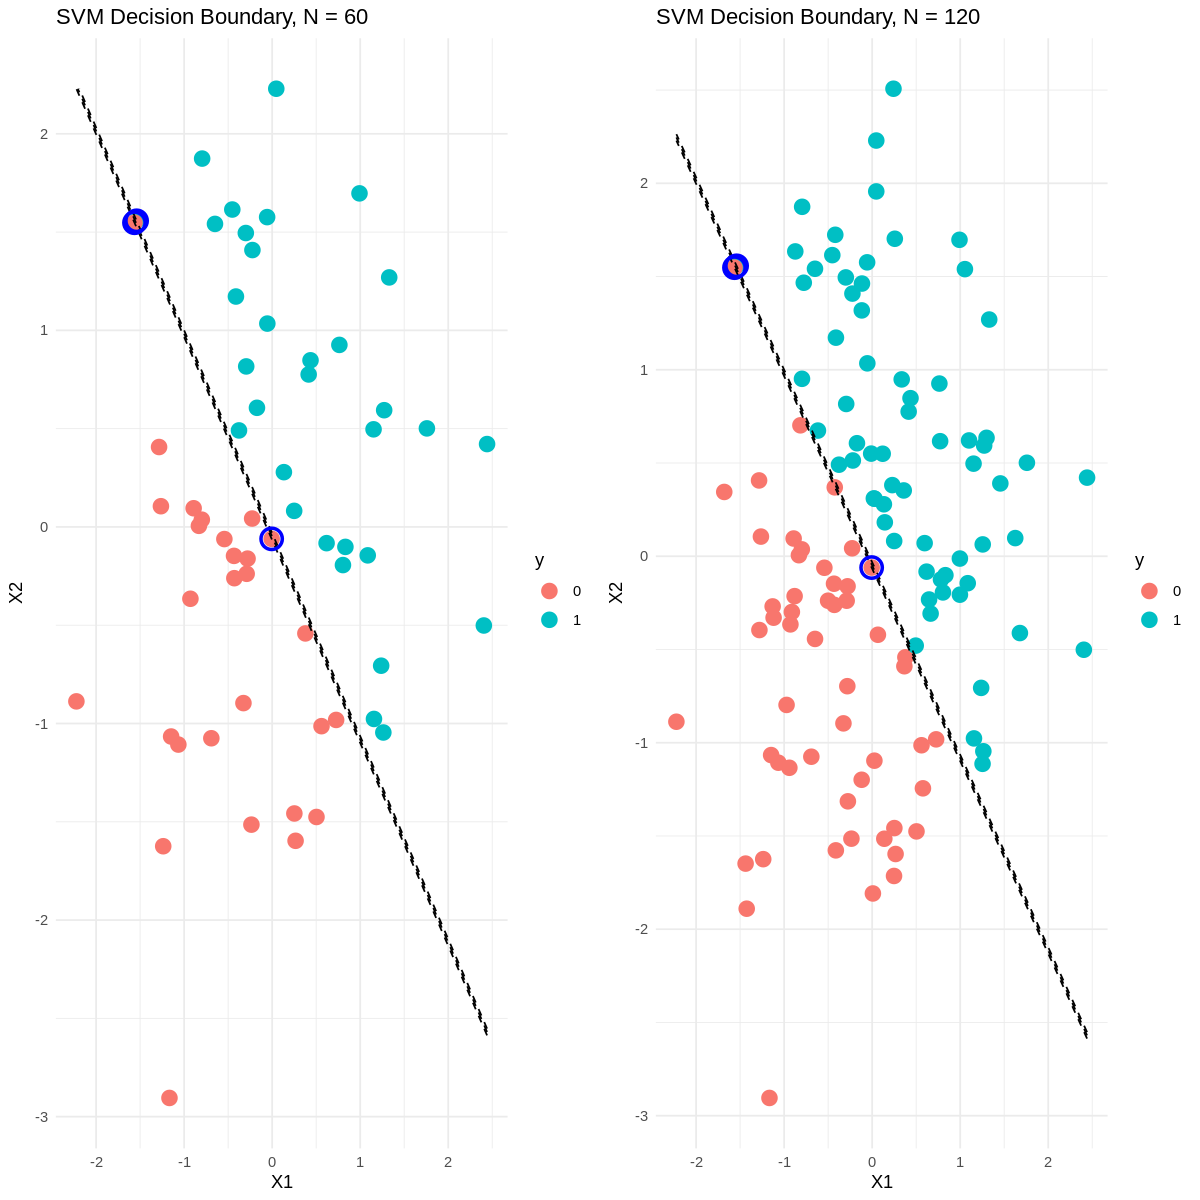

In [98]:
plot_svm <- function(N = 10) {
  set.seed(0)

  # Generate data
  X <- matrix(rnorm(400), ncol = 2)
  y <- ifelse(X[,1] + X[,2] > 0, 1, 0)

  # Subset the data
  X <- X[1:N, ]
  y <- y[1:N]

  # Convert to data frame
  X_df <- data.frame(X1 = X[, 1], X2 = X[, 2], y = as.factor(y))

  # Train SVM
  svm_model <- svm(y ~ X1 + X2, data = X_df, kernel = "linear", cost = 1e10, scale = FALSE)

  # Create grid for decision boundary plot
  xlim <- range(X_df$X1)
  ylim <- range(X_df$X2)
  x_vals <- seq(xlim[1], xlim[2], length.out = 100)
  y_vals <- seq(ylim[1], ylim[2], length.out = 100)
  grid <- expand.grid(X1 = x_vals, X2 = y_vals)

  # Predict decision function on the grid
  decision_values <- predict(svm_model, grid, decision.values = TRUE)
  grid$decision <- attributes(decision_values)$decision

  # Plot decision boundaries and margins
  p <- ggplot(X_df, aes(x = X1, y = X2, color = y)) +
    geom_point(size = 4) +
    stat_contour(data = grid, aes(x = X1, y = X2, z = decision),
                 breaks = c(-1, 0, 1),
                 color = "black", linetype = "dashed") +
    geom_point(data = data.frame(svm_model$SV), aes(x = X1, y = X2),
               shape = 21, size = 5, stroke = 1.5, color = "blue", fill = NA) +
    labs(title = paste("SVM Decision Boundary, N =", N), x = "X1", y = "X2") +
    theme_minimal()

  return(p)
}

# Plot for different N values
p1 <- plot_svm(N = 60)
p2 <- plot_svm(N = 120)

# Combine plots
install.packages("gridExtra")
library(gridExtra)
grid.arrange(p1, p2, ncol = 2)

#### **Beyond linear boundaries: Kernel SVM**

Where SVM becomes extremely powerful is when it is combined with kernels. We have seen a version of kernels before, in the basis polynomial transformations in Logistic Regression. There we projected our data into higher-dimensional space defined by feature crosses, and thereby were able to fit for nonlinear relationships with a linear classifier.

Generate non-linear seperable dataset and fit linear SVM

In [99]:
data <- make_circles(n_samples = 200, factor = 0.2, noise = 0.1)


In [100]:
svm_model <- svm(label ~ X1 + X2, data = data, kernel = "linear", cost = 1)

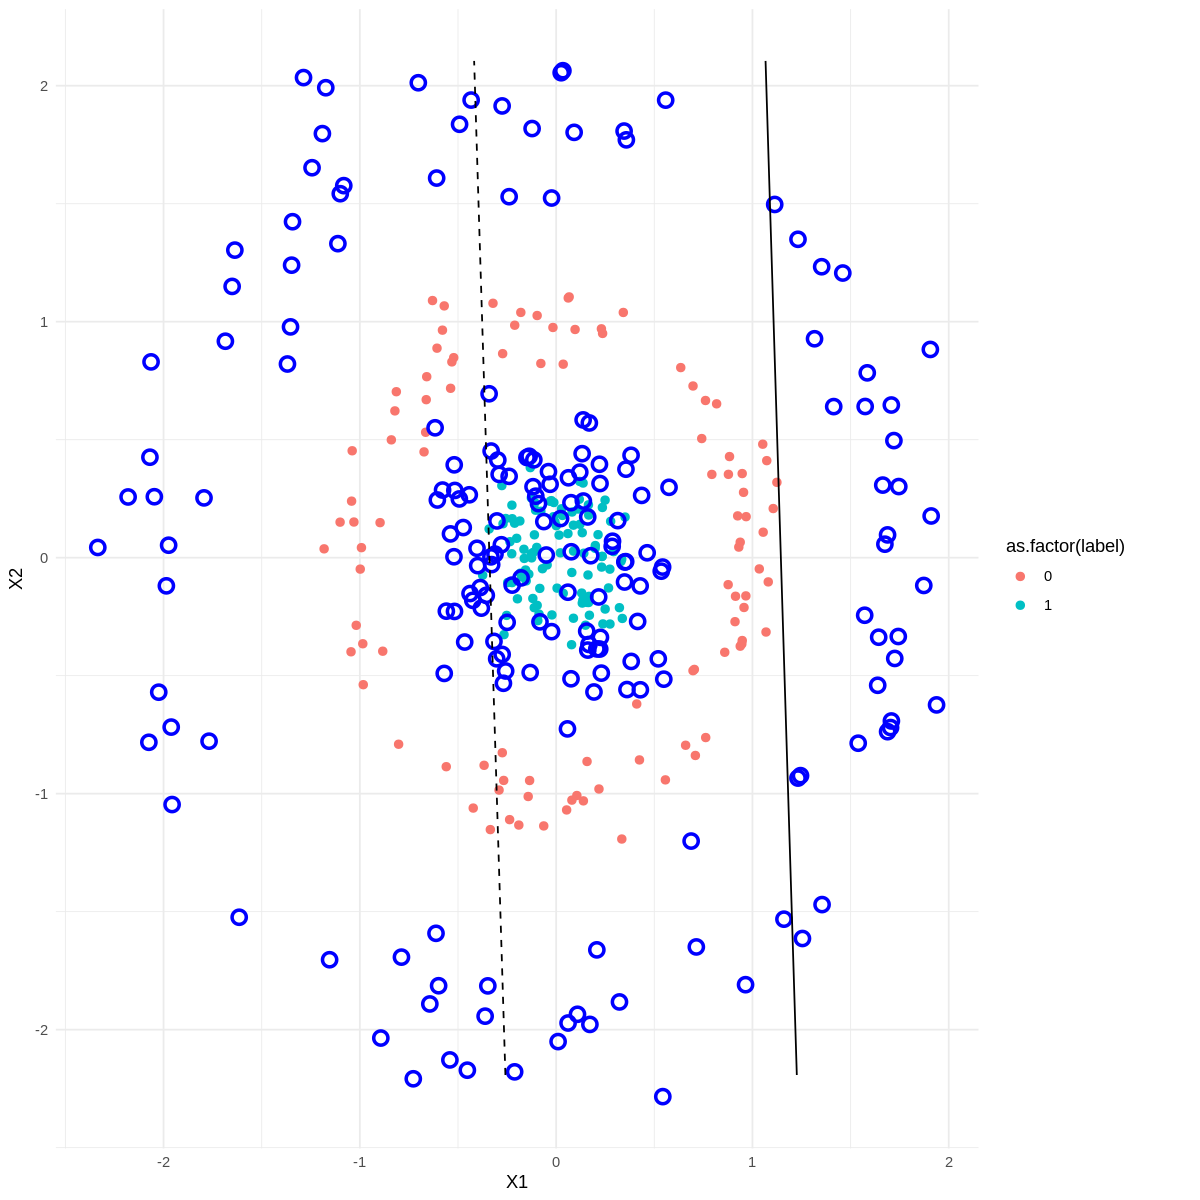

In [101]:
# Create a grid of points to evaluate the decision boundary
grid <- expand.grid(X1 = seq(min(data$X1)-1, max(data$X1)+1, length.out = 300),
                    X2 = seq(min(data$X2)-1, max(data$X2)+1, length.out = 300))

# Get decision values for the grid points
decision_values <- predict(svm_model, grid, decision.values = TRUE)

# Create a ggplot scatter plot
ggplot(data, aes(x = X1, y = X2, color = as.factor(label))) +
  geom_point(size = 2) +
  geom_point(data = as.data.frame(svm_model$SV), aes(x = X1, y = X2),
             shape = 21, size = 3, stroke = 1.5, color = "blue", fill = NA) +
  geom_contour(data = cbind(grid, decision_values), aes(z = decision_values),
               breaks = 0, color = "black") +
  geom_contour(data = cbind(grid, decision_values), aes(z = decision_values),
               breaks = c(-1, 1), linetype = "dashed", color = "black") +
  theme_minimal()


In [102]:

get_training_results_svm <- function(data) {

  y <- data$label
  # Fit svm model
  X <- data[,c(1,2)]
  model <- svm(label ~ X1 + X2, data = data, kernel = "linear", cost = 1)
  # Predict class probabilities on training data
  y_pred_prob <- predict(model, X, type = "response")

  # Convert probabilities to binary labels (threshold = 0.5)
  y_pred <- ifelse(y_pred_prob > 0.5, 1, 0)

  # Confusion matrix and classification report
  results <- confusionMatrix(as.factor(y_pred), as.factor(y), mode = "everything")

  # Print classification metrics (precision, recall, F1-score, etc.)
  print(results)
}

In [103]:
get_training_results_svm(data)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  37   0
         1  63 100
                                          
               Accuracy : 0.685           
                 95% CI : (0.6157, 0.7487)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 8.952e-08       
                                          
                  Kappa : 0.37            
                                          
 Mcnemar's Test P-Value : 5.662e-15       
                                          
            Sensitivity : 0.3700          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.6135          
              Precision : 1.0000          
                 Recall : 0.3700          
                     F1 : 0.5401          
             Prevalence : 0.5000          
         Detection Rate : 0.1850          
   Detection Prevalence : 0.1850          
      Balanced Accuracy : 0.68

If we could find a higher dimensional space in which these points were linearly separable, then we could do the following:

*  Map the original features to the higher, transformer space (feature mapping)
* Perform linear SVM in this higher space
*  Obtain a set of weights corresponding to the decision boundary hyperplane
*  Map this hyperplane back into the original 2D space to obtain a non linear decision boundary

There are many higher dimensional spaces in which these points are linearly separable. Here is one example

x1,x2:→z1,z2,z3
z1=√x1x2  z2=x1^2  z3=x1*x^2

This is where the Kernel trick comes into play.

Learn more kernels here :

https://www.youtube.com/watch?v=mTyT-oHoivA


https://www.youtube.com/watch?v=XfyR_49hfi8


Kernel is a way of computing the dot product of two vectors x and y in some (possibly very high dimensional) feature space, which is why kernel functions are sometimes called "generalized dot product".

The RBF and polynomial are especially useful when the data-points are not linearly separable.

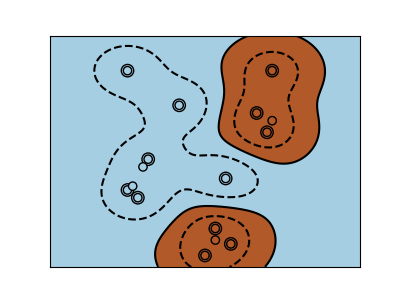

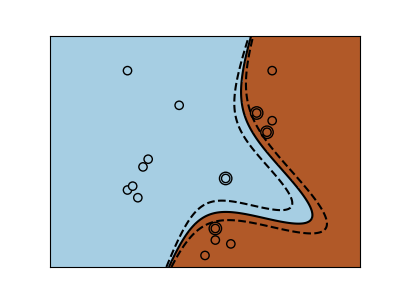

Fitting a radial basis function (**RBF**) kernel

RBF kernels are the most generalized form of kernelization and is one of the most widely used kernels due to its similarity to the Gaussian distribution. The RBF kernel function for two points X₁ and X₂ computes the similarity or how close they are to each other.

In [104]:
set.seed(0)
y <- data$label
  # Fit svm model
X <- data[,c(1,2)]
clf <- svm(x = X, y = as.factor(y), kernel = "radial")  # Use "radial" for RBF

In [105]:
# Function to get training results
get_training_results_svmrad <- function(model, X, y) {
  y_pred <- predict(model, X)  # Predict using the model

  # Print classification report
  print(confusionMatrix(as.factor(y_pred), as.factor(y)))  # Confusion matrix
  accuracy <- sum(y_pred == y) / length(y)  # Calculate accuracy
  cat("Accuracy on training set:", round(accuracy, 3), "\n")  # Print accuracy
}

# Call the function with the trained model
get_training_results_svmrad(clf, X, y)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 100   0
         1   0 100
                                     
               Accuracy : 1          
                 95% CI : (0.9817, 1)
    No Information Rate : 0.5        
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0        
            Specificity : 1.0        
         Pos Pred Value : 1.0        
         Neg Pred Value : 1.0        
             Prevalence : 0.5        
         Detection Rate : 0.5        
   Detection Prevalence : 0.5        
      Balanced Accuracy : 1.0        
                                     
       'Positive' Class : 0          
                                     
Accuracy on training set: 1 


Warning message:
“The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in
ggplot2 3.3.4.
ℹ Please use "none" instead.”


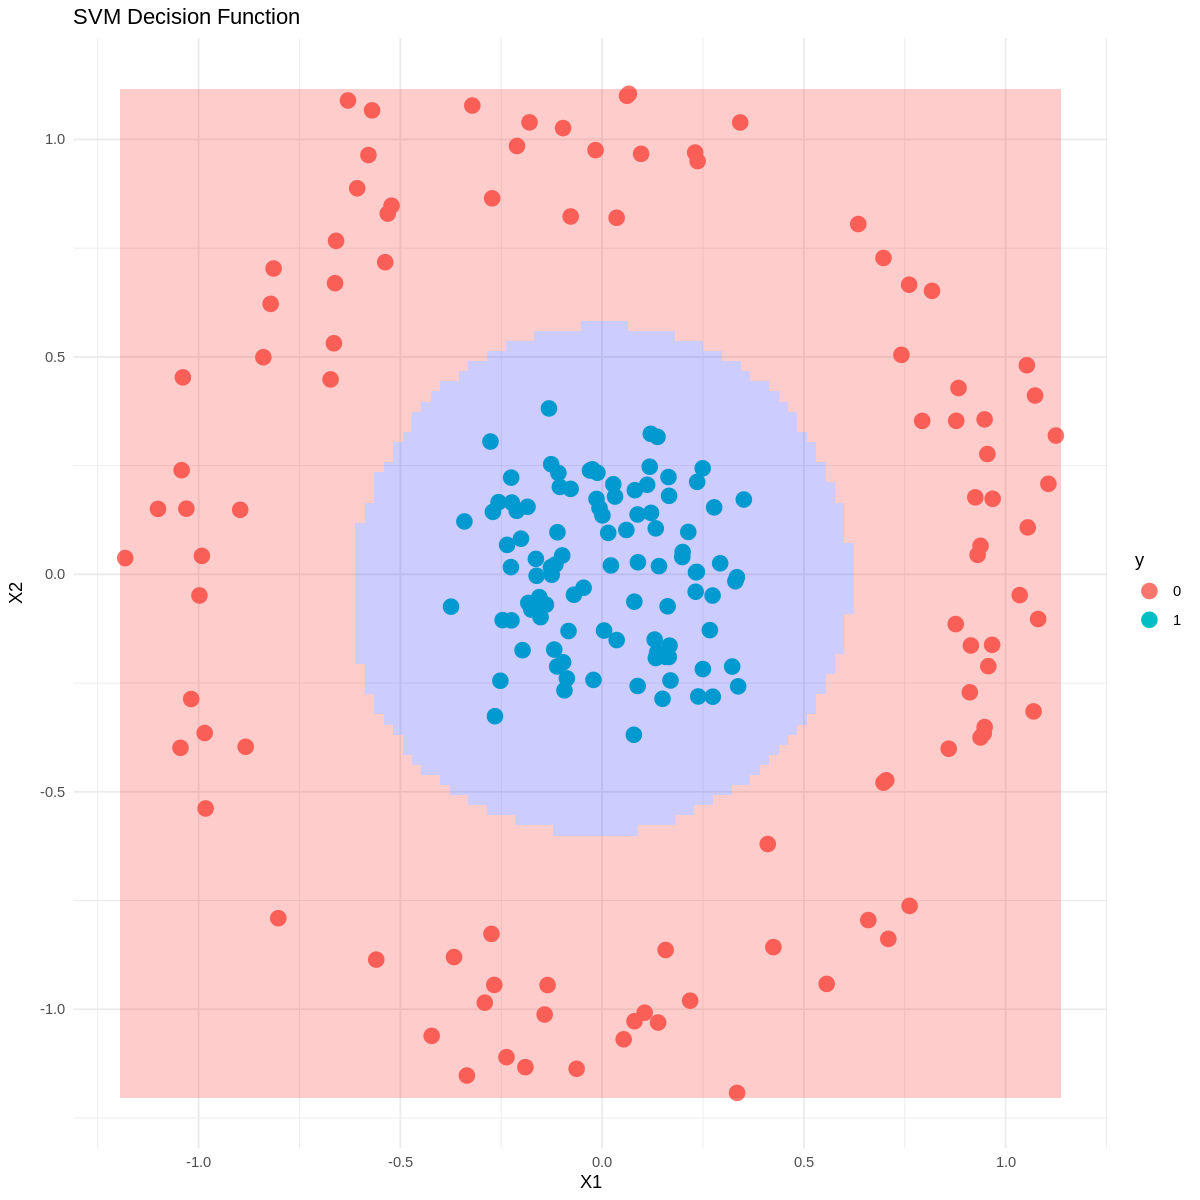

In [106]:
# Create a data frame for plotting
X_df <- data.frame(X1 = X[, 1], X2 = X[, 2], y = as.factor(y))

# Function to plot SVM decision function
plot_svm_decision_function <- function(model, data) {
  # Create grid for decision boundary
  xlim <- range(data$X1)
  ylim <- range(data$X2)

  grid <- expand.grid(X1 = seq(xlim[1], xlim[2], length.out = 100),
                      X2 = seq(ylim[1], ylim[2], length.out = 100))

  # Get predictions for the grid
  grid$decision <- predict(model, grid)

  # Create ggplot
  p <- ggplot(data, aes(x = X1, y = X2)) +
    geom_point(aes(color = y), size = 4) +
    geom_tile(data = grid, aes(fill = decision), alpha = 0.2) +  # Use geom_tile to fill the decision area
    scale_fill_manual(values = c('red', 'blue'), guide = FALSE) +
    labs(title = "SVM Decision Function", x = "X1", y = "X2") +
    theme_minimal()

  return(p)
}

# Plot SVM decision function
p <- plot_svm_decision_function(clf, X_df)
print(p)

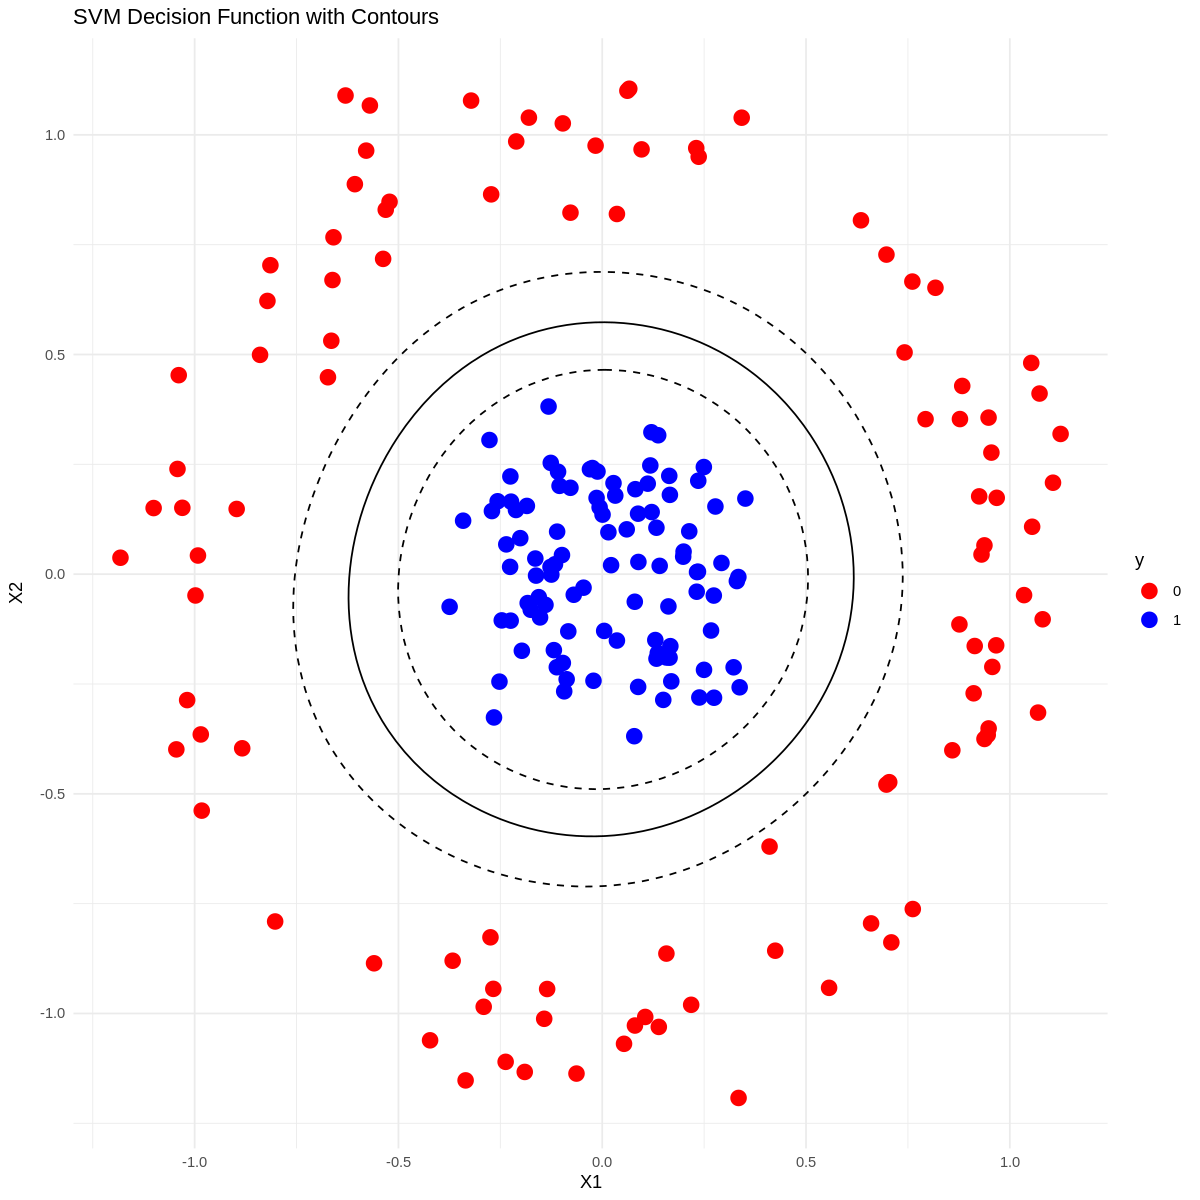

In [107]:
plot_svm_decision_function <- function(model, data) {
  # Create grid for decision boundary
  xlim <- range(data$X1)
  ylim <- range(data$X2)

  grid <- expand.grid(X1 = seq(xlim[1], xlim[2], length.out = 100),
                      X2 = seq(ylim[1], ylim[2], length.out = 100))

  # Get decision values for the grid
  decision_values <- predict(model, grid, decision.values = TRUE)
  grid$decision <- attributes(decision_values)$decision.values

  # Check if the decision values are valid
  if (all(is.na(grid$decision))) {
    stop("All decision values are NA. Please check your SVM model.")
  }

  # Create ggplot with contour lines
  p <- ggplot(data, aes(x = X1, y = X2)) +
    geom_point(aes(color = y), size = 4) +
    geom_contour(data = grid, aes(z = decision), breaks = 0, color = "black") +  # Contour line at decision boundary
    geom_contour(data = grid, aes(z = decision), breaks = c(-0.5, 0.5), linetype = "dashed", color = "black") +
    labs(title = "SVM Decision Function with Contours", x = "X1", y = "X2") +
    theme_minimal() +
    scale_color_manual(values = c('red', 'blue'))  # Adjust colors as needed

  return(p)
}

# Plot SVM decision function
p <- plot_svm_decision_function(clf, X_df)
print(p)

Fitting a polynomial kernel. This kernel is useful is the decision boundary is can be seperated by a higher-order polynomial

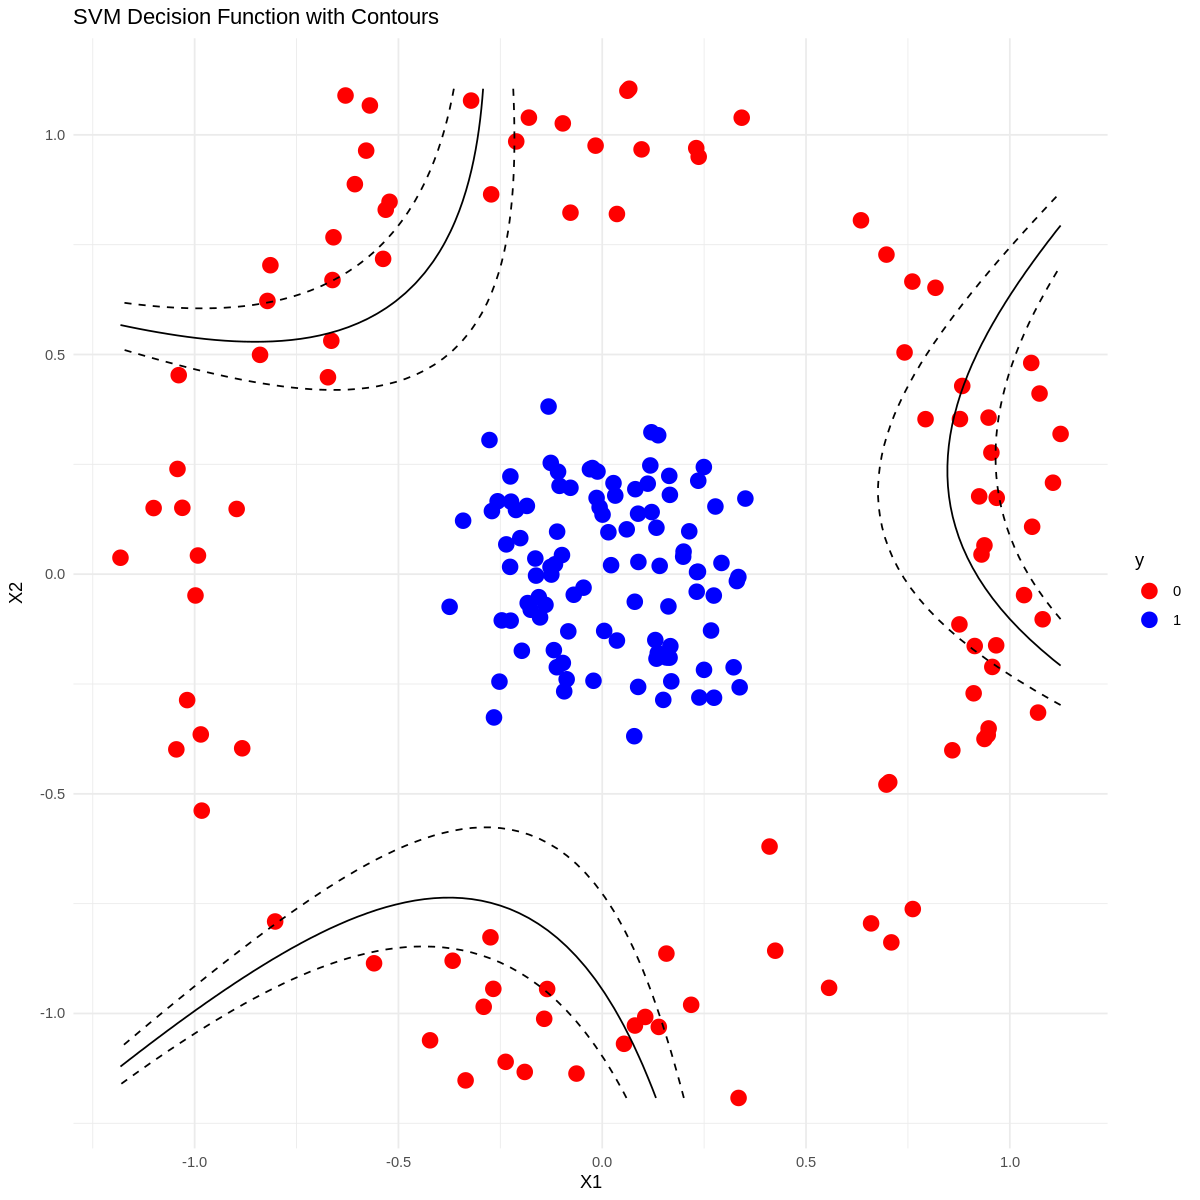

In [108]:
clf <- svm(y ~ ., data = data.frame(X1 = X[, 1], X2 = X[, 2], y = factor(y)), kernel = "polynomial")
p <- plot_svm_decision_function(clf, data.frame(X1 = X[, 1], X2 = X[, 2], y = factor(y)))
print(p)


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  39   0
         1  61 100
                                         
               Accuracy : 0.695          
                 95% CI : (0.6261, 0.758)
    No Information Rate : 0.5            
    P-Value [Acc > NIR] : 1.759e-08      
                                         
                  Kappa : 0.39           
                                         
 Mcnemar's Test P-Value : 1.564e-14      
                                         
            Sensitivity : 0.3900         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.6211         
             Prevalence : 0.5000         
         Detection Rate : 0.1950         
   Detection Prevalence : 0.1950         
      Balanced Accuracy : 0.6950         
                                         
       'Positive' Class : 0              
                                         
Accuracy

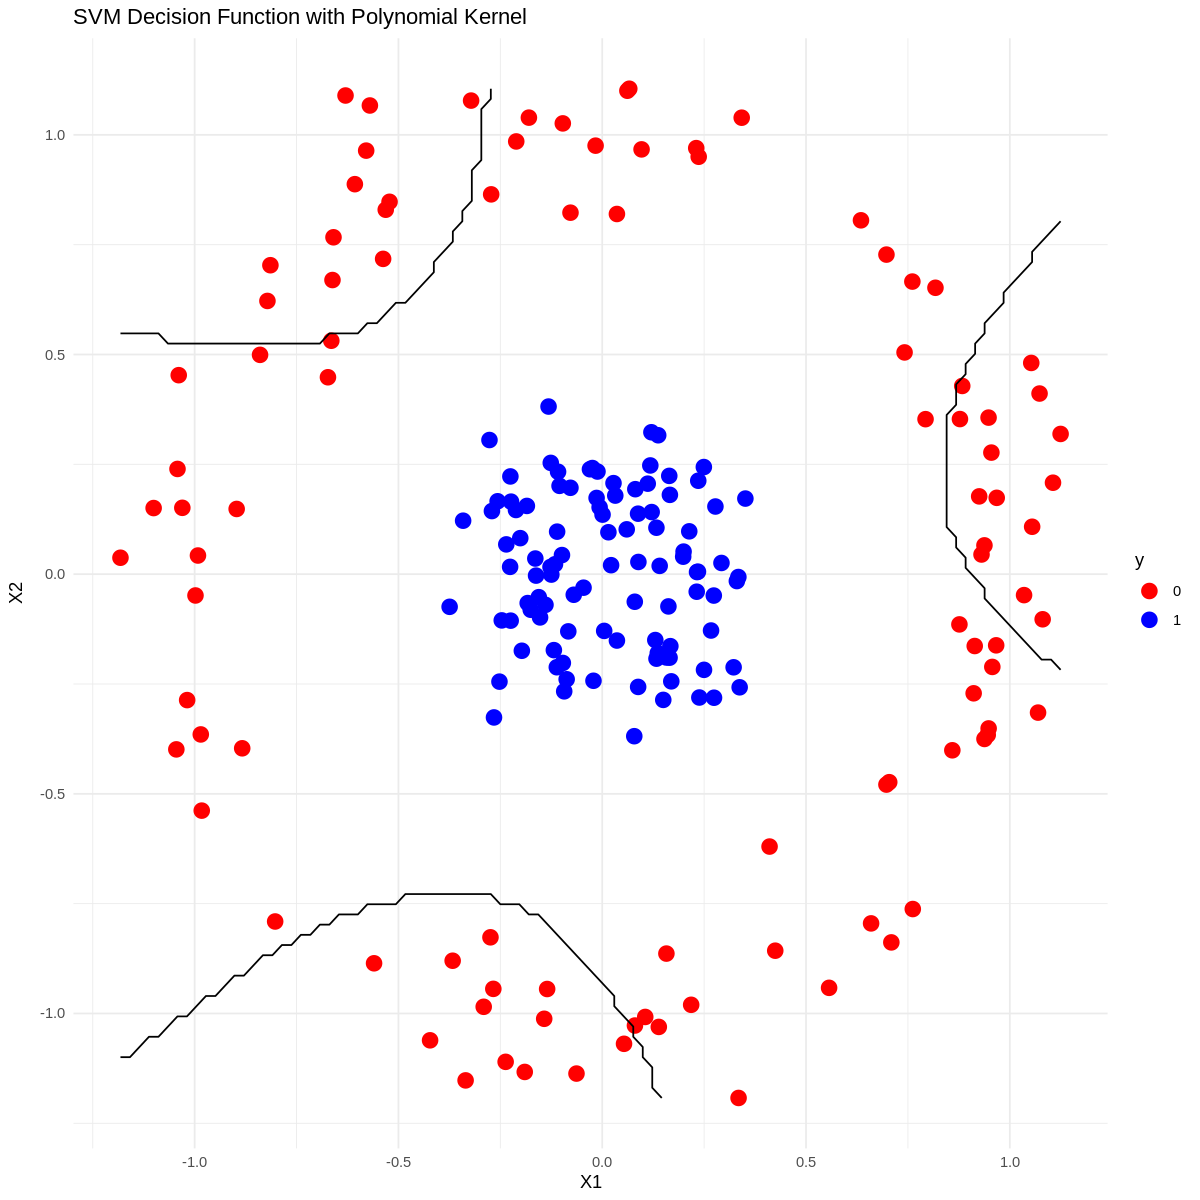

In [109]:
# Fit SVM model with polynomial kernel
clf <- svm(y ~ ., data = data.frame(X1 = X[, 1], X2 = X[, 2], y = factor(y)), kernel = "polynomial")

# Function to get training results
get_training_results <- function(model, data) {
  y_pred <- predict(model, data)
  # Convert probabilities to binary labels (threshold = 0.5)
  #y_pred <- ifelse(y_pred_prob > 0.5, 1, 0)
  confusion_matrix <- confusionMatrix(as.factor(y_pred), as.factor(data$y))

  print(confusion_matrix)
  accuracy <- sum(y_pred == data$y) / length(y_pred)
  cat("Accuracy on training set:", round(accuracy, 3), "\n")
}

# Get training results
get_training_results(clf, data.frame(X1 = X[, 1], X2 = X[, 2], y = factor(y)))

# Function to plot SVM decision function with contours
plot_svm_decision_function <- function(model, data) {
  # Create grid for decision boundary
  xlim <- range(data$X1)
  ylim <- range(data$X2)

  grid <- expand.grid(X1 = seq(xlim[1], xlim[2], length.out = 100),
                      X2 = seq(ylim[1], ylim[2], length.out = 100))

  # Get predictions for the grid
  grid$pred <- predict(model, grid)

  # Check the unique predicted values
  unique_preds <- unique(grid$pred)
  if (length(unique_preds) < 2) {
    stop("Insufficient unique predictions for contour plotting.")
  }

  # Create ggplot with decision boundary
  p <- ggplot(data, aes(x = X1, y = X2)) +
    geom_point(aes(color = y), size = 4) +
    geom_contour(data = grid, aes(z = as.numeric(pred)), breaks = unique(as.numeric(data$y)), color = "black") +  # Contour lines
    labs(title = "SVM Decision Function with Polynomial Kernel", x = "X1", y = "X2") +
    theme_minimal() +
    scale_color_manual(values = c('red', 'blue'))  # Adjust colors as needed

  return(p)
}
# Plot SVM decision function
p <- plot_svm_decision_function(clf, data.frame(X1 = X[, 1], X2 = X[, 2], y = factor(y)))
print(p)


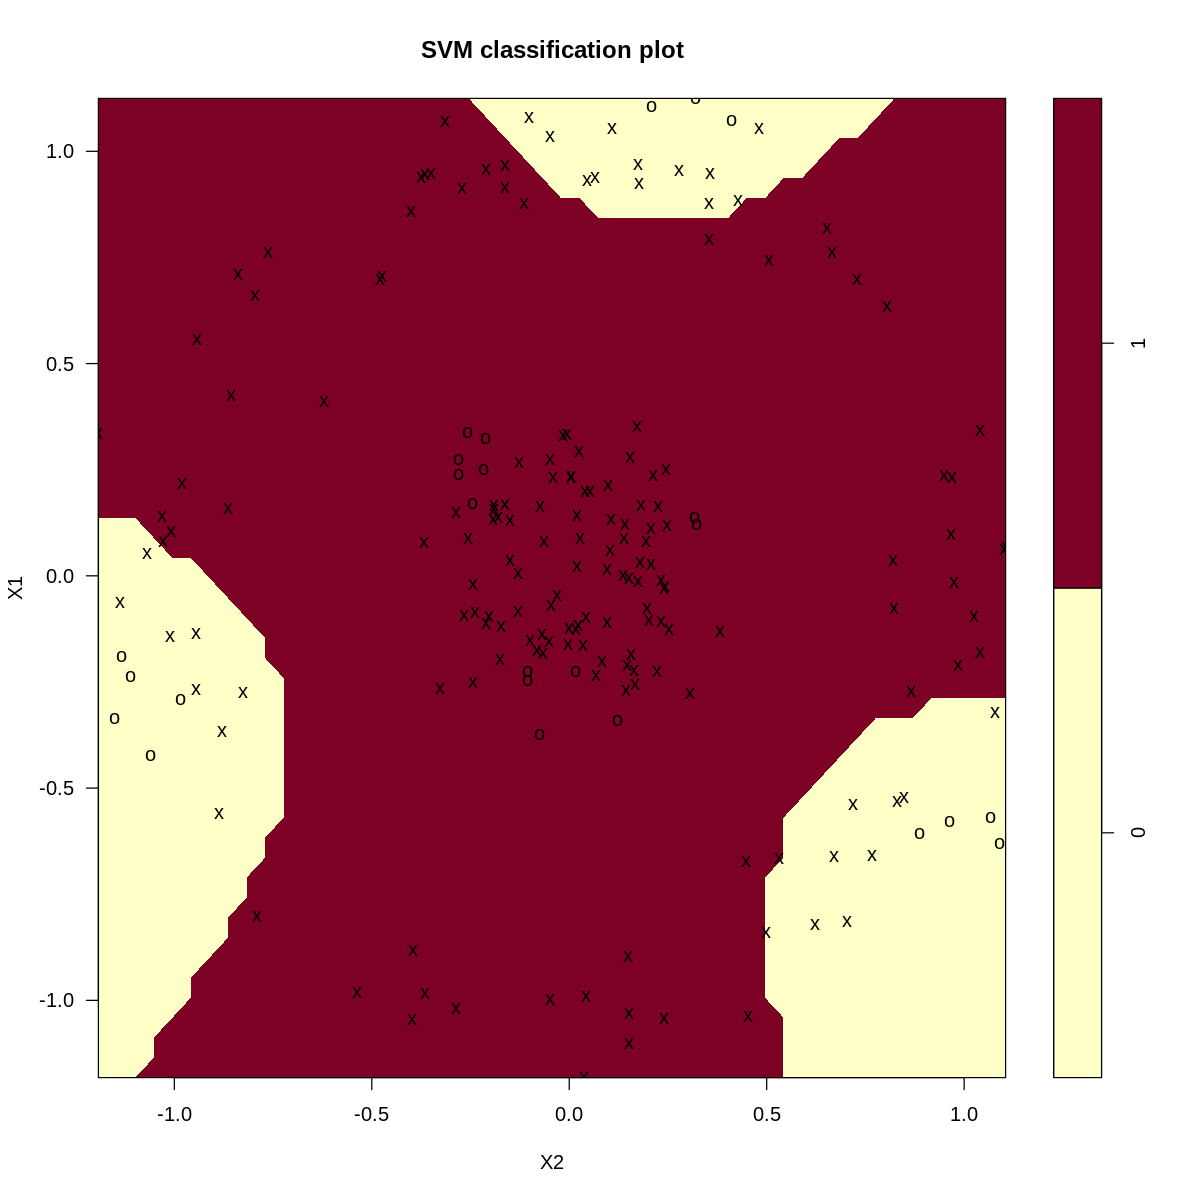

In [110]:
plot(clf, data)

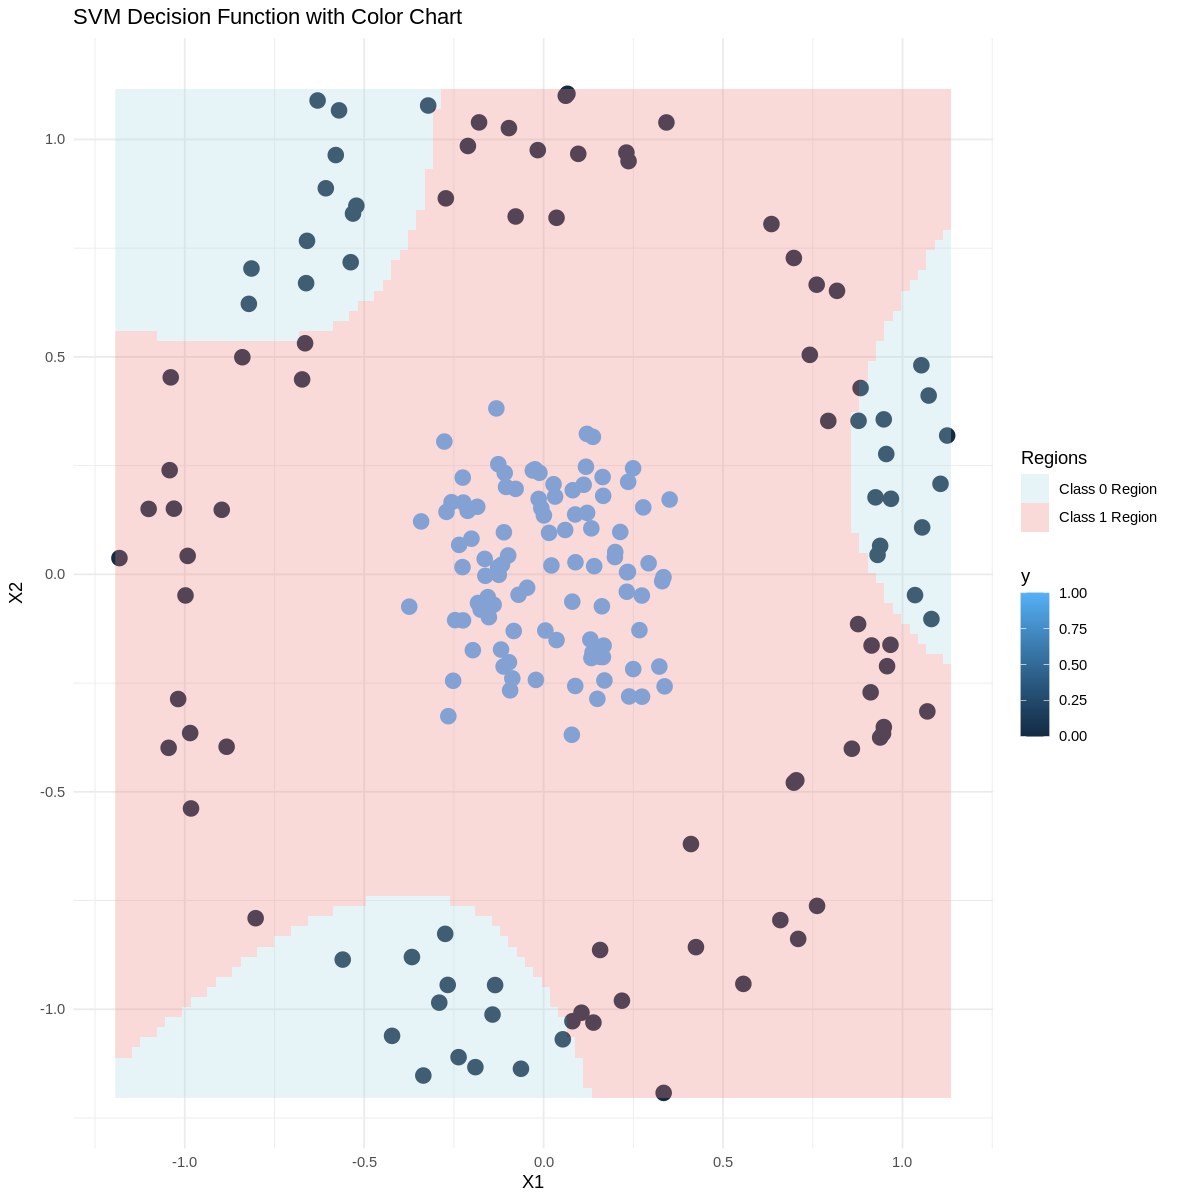

In [111]:
X_df <- data.frame(X1 = X[, 1], X2 = X[, 2], y = y)
plot_svm_decision_function_with_colors <- function(model, data) {
  # Create grid for decision boundary
  xlim <- range(data$X1)
  ylim <- range(data$X2)

  grid <- expand.grid(X1 = seq(xlim[1], xlim[2], length.out = 100),
                      X2 = seq(ylim[1], ylim[2], length.out = 100))

  # Get predictions for the grid
  grid$decision <- predict(model, grid)
  grid$decision <- factor(grid$decision)  # Convert predictions to factor (discrete)

  # Create ggplot with color chart (legend)
  p <- ggplot(data, aes(x = X1, y = X2)) +
    geom_point(aes(color = y), size = 4) +
    #geom_contour(data = grid, aes(z = as.numeric(decision)), breaks = c(0.5), color = "black") +  # Contour line at decision boundary
    #scale_color_manual(values = c('red', 'blue'), labels = c("Class 0", "Class 1")) +  # Class colors
    geom_raster(data = grid, aes(fill = decision), alpha = 0.3) +  # Add filled decision regions
    scale_fill_manual(values = c('lightblue', 'lightcoral'), labels = c("Class 0 Region", "Class 1 Region")) +  # Fill colors for regions
    labs(title = "SVM Decision Function with Color Chart", x = "X1", y = "X2", fill = "Regions") +
    theme_minimal()

}

# Plot SVM decision function with color chart
p <- plot_svm_decision_function_with_colors(clf, X_df)
print(p)

**Another dataset**



In [112]:
library(mlbench)
library(ggplot2)

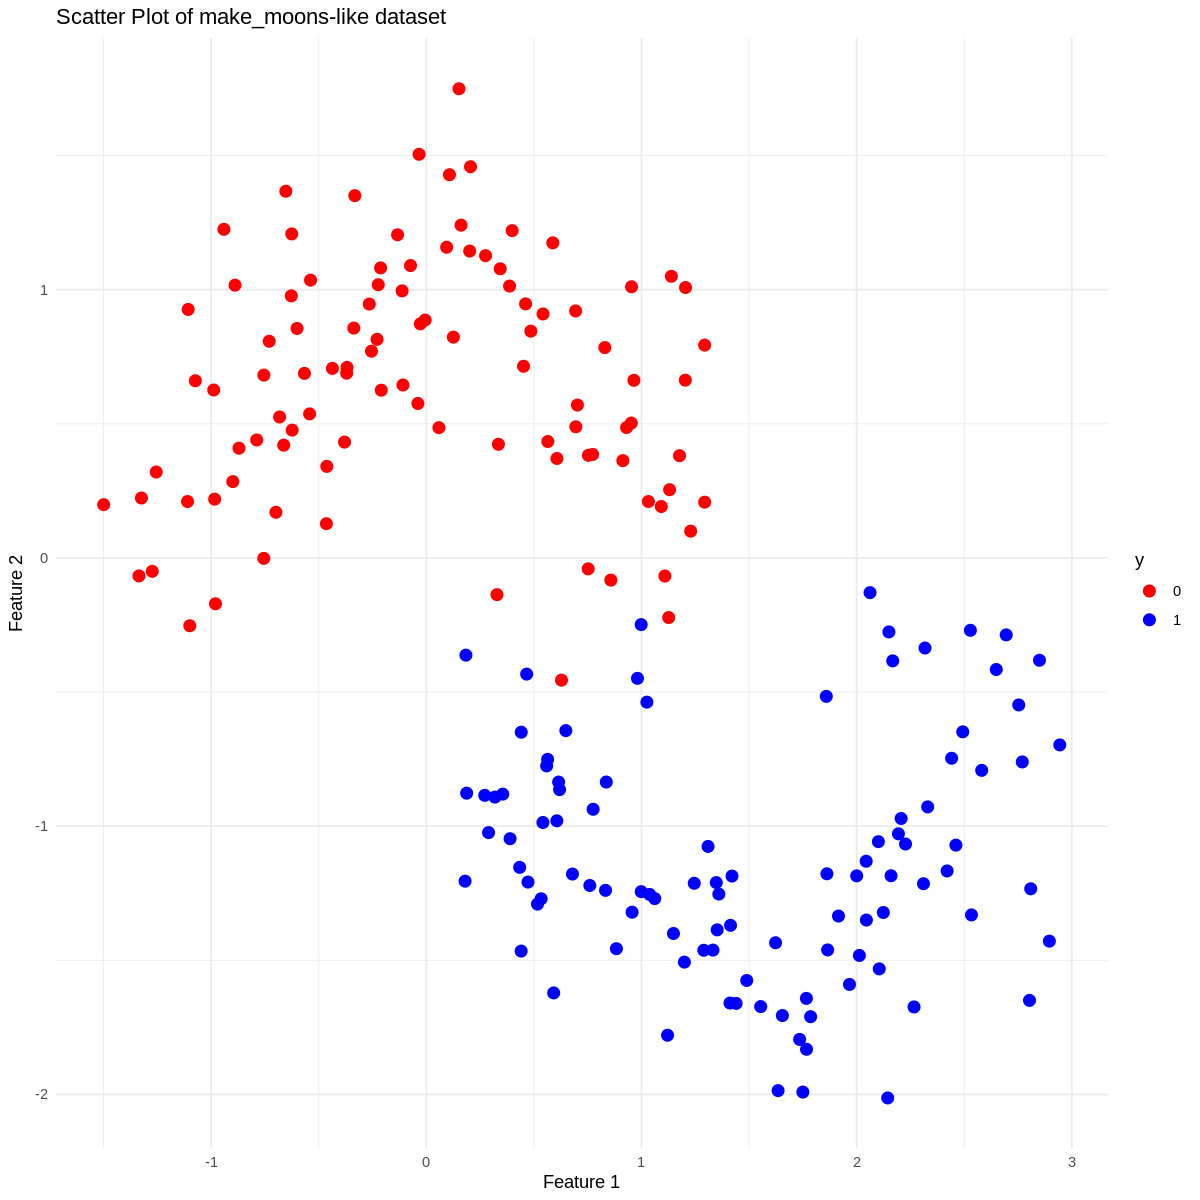

In [113]:
generate_moons <- function(n = 200, noise = 0.3) {
  t <- seq(0, pi, length.out = n / 2)
  x1 <- c(cos(t), 1 - cos(t) + 0.5)
  y1 <- c(sin(t), -sin(t) - 0.5)

  X <- cbind(x1, y1)

  # Add noise to the data
  X <- X + matrix(rnorm(length(X), sd = noise), ncol = 2)

  y <- as.factor(c(rep(0, n / 2), rep(1, n / 2)))

  return(data.frame(X1 = X[,1], X2 = X[,2], y = y))
}

# Generate the dataset
moon_df <- generate_moons(n = 200, noise = 0.3)

# Custom color palette (for two classes: red and blue)
custom_colors <- c('#FF0000', '#0000FF')

# Plot the data using ggplot2
ggplot(moon_df, aes(x = X1, y = X2, color = y)) +
  geom_point(size = 3) +
  scale_color_manual(values = custom_colors) +
  labs(title = 'Scatter Plot of make_moons-like dataset', x = 'Feature 1', y = 'Feature 2') +
  theme_minimal()

In [114]:
svm_model <- svm(y ~ X1 + X2, data = moon_df, kernel = "linear", cost = 1)

In [115]:
moon_df

X1,X2,y
<dbl>,<dbl>,<fct>
1.1307050,0.25429949,0
0.6282350,-0.45558143,0
0.9307063,0.48599293,0
1.1086906,-0.06747207,0
1.0319557,0.21019187,0
1.2286957,0.09980957,0
0.9647967,0.66209870,0
1.1265122,-0.22235376,0
1.2936795,0.20776552,0


Range of decision values:  -6.257085 8.473454 


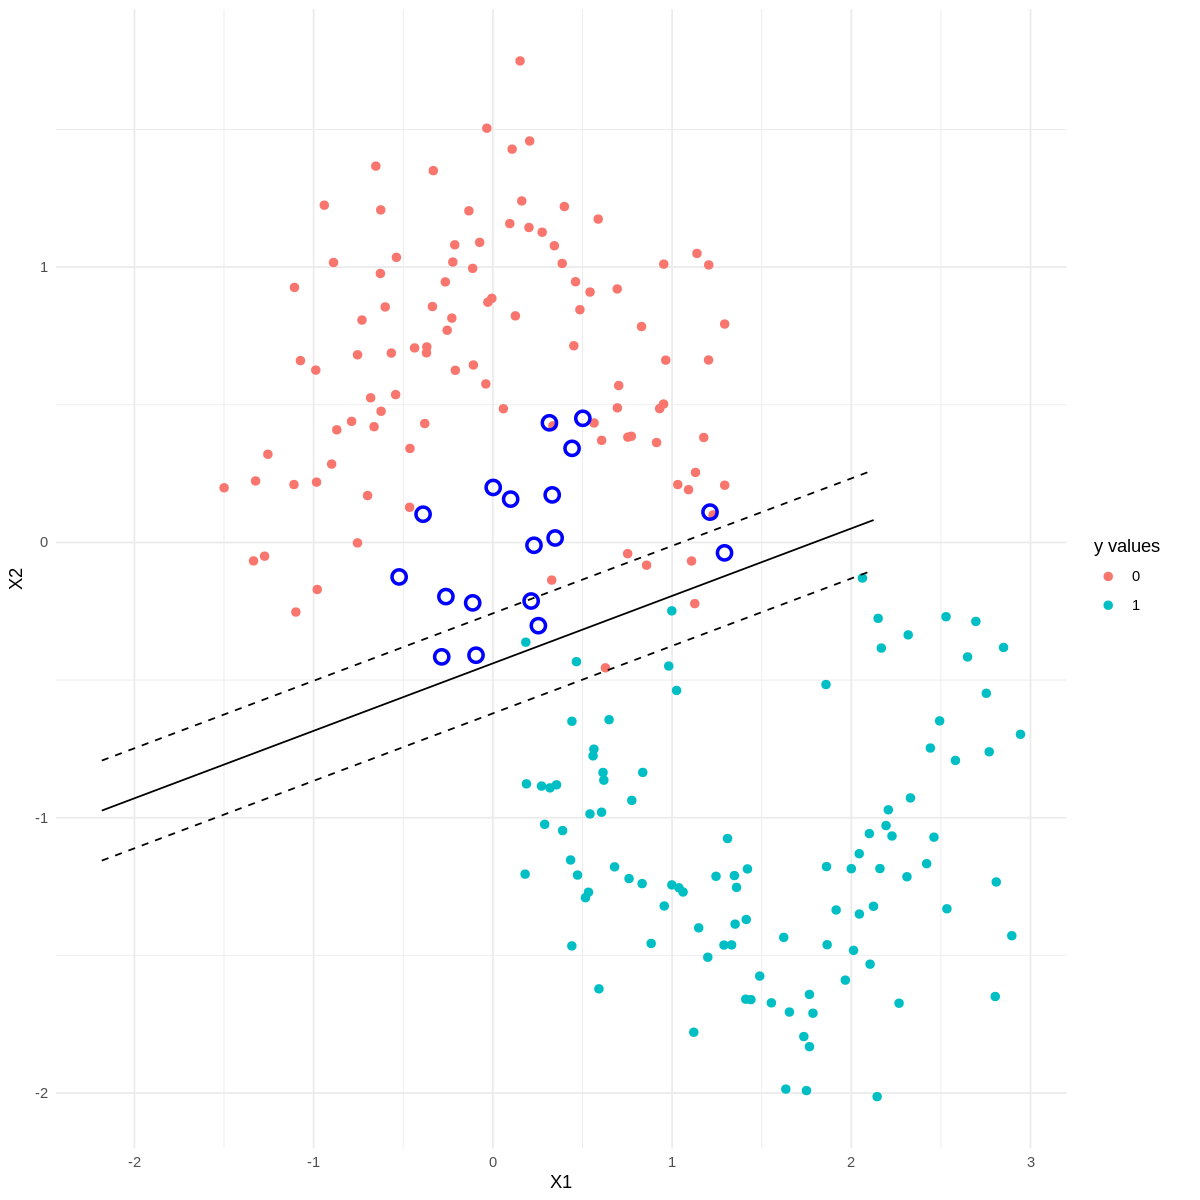

In [116]:
# Predict decision values (continuous scores, not classes)
decision_values <- attributes(predict(svm_model, grid, decision.values = TRUE))$decision.values

# Check if decision_values contains a meaningful range
cat("Range of decision values: ", range(decision_values), "\n")

# Add decision values to the grid data
grid_data <- cbind(grid, decision_values = decision_values)

# Plot
ggplot(moon_df, aes(x = X1, y = X2, color = as.factor(y))) +
  geom_point(size = 2) +
  geom_point(data = as.data.frame(svm_model$SV), aes(x = X1, y = X2),
             shape = 21, size = 3, stroke = 1.5, color = "blue", fill = NA) +
  geom_contour(data = grid_data, aes(x = X1, y = X2, z = decision_values),
               breaks = 0, color = "black") +  # Decision boundary (where decision_values = 0)
  geom_contour(data = grid_data, aes(x = X1, y = X2, z = decision_values),
               breaks = c(-0.5, 0.5), linetype = "dashed", color = "black") +  # Margins
  labs(color = "y values") +
  theme_minimal()


In [117]:
get_training_results_svm <- function(data) {

  y <- data$y
  # Fit svm model
  X <- data[,c(1,2)]
  model <- svm(y ~ X1 + X2, data = data, kernel = "linear", cost = 1)
  # Predict class probabilities on training data
  y_pred <- predict(model, X, type = "response")

  # Convert probabilities to binary labels (threshold = 0.5)
  # y_pred <- ifelse(y_pred_prob > 0.5, 1, 0)

  # Confusion matrix and classification report
  results <- confusionMatrix(as.factor(y_pred), as.factor(y), mode = "everything")

  # Print classification metrics (precision, recall, F1-score, etc.)
  print(results)
}
get_training_results_svm(moon_df)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 98  1
         1  2 99
                                          
               Accuracy : 0.985           
                 95% CI : (0.9568, 0.9969)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.97            
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9800          
            Specificity : 0.9900          
         Pos Pred Value : 0.9899          
         Neg Pred Value : 0.9802          
              Precision : 0.9899          
                 Recall : 0.9800          
                     F1 : 0.9849          
             Prevalence : 0.5000          
         Detection Rate : 0.4900          
   Detection Prevalence : 0.4950          
      Balanced Accuracy : 0.9850    

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  95   0
         1   5 100
                                          
               Accuracy : 0.975           
                 95% CI : (0.9426, 0.9918)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.95            
                                          
 Mcnemar's Test P-Value : 0.07364         
                                          
            Sensitivity : 0.9500          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9524          
             Prevalence : 0.5000          
         Detection Rate : 0.4750          
   Detection Prevalence : 0.4750          
      Balanced Accuracy : 0.9750          
                                          
       'Positive' Class : 0               
                              

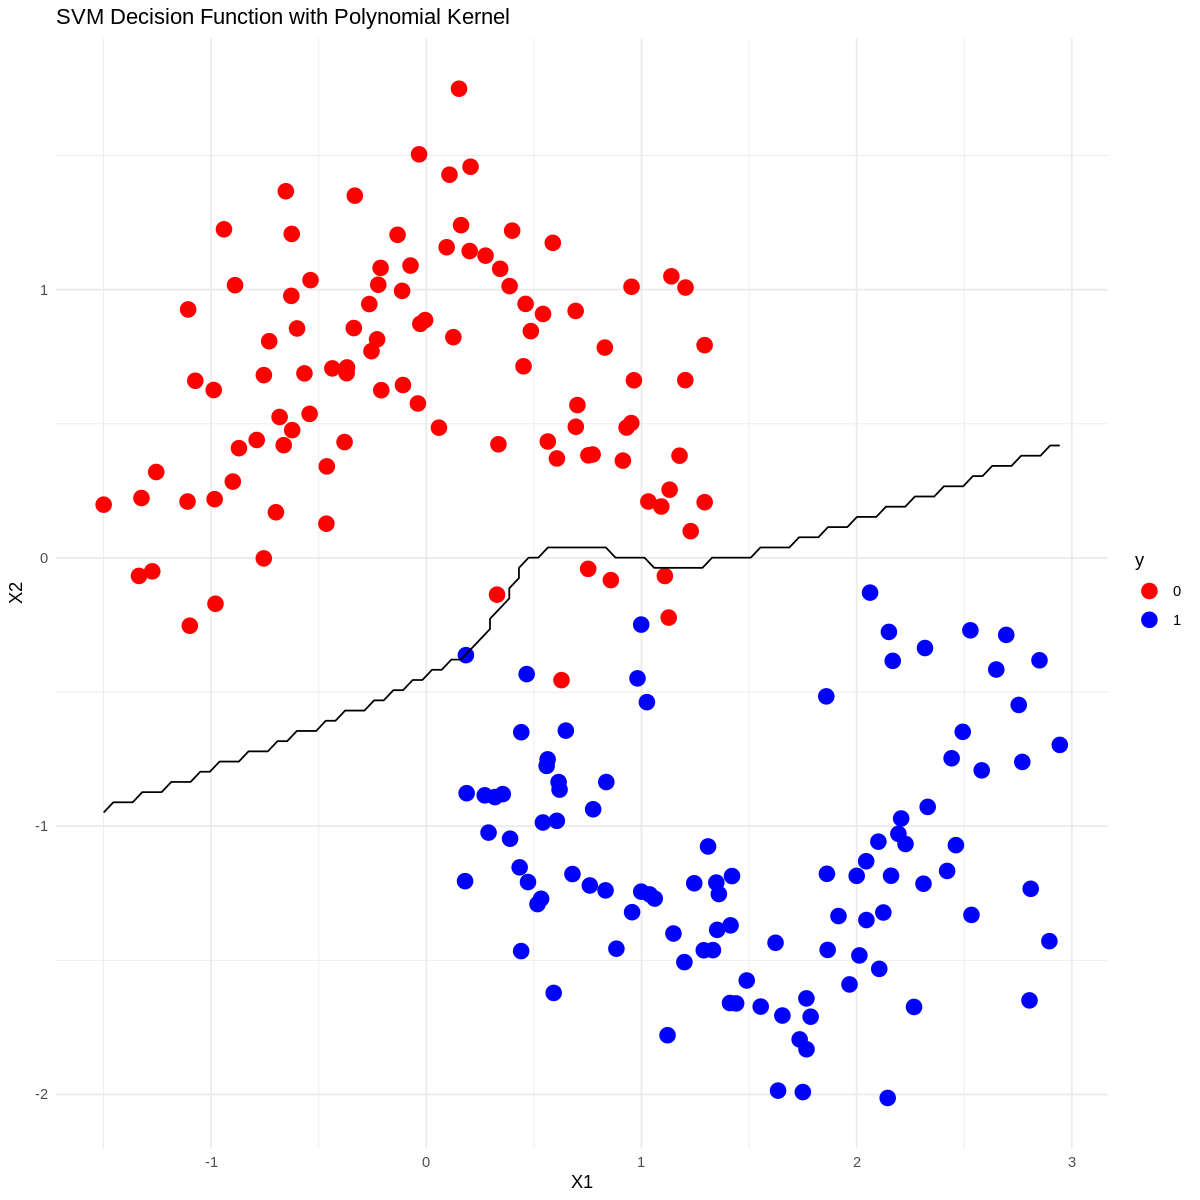

In [118]:
# Fit SVM model with polynomial kernel
clf <- svm(y ~ ., data = moon_df, kernel = "polynomial")

# Get training results
get_training_results(clf, moon_df)

# Function to plot SVM decision function with contours
# Plot SVM decision function
p <- plot_svm_decision_function(clf, moon_df)
print(p)


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 99  2
         1  1 98
                                          
               Accuracy : 0.985           
                 95% CI : (0.9568, 0.9969)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.97            
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9900          
            Specificity : 0.9800          
         Pos Pred Value : 0.9802          
         Neg Pred Value : 0.9899          
             Prevalence : 0.5000          
         Detection Rate : 0.4950          
   Detection Prevalence : 0.5050          
      Balanced Accuracy : 0.9850          
                                          
       'Positive' Class : 0               
                                    

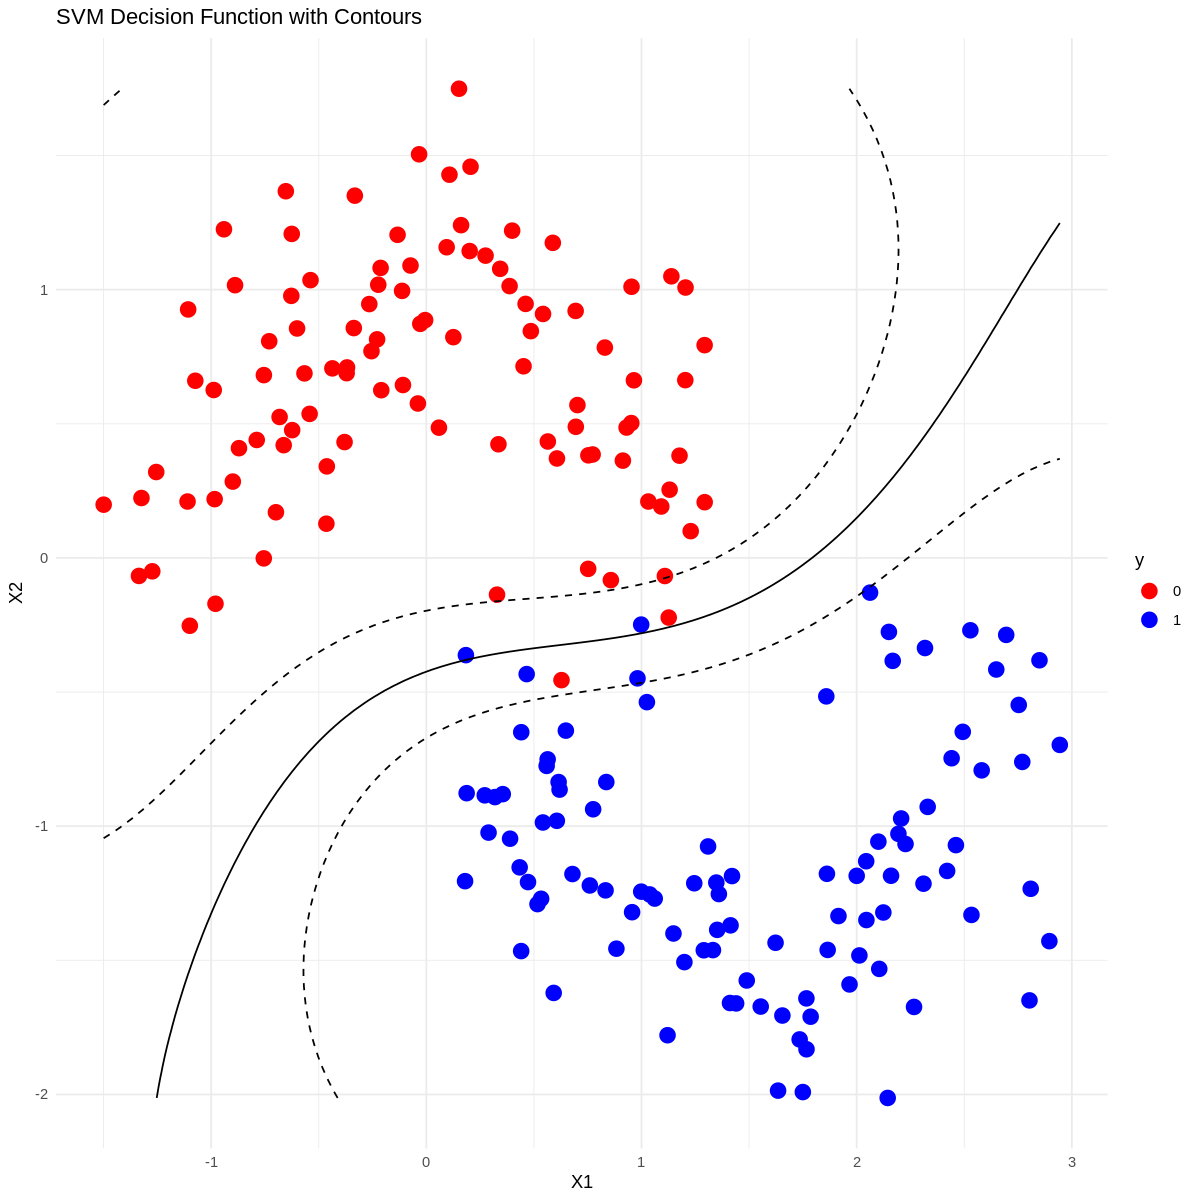

In [119]:
plot_svm_decision_function <- function(model, data) {
  # Create grid for decision boundary
  xlim <- range(data$X1)
  ylim <- range(data$X2)

  grid <- expand.grid(X1 = seq(xlim[1], xlim[2], length.out = 100),
                      X2 = seq(ylim[1], ylim[2], length.out = 100))

  # Get decision values for the grid
  decision_values <- predict(model, grid, decision.values = TRUE)
  grid$decision <- attributes(decision_values)$decision.values

  # Check if the decision values are valid
  if (all(is.na(grid$decision))) {
    stop("All decision values are NA. Please check your SVM model.")
  }

  # Create ggplot with contour lines
  p <- ggplot(data, aes(x = X1, y = X2)) +
    geom_point(aes(color = y), size = 4) +
    geom_contour(data = grid, aes(z = decision), breaks = 0, color = "black") +  # Contour line at decision boundary
    geom_contour(data = grid, aes(z = decision), breaks = c(-0.5, 0.5), linetype = "dashed", color = "black") +
    labs(title = "SVM Decision Function with Contours", x = "X1", y = "X2") +
    theme_minimal() +
    scale_color_manual(values = c('red', 'blue'))  # Adjust colors as needed

  return(p)
}

moon_X <- moon_df[,c(1,2)]
moon_y <- moon_df[,3]

clf <- svm(x = moon_X, y = as.factor(moon_y), kernel = "radial")  # Use "radial" for RBF
p <- plot_svm_decision_function(clf, moon_df)
print(p)


get_training_results_svmrad(clf, moon_X, moon_y)

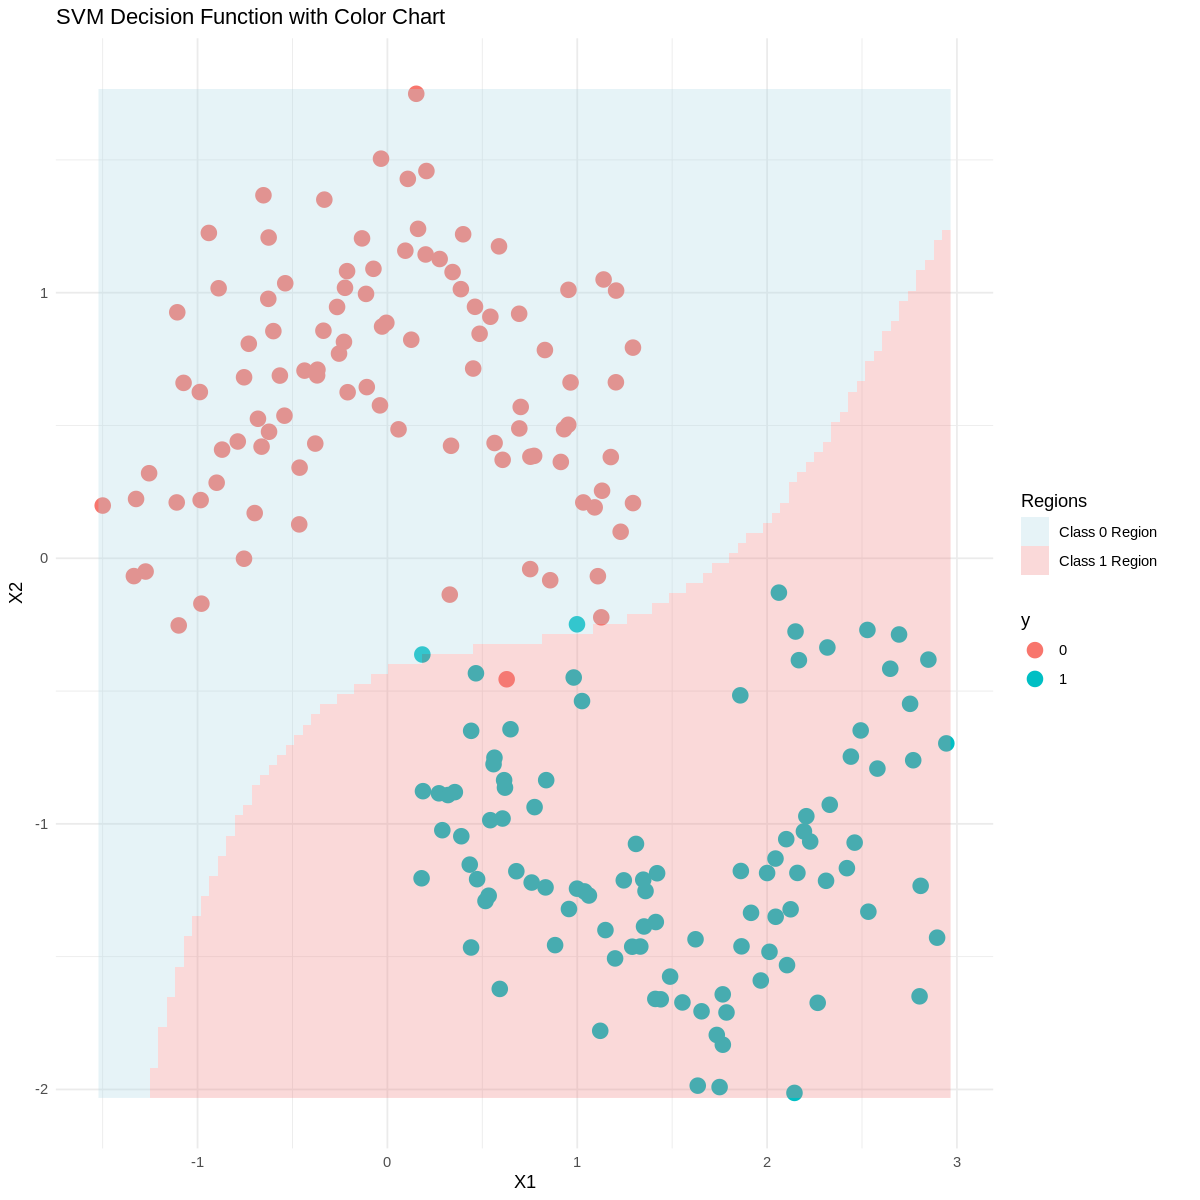

In [120]:
p <- plot_svm_decision_function_with_colors(clf, moon_df)
print(p)

**The END** <br>**Authors: Dr. Samir Gupta, Dr. Matthew McCoy,  Jia Li Dong \(M.S.\) & ICBI AIM\-AHEAD Team**

<img src="https://raw.githubusercontent.com/ICBI/AIMAHEAD_GU_publicCourseData/main/HIDSLOGO.AA1.jpg" alt="Powered by" width="500"/>

